# Analyze experimental data from the high-throughput stability assay

## Import `Python` modules and initialize results directory

In [1]:
# Import `Python` modules
import os
import glob
import random
import doctest
import pandas
import subprocess
import Bio.PDB
from Bio.Data import CodonTable
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
import re
import math
import numpy as np
import scipy.stats
import scipy.odr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')
from IPython.display import display

import sys
sys.path.append('scripts/')
import design_utils

# Initialize directories
resultsdir = 'results/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Read in computational data on designs

Read in data

In [17]:
# Read in Rosetta scores
# scores_f = os.path.join(
#     '/net/scratch/haddox/2018/analyze_calibrated_stability_data/',
#     #'~/2018/analyze_calibrated_stability_data/',
#     'results/constrained_relax/beta16.nostab-refit/Rocklin_2017_Science',
#     'score.sc'
# )
scores_f = 'data/Rosetta_energies.csv'
scores_df = pandas.read_csv(
    scores_f, # skiprows=1, sep='\s+', error_bad_lines=False
)
# scores_df.dropna(subset=['description'], inplace=True)
# scores_df['name'] = scores_df['description'].apply(
#     lambda x: os.path.basename(x[:-5])
# )
scores_df.set_index('name', inplace=True, verify_integrity=True)
# del scores_df['description']
# del scores_df['SCORE:']
# out_scores_f = os.path.join(
#     '/net/scratch/haddox/2018/analyze_calibrated_stability_data/',
#     #'~/2018/analyze_calibrated_stability_data/',
#     'results/constrained_relax/beta16.nostab-refit/Rocklin_2017_Science',
#     'scores.csv'
# )
# scores_df.to_csv(out_scores_f)

# Read in stability scores and merge with Rosetta scores
stability_scores_df = pandas.read_csv(os.path.join(
    # '/net/scratch/haddox/2018/analyze_calibrated_stability_data/',
    #'~/2018/analyze_calibrated_stability_data/',
    # 'data/experimental_stability_scores',
    # 'Rocklin.v4.experimental_stability_scores.csv'
    'data',
    'Rocklin.v6.experimental_stability_scores.csv'
), comment='#')
#stability_scores_df['stabilityscore'] = stability_scores_df['stabilityscore_cnn']
stability_scores_df.set_index(
    'name', inplace=True, verify_integrity=True
)
scores_df = scores_df.merge(
    stability_scores_df, left_index=True, right_index=True
)

# Read in predictions from the random forest model and merge
# with above data
topologies = ['HHH', 'EHEE', 'EEHEE']
dfs = []
for topology in topologies:
    fs = glob.glob(f'data/final_rfr_files/Rocklin.{topology}.*.csv')
    assert len(fs) == 1
    f = fs[0]
    df = pandas.read_csv(os.path.join(
        # f'data/rfr/topology_specific/{topology}/',
        # f'Rocklin.{topology}.rfr.20.sqrt.False.113.csv'
        f
    ), comment='#')
    dfs.append(df)
rf_df = pandas.concat(dfs)
rf_df.set_index(
    'name', inplace=True, verify_integrity=True
)
scores_df = scores_df.merge(
    rf_df, left_index=True, right_index=True, how='inner',
    validate='1:1'
)

# Clip stability scores (from Rocklin et al) to a lower
# limit of zero
scores_df['stabilityscore'] = scores_df['stabilityscore'].clip(lower=0)
scores_df['stability_pred'] = scores_df['stability_pred'].clip(lower=0)

Plot relationships between stability score and predicted stability, as predicted by Rosetta or the random-forest model

In [18]:
# Make a list of PDBs to highlight
seqs_for_ssm_df = pandas.read_csv(
    'data/unexpectedly_unstable_designs.csv', comment='#'
)
pdbs_to_highlight = list(set.union(
    set(seqs_for_ssm_df['name']),
    set(['HHH_rd4_0284', 'HHH_rd4_0636'])
))

In [24]:
rf_df.loc[pdbs_to_highlight].to_csv('results/outlier_designs.csv')

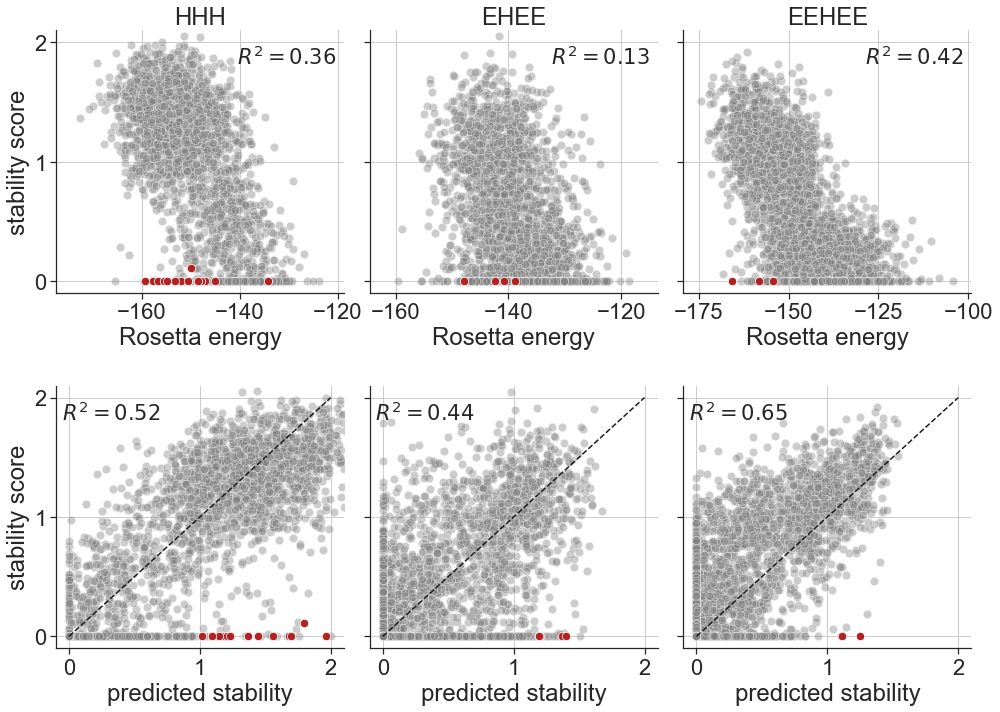

In [19]:
topologies = ['HHH', 'EHEE', 'EEHEE']
marker_size = 70
(fig, axs) = plt.subplots(
    ncols=3, nrows=2, sharey=True, figsize=[14,10]
)
axs = axs.reshape(-1)
for (i, topology) in enumerate(topologies):
    
    # Plot correlation between Rosetta energy and stability score
    data_i = scores_df[scores_df['topology'] == topology]
    (r, p) = scipy.stats.pearsonr(
        data_i['total_score'], data_i['stabilityscore']
    )
    r2 = r**2
    axs[i].text(
        0.63, 0.87, f'$R^2 = {round(r2, 2)}$',
        transform=axs[i].transAxes, fontsize=21
    )
    sns.scatterplot(
        x='total_score', y='stabilityscore', data=data_i,
        color='0.5', alpha=0.4, ax=axs[i], s=marker_size
    )
    if True:
        data_h = data_i[data_i.index.isin(pdbs_to_highlight)]
        sns.scatterplot(
            x='total_score', y='stabilityscore', data=data_h,
            color='firebrick', ax=axs[i], s=marker_size
        )
    min_e = data_i['total_score'].min() - 5
    max_e = data_i['total_score'].max() + 5
    axs[i].set(
        xlabel='Rosetta energy', xlim=[min_e, max_e], # [max_e, min_e],
        yticks=[0, 1, 2], ylim=[-0.1, 2.1],
        ylabel='stability score', title=topology
    )
    
    # Plot correlation between ML prediction and stability score
    (r, p) = scipy.stats.pearsonr(
        data_i['stability_pred'], data_i['stabilityscore']
    )
    r2 = r**2
    axs[i+3].text(
        0.02, 0.87, f'$R^2 = {round(r2, 2)}$',
        transform=axs[i+3].transAxes, fontsize=21
    )
    sns.scatterplot(
        x='stability_pred', y='stabilityscore', data=data_i,
        color='0.5', alpha=0.4, ax=axs[i+3], s=marker_size
    )
    (min_val, max_val) = (0, 2)
    axs[i+3].plot([min_val, max_val], [min_val, max_val], ls='--', c='k')
    if True:
        sns.scatterplot(
            x='stability_pred', y='stabilityscore', data=data_h,
            color='firebrick', ax=axs[i+3], s=marker_size
        )
    axs[i+3].set(
        xticks=[0, 1, 2], xlim=[-0.1, 2.1],
        yticks=[0, 1, 2], ylim=[-0.1, 2.1],
        ylabel='stability score',
        xlabel='predicted stability'
    )
    axs[i].grid()
    axs[i+3].grid()

plt.tight_layout(w_pad=0, h_pad=3)
sns.despine()
plt.show()

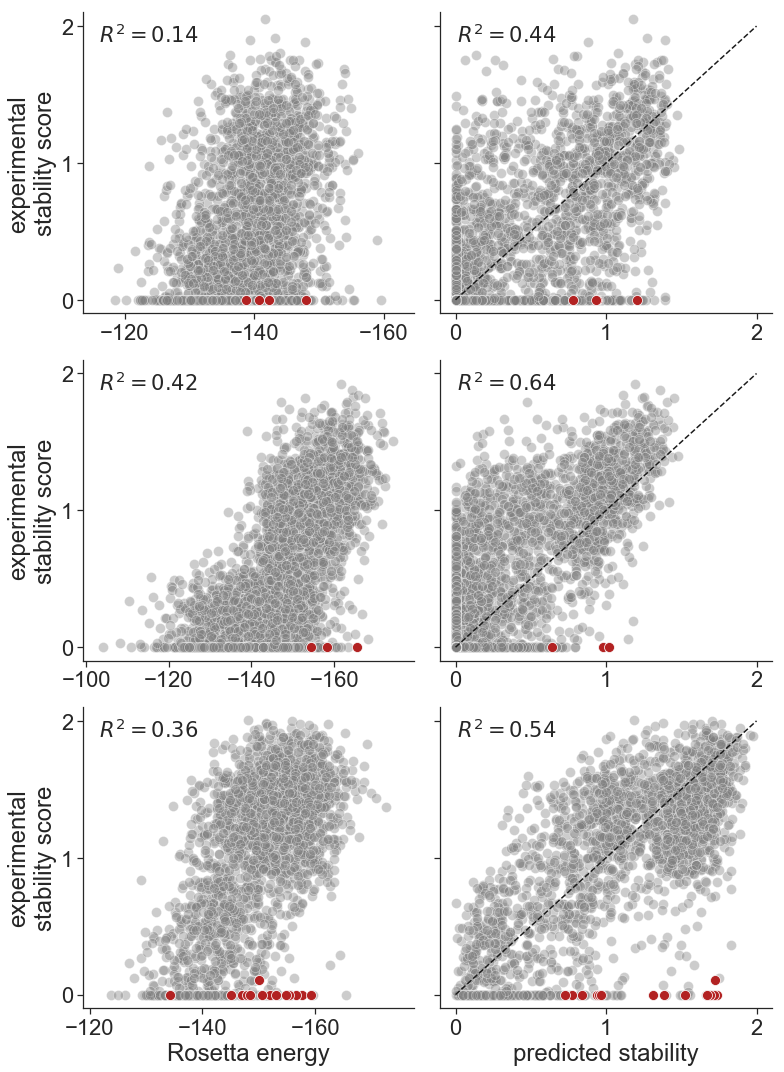

In [89]:
topologies = ['EHEE', 'EEHEE', 'HHH']
marker_size = 100
(fig, axs) = plt.subplots(
    ncols=2, nrows=3, sharey=True, figsize=[11,15]
)
axs = axs.reshape(-1)
for (i, topology) in enumerate(topologies):
    
    # Plot correlation between Rosetta energy and stability score
    data_i = scores_df[scores_df['topology'] == topology]
    (r, p) = scipy.stats.pearsonr(
        data_i['total_score'], data_i['stabilityscore']
    )
    r2 = r**2
    axs[i*2].text(
        0.05, 0.90, f'$R^2 = {round(r2, 2)}$',
        transform=axs[i*2].transAxes, fontsize=21
    )
    sns.scatterplot(
        x='total_score', y='stabilityscore', data=data_i,
        color='0.5', alpha=0.4, ax=axs[i*2], s=marker_size
    )
    if True:
        data_h = data_i[data_i.index.isin(pdbs_to_highlight)]
        sns.scatterplot(
            x='total_score', y='stabilityscore', data=data_h,
            color='firebrick', ax=axs[i*2], s=marker_size
        )
    min_e = data_i['total_score'].min() - 5
    max_e = data_i['total_score'].max() + 5
    axs[i*2].set(
        xlabel='', xlim=[max_e, min_e],
        yticks=[0, 1, 2], ylim=[-0.1, 2.1],
        ylabel='experimental\nstability score', #title=topology
    )
    
    # Plot correlation between ML prediction and stability score
    (r, p) = scipy.stats.pearsonr(
        data_i['stability_pred'], data_i['stabilityscore']
    )
    r2 = r**2
    axs[i*2+1].text(
        0.05, 0.90, f'$R^2 = {round(r2, 2)}$',
        transform=axs[i*2+1].transAxes, fontsize=21
    )
    sns.scatterplot(
        x='stability_pred', y='stabilityscore', data=data_i,
        color='0.5', alpha=0.4, ax=axs[i*2+1], s=marker_size
    )
    (min_val, max_val) = (0, 2)
    axs[i*2+1].plot(
        [min_val, max_val], [min_val, max_val], ls='--', c='k'
    )
    if True:
        sns.scatterplot(
            x='stability_pred', y='stabilityscore', data=data_h,
            color='firebrick', ax=axs[i*2+1], s=marker_size
        )
    axs[i*2+1].set(
        xticks=[0, 1, 2], xlim=[-0.1, 2.1],
        yticks=[0, 1, 2], ylim=[-0.1, 2.1],
        ylabel='',
        xlabel=''
    )

axs[4].set(xlabel='Rosetta energy')
axs[5].set(xlabel='predicted stability')
plt.tight_layout()
sns.despine()
plt.show()

## Read in experimental data from both replicates of the high-throughput stability assay

In [90]:
# Read in stability scores for the first replicate
stability_data_dir = 'results/experimental_stability_scores/'
stability_scores_df = pandas.read_csv(
    os.path.join(
        stability_data_dir,
        '200320_stability_scores_rep1.txt'
    ),
    sep='\t'
)
stability_scores_df.rename(
    columns={'name':'chip_name'}, inplace=True
)
stability_scores_df.set_index('chip_name', inplace=True)
stability_scores_df.rename(
    columns={
        col : f'{col}_rep1'
        for col in stability_scores_df.columns.values
    }, inplace=True
)

# Read in stability scores for the second repliate, and then
# merge with the first
df = pandas.read_csv(
    os.path.join(
        stability_data_dir,
        '200320_stability_scores_rep2.txt'
    ),
    sep='\t'
)
df.rename(columns={'name':'chip_name'}, inplace=True)
df.set_index('chip_name', inplace=True)
df.rename(
    columns={
        col : f'{col}_rep2'
        for col in df.columns.values
    }, inplace=True
)
stability_scores_df = stability_scores_df.merge(
    df, left_index=True, right_index=True, how='outer'
)
stability_scores_df['chip_id'] = 'big_chip'

# Add a column giving the minimum stability score between replicates
stability_scores_df['stabilityscore_min'] = stability_scores_df.apply(
    lambda row: min(
        row['stabilityscore_rep1'],
        row['stabilityscore_rep2']
    ),
    axis=1
)
stability_scores_df['stabilityscore_avg'] = stability_scores_df.apply(
    lambda row: np.mean([
        row['stabilityscore_rep1'],
        row['stabilityscore_rep2']
    ]),
    axis=1
)

# Add in columns giving metadata
df = pandas.read_csv(os.path.join(
    'results/generate_ssm_of_unstable_proteins/',
    'all_starting_names_and_protein_sequences.csv'
))
df.set_index('chip_name', inplace=True)
stability_scores_df = stability_scores_df.merge(
    df, left_index=True, right_index=True
)

# Add columns identifying whether designs are in the ladder
stability_scores_df['ladder'] = stability_scores_df.apply(
    lambda row: 'ladder' in row.name, axis=1
)

# Write the combined data to an output file
stability_scores_df.to_csv(
    'results/experimental_stability_scores/dms_data_library_1.csv', index=True
)

# Add data from third experiment with two other outlier designs
df = pandas.read_csv(os.path.join(
    'results/experimental_stability_scores/',
    '191020_SSM_rescue_stabilityscore.csv'
))
df['chip_id'] = 'small_chip'
df['parent_name'] = df['cat']
df['original_name'] = df['name']
df['chip_name'] = df['name']
df.set_index('chip_name', inplace=True, verify_integrity=True)

df['mutation'] = df['original_name'].str.extract(r"\S+.pdb_(\w\d+\w)")
df['name'] = df.apply(
    lambda row: \
        '{0}_{1}'.format(
        row['parent_name'], row['mutation']
    ) if pandas.notnull(row['mutation']) \
        else '{0}_wt'.format(row['parent_name']),
    axis=1
)
df['wt_aa'] = df['mutation'].str.extract(r'(\w)\d+\w')
df['site_n'] = df['mutation'].str.extract(r'\w(\d+)\w')
df['mut_aa'] = df['mutation'].str.extract(r'\w\d+(\w)')
df['group'] = 'SSM'
df.to_csv(
    'results/experimental_stability_scores/dms_data_library_2.csv', index=True
)
df['stabilityscore_avg'] = df['stabilityscore']
outlier_designs_small_chip = list(set(df['parent_name']))
stability_scores_df = pandas.concat(
    [stability_scores_df, df],
    sort=False
)

## Analyze EC50 values and stability scores for the ~400 sequences that we tested from Rocklin et al., 2017, *Science*, seeing how these values have changed with the new display vector

Read in data for ladder sequences from past experiments. Then, merge with data from the current experiment.

In [91]:
# Read in sequences and data from past experiments for
# the ladder
ladder_files_dir = 'data/ladder_sequences/'
ladder_files = [
    'ladder_sequences.csv',
    'ladder_sequences_10_bins_15_samples_per_bin.csv'
]
dfs = []
for (i, f) in enumerate(ladder_files):
    df = pandas.read_csv(os.path.join(ladder_files_dir, f))
    df['ladder_file_index'] = i
    dfs.append(df)

ladder_df = pandas.concat(dfs)

# Select all sequences from `Rocklin_2017_Science`
ladder_df = ladder_df[
    (ladder_df['library_name'] == 'Rocklin_2017_Science')
]
ladder_df.drop_duplicates(subset=['sequence'], inplace=True)

# Add a column with the name of each ladder sequence in context
# of this experiment (the column called "chip_name" in the above
# dataframe is incorrect), getting correct names from another
# dataframe that I read in below.
ladder_df.drop(columns=['chip_name'], inplace=True)
ladder_df.rename(columns={'sequence':'protein_sequence'}, inplace=True)
df = pandas.read_csv(
    'results/generate_ssm_of_unstable_proteins/all_starting_names_and_protein_sequences.csv'
)
df = df[df['chip_name'].apply(lambda x: 'ladder' in x)]
ladder_df = ladder_df.merge(
    df[['chip_name', 'protein_sequence']], left_on='protein_sequence',
    right_on='protein_sequence', validate='1:1', how='left'
)
ladder_df.set_index('chip_name', inplace=True)
print("Read in {0} ladder sequences from Rocklin et al.".format(
    len(ladder_df)
))

# Change columns with experimental data to indicate they
# are from past experiments
ladder_df = ladder_df[[
    'protein_sequence', 'library_name', 'ec50_t', 'ec50_c',
]]
ladder_df.rename(columns={
    'ec50_t' : 'original_ec50_t',
    'ec50_c' : 'original_ec50_c',
}, inplace=True)

# Add data from the current experiment and remove sequences
# without data
ladder_df = ladder_df.merge(
    stability_scores_df, left_index=True, right_index=True,
    validate='1:1', how='left'
)
ladder_df.dropna(
    subset=['ec50_t_rep1','ec50_c_rep1'], inplace=True
)
print("{0} of which have data for both proteases/experiments".format(
    len(ladder_df)
))

# Add data for outlier designs
outlier_designs = [
    'EEHEE_rd3_1267', 'EEHEE_rd4_0215', 'EEHEE_rd4_0464',
    'EHEE_rd4_0144', 'EHEE_rd4_0152', 'EHEE_rd4_0570',
    'EHEE_rd4_0810', 'HHH_rd1_0192', 'HHH_rd1_0501', 'HHH_rd1_0649',
    'HHH_rd1_0972', 'HHH_rd2_0120', 'HHH_rd2_0184', 'HHH_rd4_0068',
    'HHH_rd4_0216', 'HHH_rd4_0284', 'HHH_rd4_0628', 'HHH_rd4_0636',
    'HHH_rd4_0821', 'HHH_rd4_0838', 'HHH_rd4_0998'
]
fs = glob.glob(os.path.join(
    '/home/haddox/Rocklin_2017_supp_info/aan0693_SI_datasets/',
    'rd*_stability_scores'
))
dfs = []
for f in fs:
    df = pandas.read_csv(f, sep='\s+')
    dfs.append(df)
rocklin_data = pandas.concat(dfs, sort=False)
rocklin_data['name'] = rocklin_data['name'].apply(
    lambda x: x.replace('.pdb', '_wt')
)
rocklin_data.rename(columns={
    'ec50_t' : 'original_ec50_t',
    'ec50_c' : 'original_ec50_c',
    'ec50_pred_t' : 'original_ec50_pred_t',
    'ec50_pred_c' : 'original_ec50_pred_c',
    'stabilityscore_t' : 'original_stabilityscore_t',
    'stabilityscore_c' : 'original_stabilityscore_c',
}, inplace=True)
cols_to_merge = [
    'name',
    'original_ec50_t', 'original_ec50_c',
    'original_ec50_pred_t', 'original_ec50_pred_c',
    'original_stabilityscore_t', 'original_stabilityscore_c'
]
rocklin_outlier_data = rocklin_data[cols_to_merge].merge(
    stability_scores_df, on='name', how='inner'
)

# A few of the outlier designs were measured in a different
# experiment and do not have replicate data
#rocklin_outlier_data.dropna(subset=['ec50_t_rep1','ec50_c_rep1'], inplace=True)
rocklin_outlier_data.drop_duplicates(subset='name', keep='first', inplace=True)
rocklin_outlier_data['outlier'] = True
print(f"Adding data for {len(rocklin_outlier_data)} outlier designs")

ladder_df = pandas.concat([ladder_df, rocklin_outlier_data], sort=False)
ladder_df.dropna(
    subset=['ec50_t_rep1','ec50_c_rep1'], inplace=True
)

Read in 338 ladder sequences from Rocklin et al.
336 of which have data for both proteases/experiments
Adding data for 21 outlier designs


Plot the correlation in EC50 values between Rocklin et al. and the present experiment for all ladder sequences.

For each plot...
Black dashed line: y=x
Green line: ODR line computed using all data
Purple line: ODR line computed using all proteins with EC50 values < 4 in both experiments for a given protease

Showing data for replicate 1


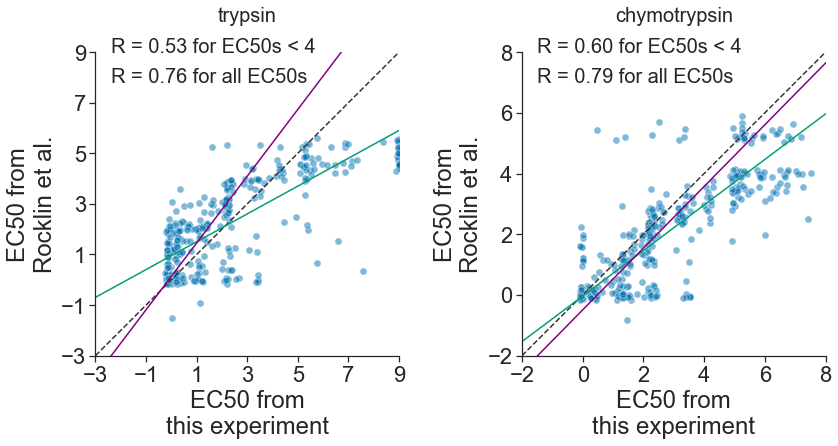


Showing data for replicate 2


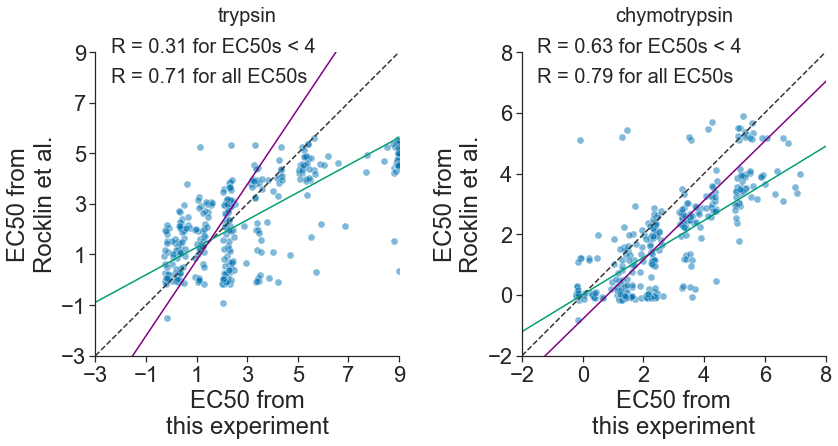

In [92]:
def f_line(B, x):
    """
    Linear function y = m*x + b
    
    Args:
        `B`: a vector of the parameters
        `x`: an array of x values
        
    Returns:
        An array of y values
    """
    return B[0]*x + B[1]

def perform_orthogonal_distance_regression(x, y):
    """
    Perform orthogonal distance regression
    
    ...as described here: https://docs.scipy.org/doc/scipy/reference/odr.html
    where initial estimates for the beta vector are a slope of one and a
    y intercept of zero.
    
    Args:
        `x`: an array of x variables
        `y`: an array of y variables ordered in a way that matches x
    """
    linear = scipy.odr.Model(f_line)
    mydata = scipy.odr.Data(x=x, y=y)
    myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 0.])
    myoutput = myodr.run()
    return myoutput

# Make the plot
EC50_truncation_cutoff = 4
print("For each plot...")
print("Black dashed line: y=x")
print("Green line: ODR line computed using all data")
print("Purple line: ODR line computed using all proteins with EC50 values < {0} in both experiments for a given protease".format(EC50_truncation_cutoff))

for rep in [1, 2]:
    print(f"\nShowing data for replicate {rep}")
    (fig, axs) = plt.subplots(ncols=2, figsize=[12,6])
    protease_dict = {'t':'trypsin', 'c':'chymotrypsin'}
    for (i, protease) in enumerate(['t', 'c']):

        # Make a scatter plot of EC50 values
        x = 'ec50_{0}_rep{1}'.format(protease, rep)
        y = 'original_ec50_{0}'.format(protease)
        data = ladder_df[
            (ladder_df[x].notnull()) & (ladder_df[y].notnull())
        ].copy()
        sns.scatterplot(
            x=x, y=y, data=data, alpha=0.5, s=50, ax=axs[i]
        )
        range_min = math.floor(data[[x,y]].min().min()) - 1
        range_max = math.ceil(data[[x,y]].max().max()) + 1
        ticks = list(range(range_min, range_max, 2))
        axs[i].set(
            xticks=ticks, yticks=ticks, xlim=[np.min(ticks), np.max(ticks)],
            ylim=[np.min(ticks), np.max(ticks)], aspect='equal',
            xlabel='EC50 from\nthis experiment',
            ylabel='EC50 from\nRocklin et al.'
        )

        # Plot a black, dashed y=x line
        axs[i].plot(
            [range_min, range_max], [range_min, range_max], c=".2",
            ls="--"
        )

        # Plot a green line giving the ODR line computed using all the
        # data
        myoutput = perform_orthogonal_distance_regression(
            data[x],
            data[y]
        )
        (slope, y_int) = myoutput.beta
        f_range_min = (slope * range_min) + y_int
        f_range_max = (slope * range_max) + y_int
        axs[i].plot(
            [range_min, range_max], [f_range_min, f_range_max], c="g"
        )
        r, _ = scipy.stats.pearsonr(data[x], data[y])
        axs[i].annotate(
            "R = {:.2f} for all EC50s".format(r),
            xy=(.05, .9), xycoords=axs[i].transAxes, fontsize=20
        )

        # Then, plot a purple line giving the ODR line computed using
        # just the data where both EC50 values are below a given cutoff
        truncated_data = data[
            (data[x]<EC50_truncation_cutoff) &
            (data[y]<EC50_truncation_cutoff)
        ].copy()
        myoutput = perform_orthogonal_distance_regression(
            truncated_data[x], truncated_data[y]
        )
        (slope, y_int) = myoutput.beta
        f_range_min = (slope * range_min) + y_int
        f_range_max = (slope * range_max) + y_int
        axs[i].plot(
            [range_min, range_max], [f_range_min, f_range_max], c="purple"
        )    
        r, _ = scipy.stats.pearsonr(truncated_data[x], truncated_data[y])
        axs[i].annotate(
            "R = {:.2f} for EC50s < {}".format(r, EC50_truncation_cutoff),
            xy=(.05, 1.0), xycoords=axs[i].transAxes, fontsize=20
        )

        # Add title
        axs[i].text(
            0.5, 1.1, protease_dict[protease], fontsize=20,
            horizontalalignment='center', transform = axs[i].transAxes
        )

    sns.despine()
    plt.tight_layout()
    plt.show()

**Observations**: 

***

The above results show that the new vector has increased the dynamic range of EC50 values that are measurable in the assay. How does this change influence the stability scores that are inferred from EC50 values? 

In the below cell, for each ladder sequence, I recompute stability scores from EC50 values from both old and new experiments (the above dataframe only has stability scores for sequences from the new experiment). Then, I plot the correlation in stability scores between experiments.


#-----------------------------------
Data for replicate 1
For each plot...
Black dashed line: y=x
Green line: ODR line computed using all data
Purple line: ODR line computed using all proteins with stability scores < 1.0 in both experiments for a given protease
Truncating the axes at -2,4


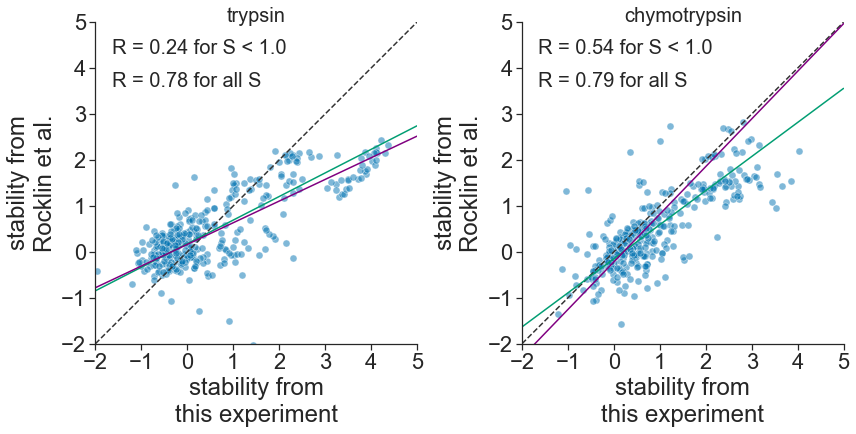


#-----------------------------------
Data for replicate 2
For each plot...
Black dashed line: y=x
Green line: ODR line computed using all data
Purple line: ODR line computed using all proteins with stability scores < 1.0 in both experiments for a given protease
Truncating the axes at -2,4


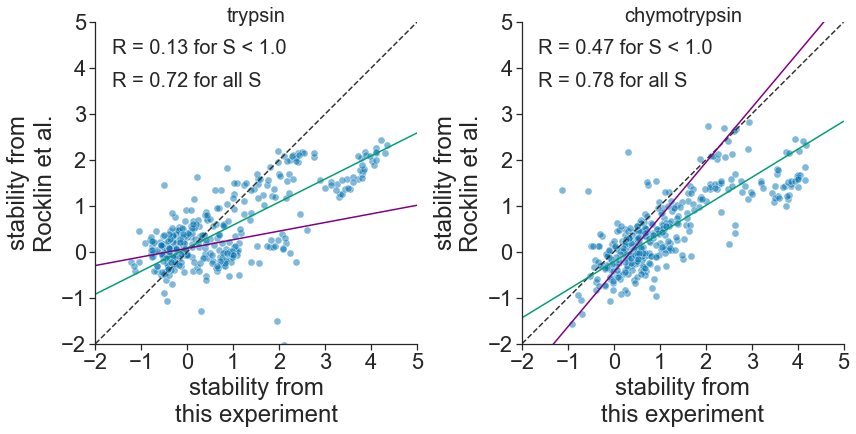

In [93]:
# For each protease, recompute stability scores for both the old
# and new experiments
for rep in [1, 2]:
    print("\n#-----------------------------------")
    print(f"Data for replicate {rep}")
    for p in ['t', 'c']:
        ladder_df['stabilityscore_{0}2_rep{1}'.format(p, rep)] = \
            ladder_df.apply(
                lambda row: np.log10(math.pow(
                    3, (row['ec50_{0}_rep{1}'.format(p, rep)] - \
                            row['ec50_pred_{0}_rep{1}'.format(p, rep)])
                )), axis=1
            )
        ladder_df['original_stabilityscore_{0}2'.format(p)] = \
            ladder_df.apply(
                lambda row: np.log10(math.pow(
                    3, (row['original_ec50_{0}'.format(p)] - \
                            row['ec50_pred_{0}_rep{1}'.format(p, rep)])
                )), axis=1
        )

        # For data from the new experiment, make sure that the recomputed
        # stability scores are the same as the ones that were already in
        # the dataframe
        for (i, row) in ladder_df.iterrows():
            assert (
                row['stabilityscore_{0}_rep{1}'.format(p, rep)] - \
                row['stabilityscore_{0}2_rep{1}'.format(p, rep)]
            ) < 1e-4

    # Plot the correlation in stability scores between the old and
    # new experiments
    stabilityscore_truncation_cutoff = 1.0
    print("For each plot...")
    print("Black dashed line: y=x")
    print("Green line: ODR line computed using all data")
    print("Purple line: ODR line computed using all proteins with stability scores < {0} in both experiments for a given protease".format(stabilityscore_truncation_cutoff))

    (fig, axs) = plt.subplots(ncols=2, figsize=[12,6])
    print("Truncating the axes at -2,4")
    for (i, protease) in enumerate(['t', 'c']):

        # Make a scatter plot of EC50 values
        x = 'stabilityscore_{0}2_rep{1}'.format(protease, rep)
        y = 'original_stabilityscore_{0}2'.format(protease)
        data = ladder_df[
            (ladder_df[x].notnull()) & (ladder_df[y].notnull())
        ].copy()
        sns.scatterplot(
            x=x, y=y, data=data, alpha=0.5, s=50, ax=axs[i]
        )
        range_min = -2 #math.floor(data[[x,y]].min().min())
        range_max = 5 #math.ceil(data[[x,y]].max().max())
        ticks = list(range(range_min, range_max+1, 1))
        axs[i].set(
            xticks=ticks, yticks=ticks, xlim=[np.min(ticks), np.max(ticks)],
            ylim=[np.min(ticks), np.max(ticks)], aspect='equal',
            xlabel='stability from\nthis experiment',
            ylabel='stability from\nRocklin et al.'
        )

        # Plot a black, dashed y=x line
        axs[i].plot(
            [range_min, range_max], [range_min, range_max], c=".2",
            ls="--"
        )

        # Plot a green line giving the ODR line computed using all the
        # data
        myoutput = perform_orthogonal_distance_regression(
            data[x],
            data[y]
        )
        (slope, y_int) = myoutput.beta
        f_range_min = (slope * range_min) + y_int
        f_range_max = (slope * range_max) + y_int
        axs[i].plot(
            [range_min, range_max], [f_range_min, f_range_max], c="g"
        )
        (r, p) = scipy.stats.pearsonr(data[x], data[y])
        axs[i].annotate(
            "R = {:.2f} for all S".format(r),
            xy=(.05, .8), xycoords=axs[i].transAxes, fontsize=20
        )

        # Then, plot a purple line giving the ODR line computed using
        # just the data where both EC50 values are below a given cutoff
        truncated_data = data[
            (data[x]<stabilityscore_truncation_cutoff) &
            (data[y]<stabilityscore_truncation_cutoff)
        ].copy()
        myoutput = perform_orthogonal_distance_regression(
            truncated_data[x], truncated_data[y]
        )
        (slope, y_int) = myoutput.beta
        f_range_min = (slope * range_min) + y_int
        f_range_max = (slope * range_max) + y_int
        axs[i].plot(
            [range_min, range_max], [f_range_min, f_range_max], c="purple"
        )    
        r, _ = scipy.stats.pearsonr(truncated_data[x], truncated_data[y])
        axs[i].annotate(
            "R = {:.2f} for S < {}".format(
                r, stabilityscore_truncation_cutoff
            ),
            xy=(.05, 0.9), xycoords=axs[i].transAxes, fontsize=20
        )

        # Add title
        axs[i].text(
            0.5, 1.0, protease_dict[protease], fontsize=20,
            horizontalalignment='center', transform = axs[i].transAxes
        )

    sns.despine()
    plt.tight_layout()
    plt.show()

Plot correlation between Rocklin et al. and this experiment, reporting average stability score for this experiment

355
0.81 0.0


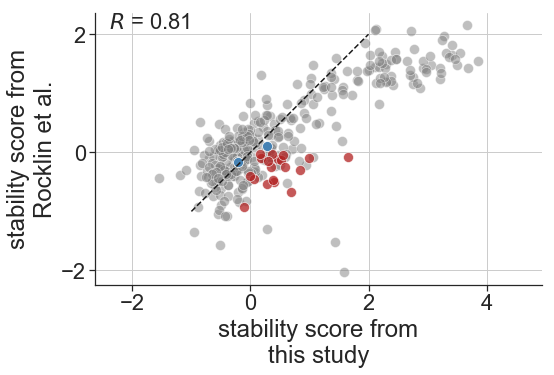

In [94]:
# Compute the original stability score as the minimum of the
# two proteases
ladder_df['original_stabilityscore'] = ladder_df[[
    'original_stabilityscore_t2',
    'original_stabilityscore_c2'
]].min(axis=1)
print(len(ladder_df))

# Plot the data
plt.figure(figsize=[8,5])
data = ladder_df[ladder_df['outlier'] != True]
sns.scatterplot(
    x='stabilityscore_avg', y='original_stabilityscore', data=data,
    s=100, alpha=0.5, color='0.5',
)
data = ladder_df[ladder_df['outlier'] == True]
sns.scatterplot(
    x='stabilityscore_avg', y='original_stabilityscore', data=data,
    s=100, alpha=0.75, color='firebrick'
)

# Plot the pearson R
data = ladder_df.copy()
x = 'stabilityscore_avg'
y = 'original_stabilityscore'
# for col in [x, y]:
#     data[col].clip(upper=2, inplace=True)
(r, p) = scipy.stats.pearsonr(data[x], data[y])
print(round(r, 2), round(p, 2))
plt.text(
    -2.4, 2.1, f'$R$ = {round(r, 2)}', fontsize=22,
)

# Plot data for two outlier designs from small chip
names = [f'{name}_wt' for name in outlier_designs_small_chip]
data = rocklin_outlier_data[
    rocklin_outlier_data['name'].isin(names)
].copy()
data['original_stabilityscore'] = data[[
    'original_stabilityscore_t', 'original_stabilityscore_c'
]].min(axis=1)
sns.scatterplot(
    x='stabilityscore_avg', y='original_stabilityscore', data=data,
    s=100, alpha=1.0, color='steelblue'
)

plt.plot([-1,2], [-1,2], ls='--', c='k')
plt.xlabel('stability score from\nthis study')
plt.ylabel('stability score from\nRocklin et al.')
plt.yticks([-2, 0, 2])
plt.grid()
plt.axis('equal')
sns.despine()
plt.show()

Plot the stability scores of each of the partent designs

21 14 7


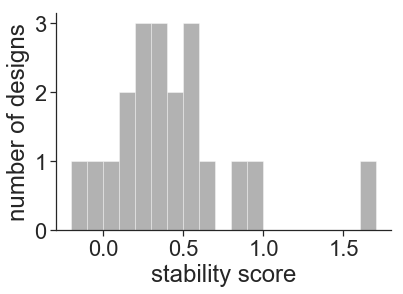

In [95]:
data = stability_scores_df[
    (~stability_scores_df['name'].isnull())
].copy()
data = data[data['name'].str.contains('wt')]
unstable_parents = list(set(data[data['stabilityscore_avg'] <= 0.5]['name']))
other_parents = [
    name for name in set(data['name'])
    if name not in unstable_parents
]
unstable_parents = [name.replace('_wt', '') for name in unstable_parents]
other_parents = [name.replace('_wt', '') for name in other_parents]

print(len(data), len(unstable_parents), len(other_parents))
bins = np.arange(-0.2, 1.8, 0.1)
sns.distplot(
    data['stabilityscore_avg'], kde=False, bins=bins,
    color='0.25'
)
plt.xlabel('stability score')
plt.ylabel('number of designs')
sns.despine()
plt.show()

In [12]:
data.sort_values('stabilityscore_avg', ascending=False)[[
    'name', 'stabilityscore_avg',
    'stabilityscore_rep1', 'stabilityscore_rep2',
]].head(n=5)

name  stabilityscore_avg  stabilityscore_rep1  \
chip_name                                                             
ssm_4650   HHH_rd4_0068_wt            1.658441             1.643665   
ssm_8525   HHH_rd1_0972_wt            0.992687             1.078261   
ssm_6200   HHH_rd1_0501_wt            0.843980             0.678888   
ssm_2325   HHH_rd4_0838_wt            0.679956             0.908864   
ssm_1550   HHH_rd4_0998_wt            0.577562             0.382087   

           stabilityscore_rep2  
chip_name                       
ssm_4650              1.673216  
ssm_8525              0.907113  
ssm_6200              1.009073  
ssm_2325              0.451048  
ssm_1550              0.773038

**Observations**
* DMS experiment suggests that the original design probably isn't stable, even though it had a high stability score from the experiment
    * HHH_rd4_0068, HHH_rd1_0972, HHH_rd1_0501

## Examine the correlation between proteases and replicates

stabilityscore_rep1 stabilityscore_rep2
16364 14840


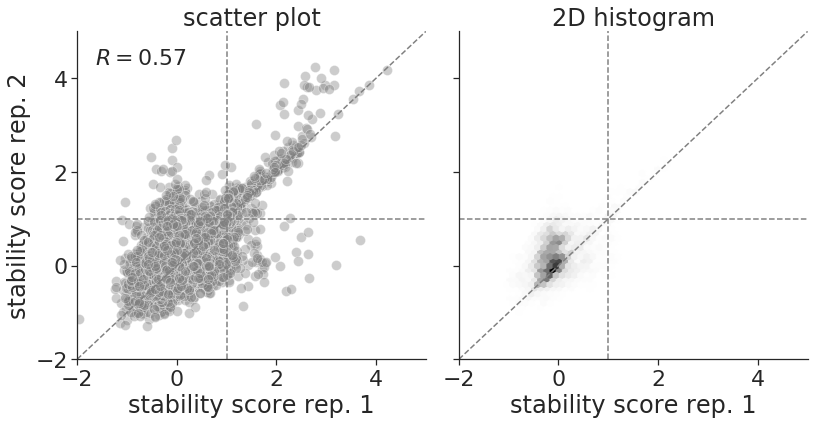

In [13]:
cols_to_plot = [
    ('stabilityscore_rep1', 'stabilityscore_rep2'),
    #('stabilityscore_t_rep1', 'stabilityscore_c_rep1'),
    #('stabilityscore_t_rep2', 'stabilityscore_c_rep2'),
    #('stabilityscore_t_rep1', 'stabilityscore_t_rep2'),
    #('stabilityscore_c_rep1', 'stabilityscore_c_rep2')
]
cols = []
for cols_i in cols_to_plot:
    cols += list(cols_i)
cols = set(cols)
min_val = math.floor(stability_scores_df[cols].min().min())
max_val = math.ceil(stability_scores_df[cols].max().max())
#ticks = list(range(min_val, max_val+1, 1))
ticks = [-2, 0, 2, 4]

for (x, y) in cols_to_plot:
    
    print(x, y)
    # Drop rows where one of the columns is nan
    data = stability_scores_df[
        (stability_scores_df[x].notnull()) &
        (stability_scores_df[y].notnull())
    ]
    print(len(stability_scores_df), len(data))
    
    # Compute the Pearson R
    xvals = data[x]
    yvals = data[y]
    (r, p) = scipy.stats.pearsonr(xvals, yvals)
    
    # Plot data
    (fig, axs) = plt.subplots(
        ncols=2, figsize=[11.5,6], sharey=True
    )
    sns.scatterplot(
        x=x, y=y, data=data, alpha=0.4, ax=axs[0], color='0.5',
        s=100
    )
    axs[0].set(
        xticks=ticks, yticks=ticks,
        xlim=[min_val, max_val], ylim=[min_val, max_val],
        xlabel='stability score rep. 1', ylabel='stability score rep. 2',
        title='scatter plot'
    )
    axs[0].plot([min_val, max_val], [min_val, max_val], c='0.5', ls='--')
    axs[0].plot([1,1], [min_val, max_val], c='0.5', ls='--')
    axs[0].plot([min_val, max_val], [1,1], c='0.5', ls='--')
    axs[0].text(
        0.05, 0.90, f'$R=${round(r, 2)}', transform=axs[0].transAxes,
        size=22
    )
    #axs[0].axis('equal')
    
    hb = axs[1].hexbin(
        x=xvals, y=yvals, cmap='Greys', gridsize=50
    )
    axs[1].set(
        ylabel='', xticks=ticks, yticks=ticks,
        xlim=[min_val, max_val], ylim=[min_val, max_val],
        xlabel='stability score rep. 1', title='2D histogram'
    )
    #cb = fig.colorbar(hb, ax=axs[1])
    #cb.set_label('counts')
    axs[1].plot([min_val, max_val], [min_val, max_val], c='0.5', ls='--')
    axs[1].plot([1,1], [min_val, max_val], c='0.5', ls='--')
    axs[1].plot([min_val, max_val], [1,1], c='0.5', ls='--')
    #axs[1].axis('equal')
    
    sns.despine()
    plt.tight_layout()
    plt.show()

Look at correlation between all replicates at once.

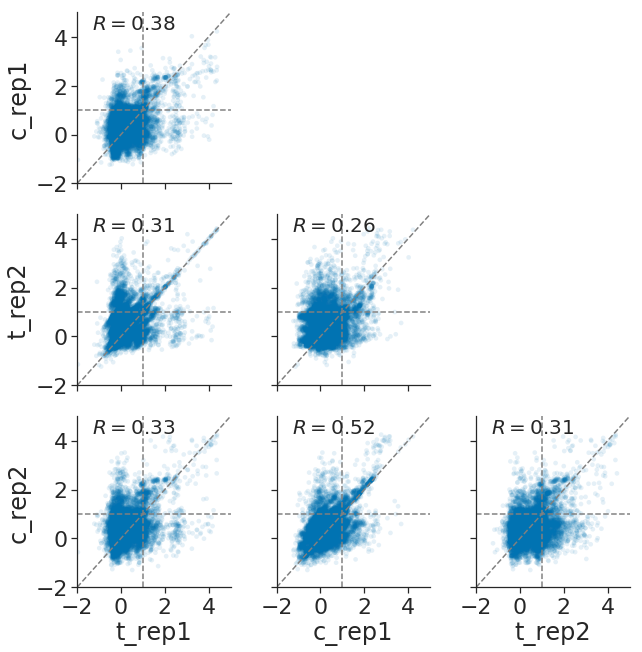

In [14]:
def add_lines(x, y, **kws):
    plt.plot([min_val, max_val], [min_val, max_val], c='0.5', ls='--')
    plt.plot([1,1], [min_val, max_val], c='0.5', ls='--')
    plt.plot([min_val, max_val], [1,1], c='0.5', ls='--')
    
def corrfunc(x, y, contour, **kws):
    ncontours=10
    
    r, _ = scipy.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        f"$R=${round(r, 2)}",
        xy=(.1, .9), xycoords=ax.transAxes, size=20
    )
    
    if contour:
        sns.kdeplot(x, y, shade=True, n_levels=ncontours)
    else:
        plt.scatter(
            x, y, s=22, alpha=0.1, marker='o', edgecolor='none',
            rasterized=True
        )

# Get data of interest
columns_to_plot = [
    'stabilityscore_t_rep1', 'stabilityscore_c_rep1',
    'stabilityscore_t_rep2', 'stabilityscore_c_rep2'
]
data = stability_scores_df.dropna(
    subset=columns_to_plot
)[columns_to_plot].copy()
data.rename(columns={
    col : col.replace('stabilityscore_', '')
    for col in columns_to_plot
}, inplace=True)

min_val = math.floor(data.min().min())
max_val = math.ceil(data.max().max())
ticks = list(range(min_val, max_val+1, 2))
p = sns.PairGrid(data, height=3)
p.set(
    xlim=[min_val,max_val], ylim=[min_val,max_val],
    xticks=ticks, yticks=ticks
)

# Hide the plots above the diagonal
for (i, j) in zip(*np.triu_indices_from(p.axes, 1)):
    p.axes[i, j].set_visible(False)
for (i, j) in zip(*np.diag_indices_from(p.axes)):
    p.axes[i, j].set_visible(False)

# Show correlation coefficients on plots
p.map_lower(corrfunc, contour=False)
p.map_lower(add_lines)

plt.show()

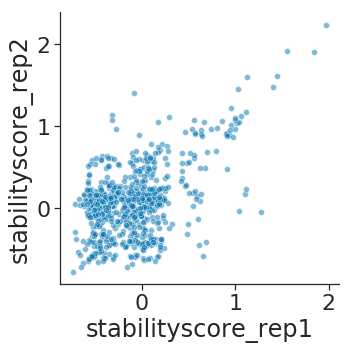

name  stabilityscore_avg  stabilityscore_rep1  \
chip_name                                                             
ssm_775    HHH_rd4_0216_wt            0.282697             0.067958   

           stabilityscore_rep2  
chip_name                       
ssm_775               0.497435

In [15]:
parent_name = 'HHH_rd4_0216' #'HHH_rd4_0068' #'HHH_rd2_0184' #
data = stability_scores_df[
    (stability_scores_df['parent_name'] == parent_name)
].copy()

plt.figure(figsize=[5,5])
sns.scatterplot(
    x='stabilityscore_rep1', y='stabilityscore_rep2',
    data=data, alpha=0.5
)
sns.despine()
plt.show()
data = stability_scores_df[
    (stability_scores_df['name'] == f'{parent_name}_wt')
].copy()
display(data[[
    'name', 'stabilityscore_avg', 'stabilityscore_rep1',
    'stabilityscore_rep2'
]])

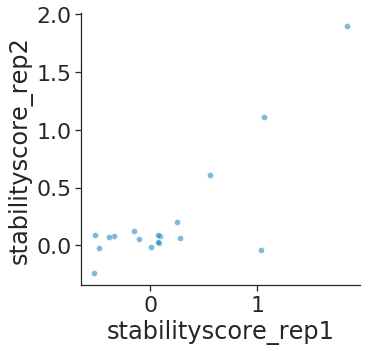

name  stabilityscore_avg  stabilityscore_rep1  \
chip_name                                                               
ssm_1136   HHH_rd4_0216_I21A            1.869965             1.839506   
ssm_1140   HHH_rd4_0216_I21G            1.090426             1.065063   
ssm_1138   HHH_rd4_0216_I21E            0.586299             0.561623   
ssm_1149   HHH_rd4_0216_I21S            0.499413             1.037962   
ssm_1148   HHH_rd4_0216_I21R            0.225030             0.249952   

           stabilityscore_rep2 mut_aa  
chip_name                              
ssm_1136              1.900423      A  
ssm_1140              1.115789      G  
ssm_1138              0.610976      E  
ssm_1149             -0.039136      S  
ssm_1148              0.200108      R

name  stabilityscore_avg  stabilityscore_rep1  \
chip_name                                                             
ssm_775    HHH_rd4_0216_wt            0.282697             0.067958   

           stabilityscore_rep2  
chip_name                       
ssm_775               0.497435

In [16]:
parent_name = 'HHH_rd4_0216' #'HHH_rd4_0068'
data = stability_scores_df[
    (stability_scores_df['parent_name'] == parent_name) &
    (stability_scores_df['site_n'] == 21)
].copy()

plt.figure(figsize=[5,5])
sns.scatterplot(
    x='stabilityscore_rep1', y='stabilityscore_rep2',
    data=data, alpha=0.5
)
sns.despine()
plt.show()

data.sort_values('stabilityscore_avg', ascending=False, inplace=True)
display(data[[
    'name', 'stabilityscore_avg', 'stabilityscore_rep1',
    'stabilityscore_rep2', 'mut_aa'
]].head())

data = stability_scores_df[
    (stability_scores_df['name'] == f'{parent_name}_wt')
].copy()
display(data[[
    'name', 'stabilityscore_avg', 'stabilityscore_rep1',
    'stabilityscore_rep2'
]])

In [17]:
# Compute the frequency of each variant in the library
data = stability_scores_df[
    ~stability_scores_df['name'].isnull()
].copy()
#design_str = 'HHH_rd4_0216'
#data = data[data['name'].str.contains(design_str)]

protease = 'c'
rep = 2
freq_cols = []
counts_cols = []
for sel_i in range(0, 7):
    counts_col = f'counts{sel_i}_{protease}_rep{rep}'
    counts_cols.append(counts_col)
    freq_col = f'freq{sel_i}_{protease}_rep{rep}'
    freq_cols.append(freq_col)
    #data[counts_col] += 1
    total_counts = data[counts_col].sum()
    print(sel_i, total_counts)
    data[freq_col] = data[counts_col] / total_counts

# Get data for design
design_str = 'HHH_rd4_0216'
data = data[data['name'].str.contains(design_str)]

# Compute enrichments
zero_col = f'freq0_{protease}_rep{rep}'
enrichment_cols = []
for sel_i in range(0, 7):
    freq_col = f'freq{sel_i}_{protease}_rep{rep}'
    if sel_i == 0:
        enrichment_col = 0.07 / 3
    else:
        enrichment_col = 0.07 * 3**(sel_i-1)
    data[enrichment_col] = data[freq_col] / data[zero_col]
    enrichment_cols.append(enrichment_col)
data = pandas.melt(
    data, id_vars=['name'], value_vars=enrichment_cols,
    value_name='enrichment', var_name='conc'
)
lower_lim_enrich = 0.01
print("Clipping enrichment data at:", lower_lim_enrich)
data['enrichment'] = data['enrichment'].clip(lower=lower_lim_enrich)

0 1060569.0
1 612861.0
2 1106109.0
3 343126.0
4 319652.0
5 324275.0
6 114123.0
Clipping enrichment data at: 0.01


In [18]:
data[
    data['name'].str.contains('HHH_rd4_0216_V11A')
].head()

name       conc  enrichment
731   HHH_rd4_0216_V11A  0.0233333    1.000000
1506  HHH_rd4_0216_V11A       0.07    2.430507
2281  HHH_rd4_0216_V11A       0.21    2.951899
3056  HHH_rd4_0216_V11A       0.63    2.465776
3831  HHH_rd4_0216_V11A       1.89    1.752142

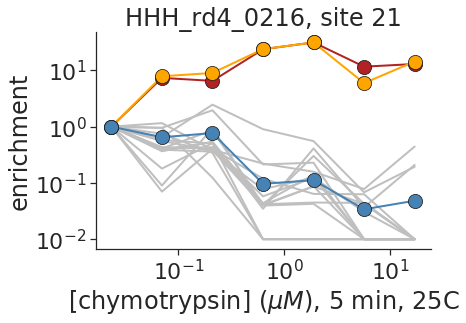

In [19]:
# Plot data for mutations at specific site
names = set(data[data['name'].str.contains('I21')]['name'])
for name in names:
    data_i = data[data['name'] == name]
    if ('A' in name):
        color = 'firebrick'
        scatter = True
    elif ('G' in name):
        color = 'orange'
        scatter = True
    else:
        color = '0.75'
        scatter = False
    sns.lineplot(x='conc', y='enrichment', data=data_i, color=color, linewidth=2)
    if scatter:
        sns.scatterplot(
            x='conc', y='enrichment', data=data_i, color=color,
            s=200, edgecolor='k', zorder=50
        )
        
# Plot data for wt
data_i = data[data['name'] == 'HHH_rd4_0216_wt']
sns.lineplot(x='conc', y='enrichment', data=data_i, color='steelblue', linewidth=2)
sns.scatterplot(
    x='conc', y='enrichment', data=data_i, color='steelblue',
    s=200, edgecolor='k', zorder=100
)

plt.xscale('log')
xticks = list(np.arange(0.1, 1.1, 0.1))
#plt.xticks(xticks)
plt.yscale('log')
plt.xlabel('[chymotrypsin] $(\mu M)$, 5 min, 25C')
plt.title('HHH_rd4_0216, site 21')
plt.minorticks_off()
sns.despine()
plt.show()

## Copy PDBs of interest into single directory

In [20]:
# Get data from the SSMs
data = stability_scores_df[
    (stability_scores_df['group'] == 'SSM')
].copy()
parent_names = sorted(list(set(data['parent_name'])))
pdb_dir = '/home/haddox/2018/score_monomeric_designs/data/Rocklin_2017_Science/'
pdbs = [
    os.path.join(pdb_dir, parent_name + '.pdb')
    for parent_name in parent_names
]
design_utils.copy_pdbs(pdbs=pdbs, new_pdb_dir='results/pdbs')

## Make plots showing the results of each SSM


#----------------------------
EEHEE_rd3_1267 0.5106371250091729


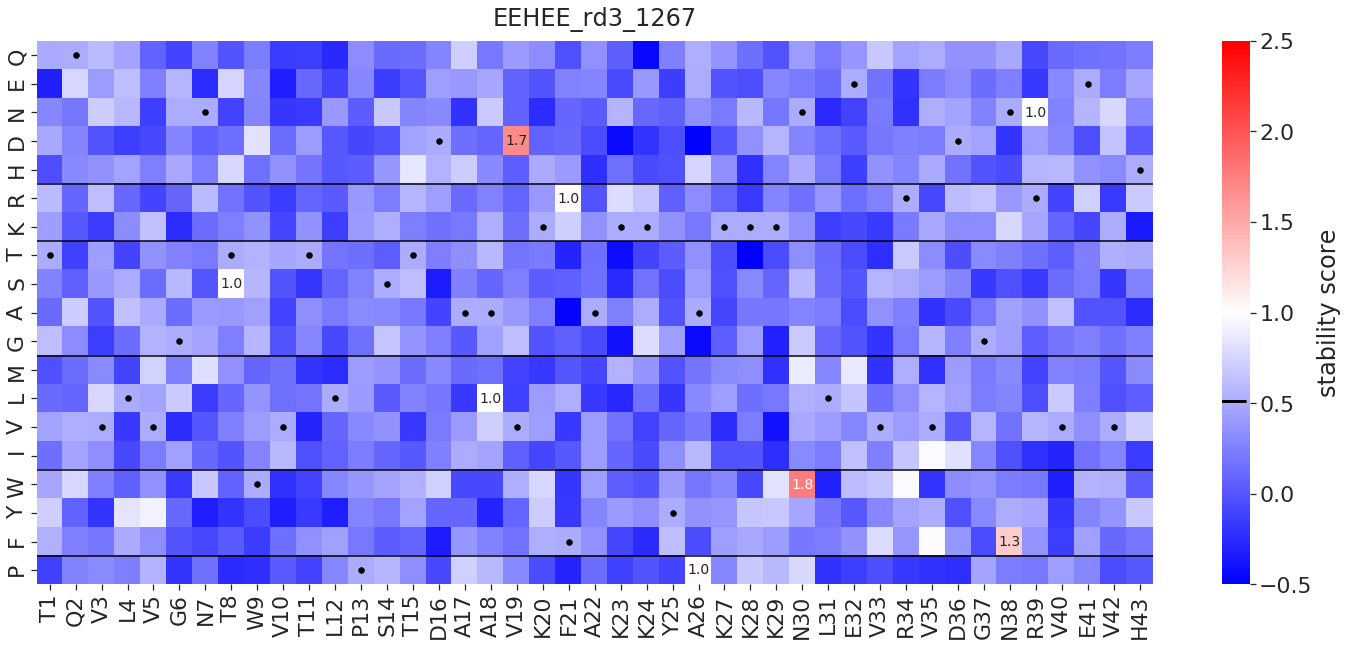


#----------------------------
EEHEE_rd4_0215 0.3550239149793033


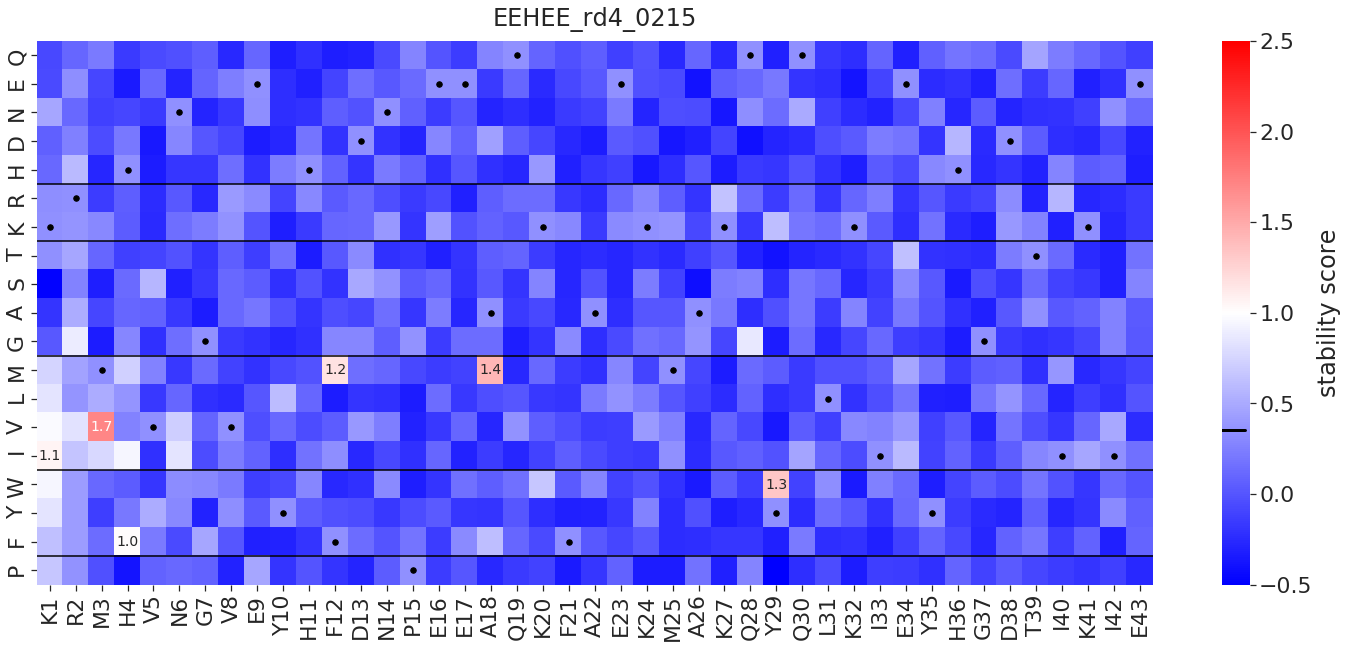


#----------------------------
EEHEE_rd4_0464 0.17754333492613605


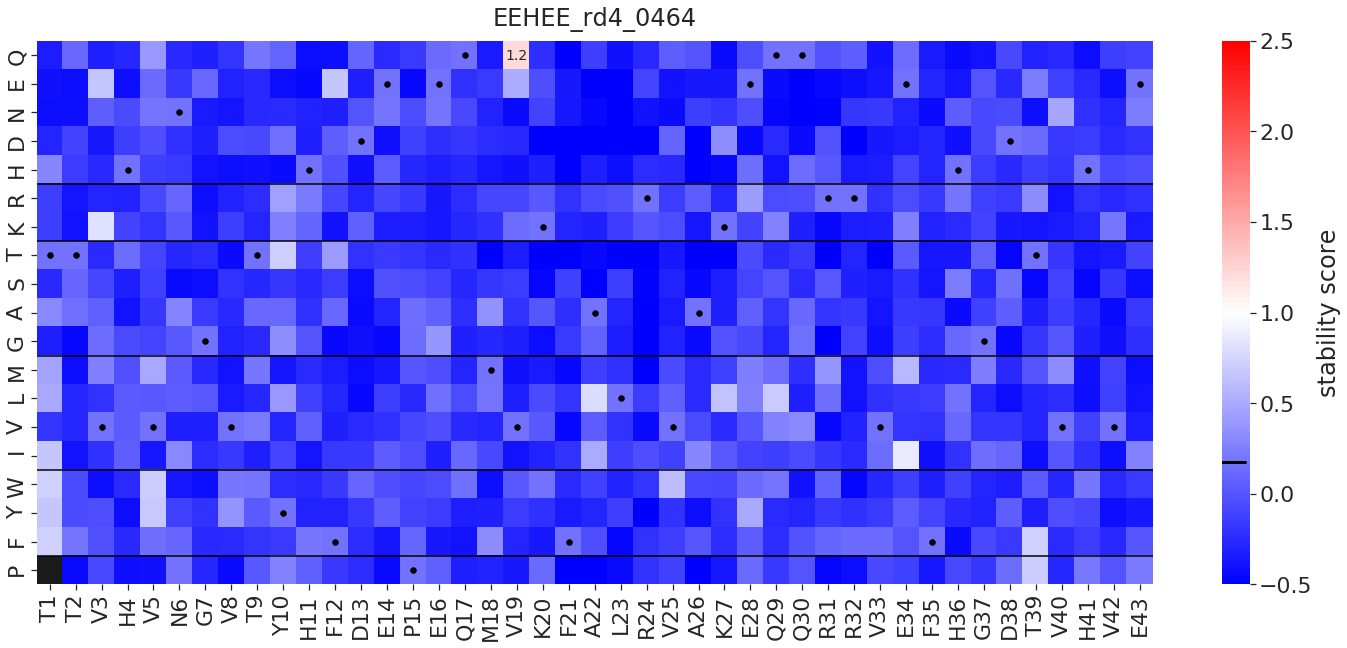


#----------------------------
EHEE_rd4_0144 0.3577832604998543


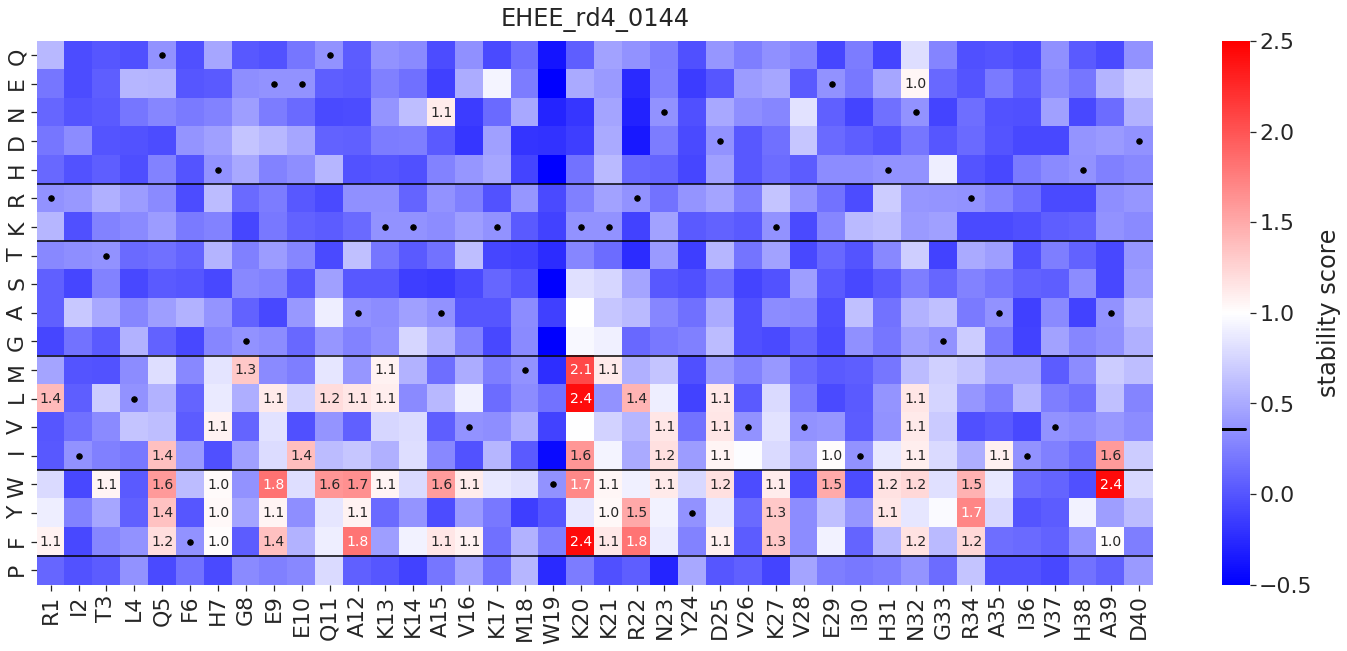


#----------------------------
EHEE_rd4_0152 0.1697382228011179


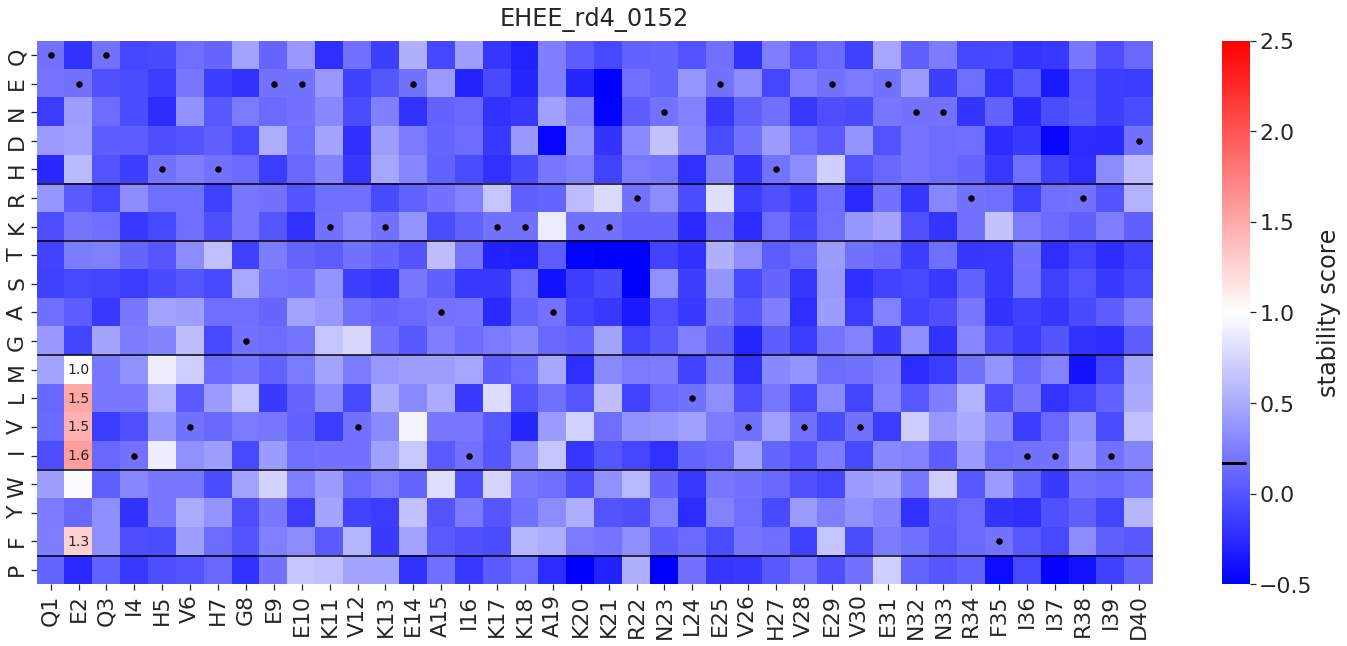


#----------------------------
EHEE_rd4_0570 -0.0118418506900001


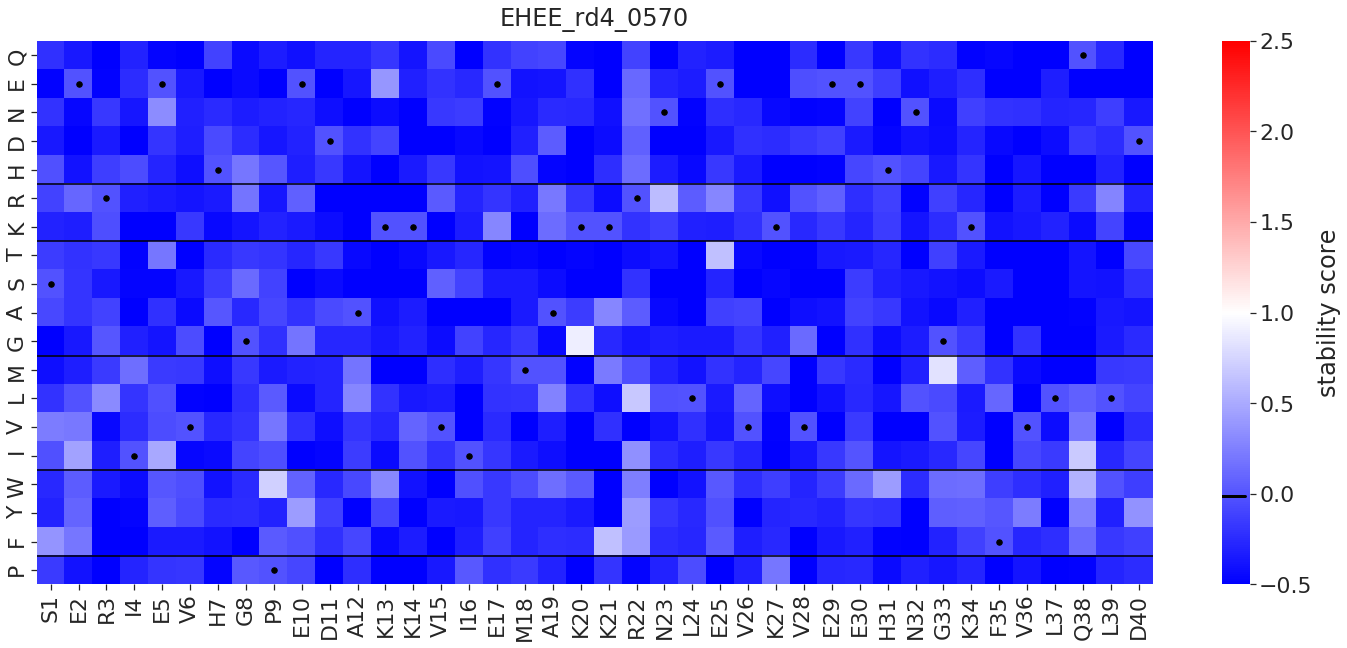


#----------------------------
EHEE_rd4_0810 0.5576993209611281


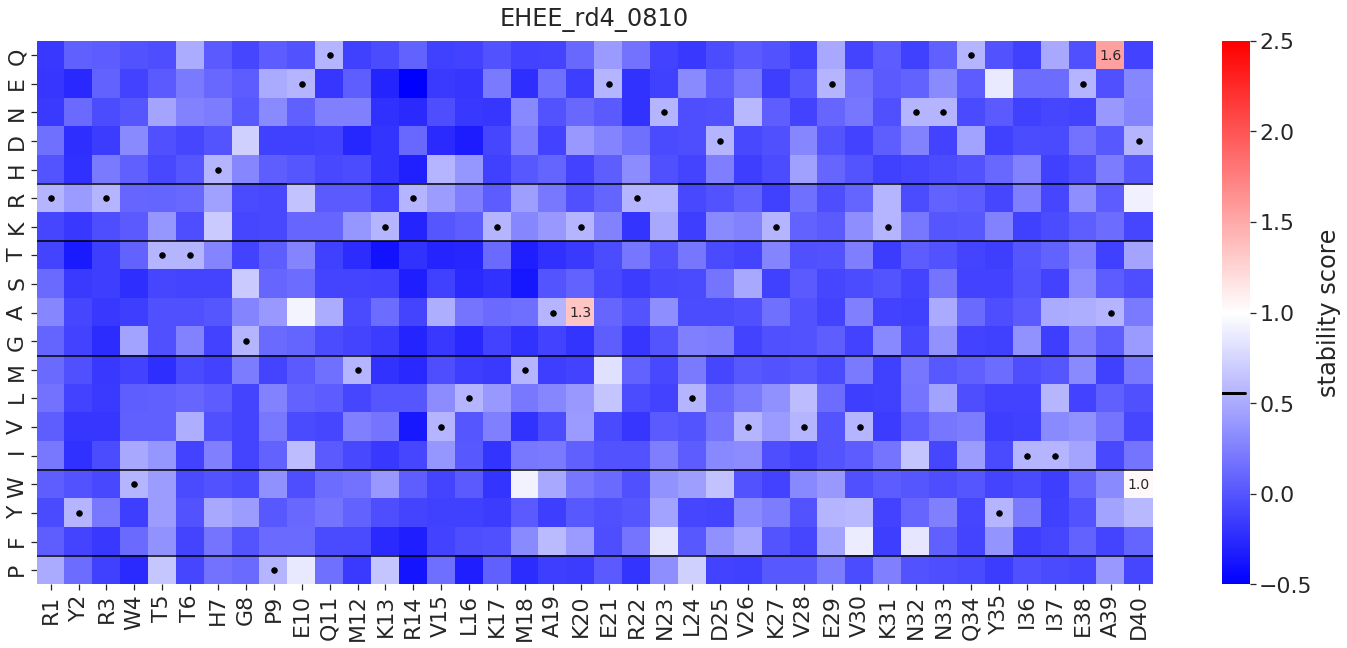


#----------------------------
HHH_rd1_0192 0.06340569279509972


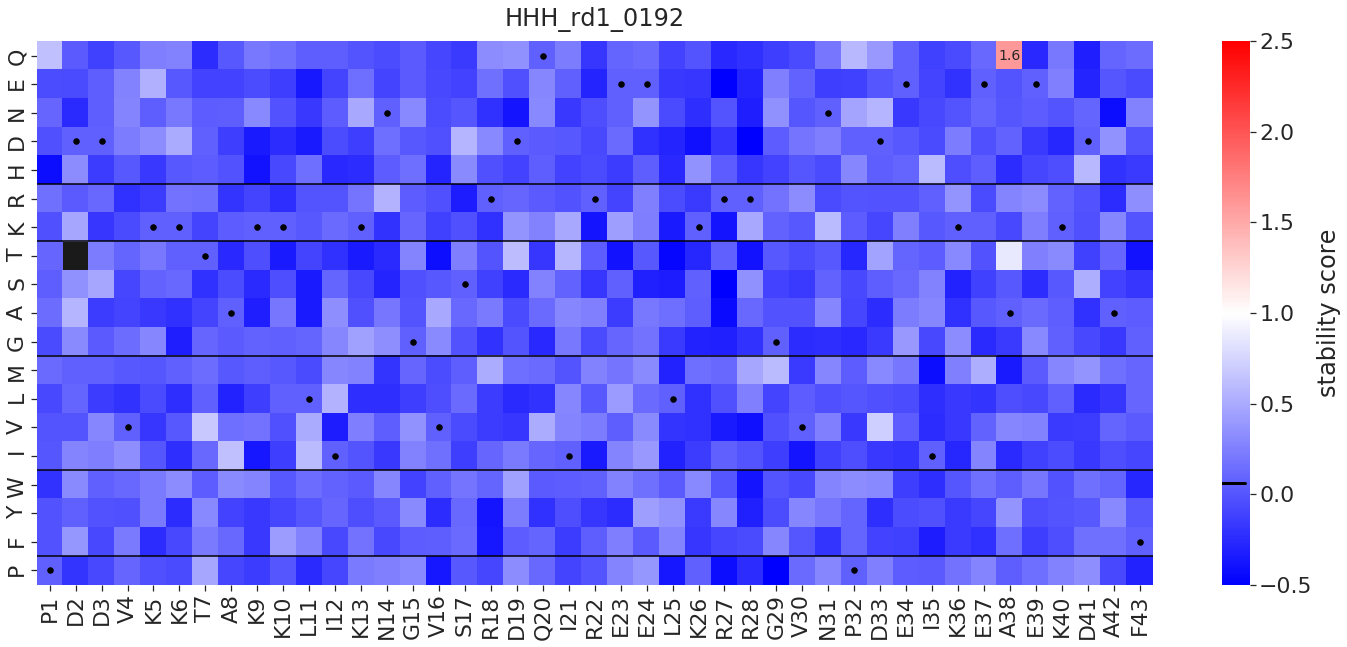


#----------------------------
HHH_rd1_0501 0.8439800090053045


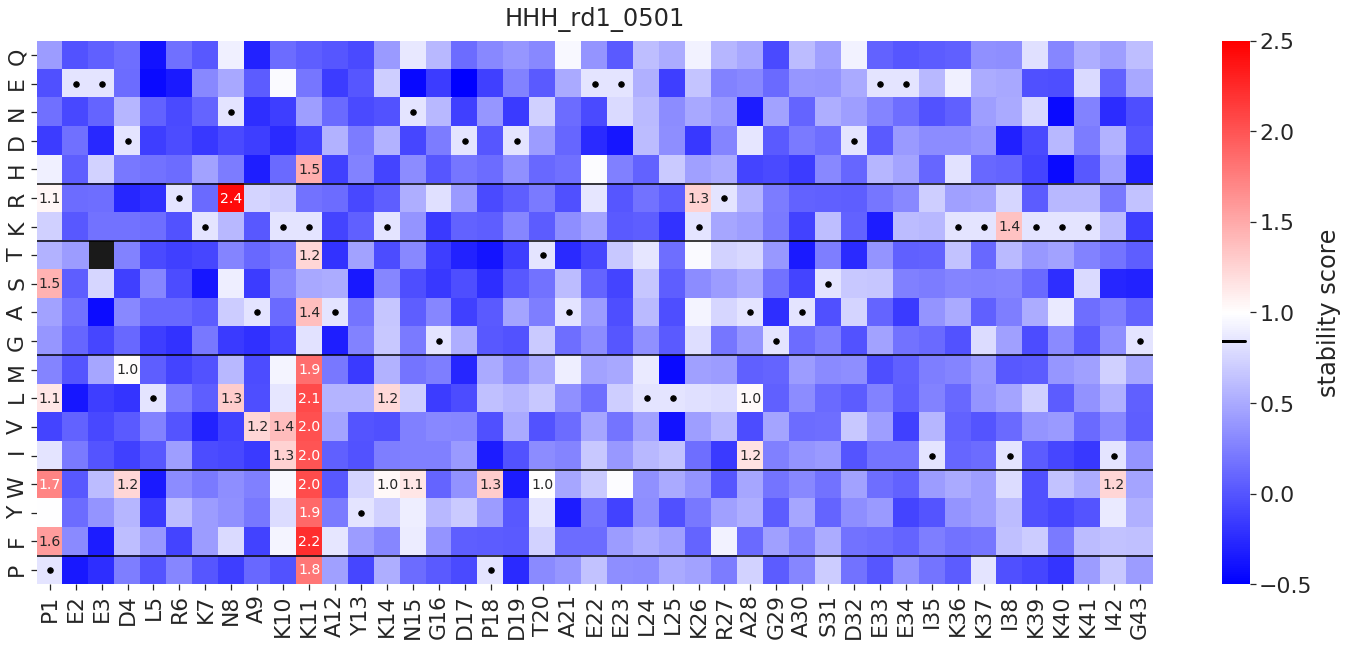


#----------------------------
HHH_rd1_0649 -0.1023672496306775


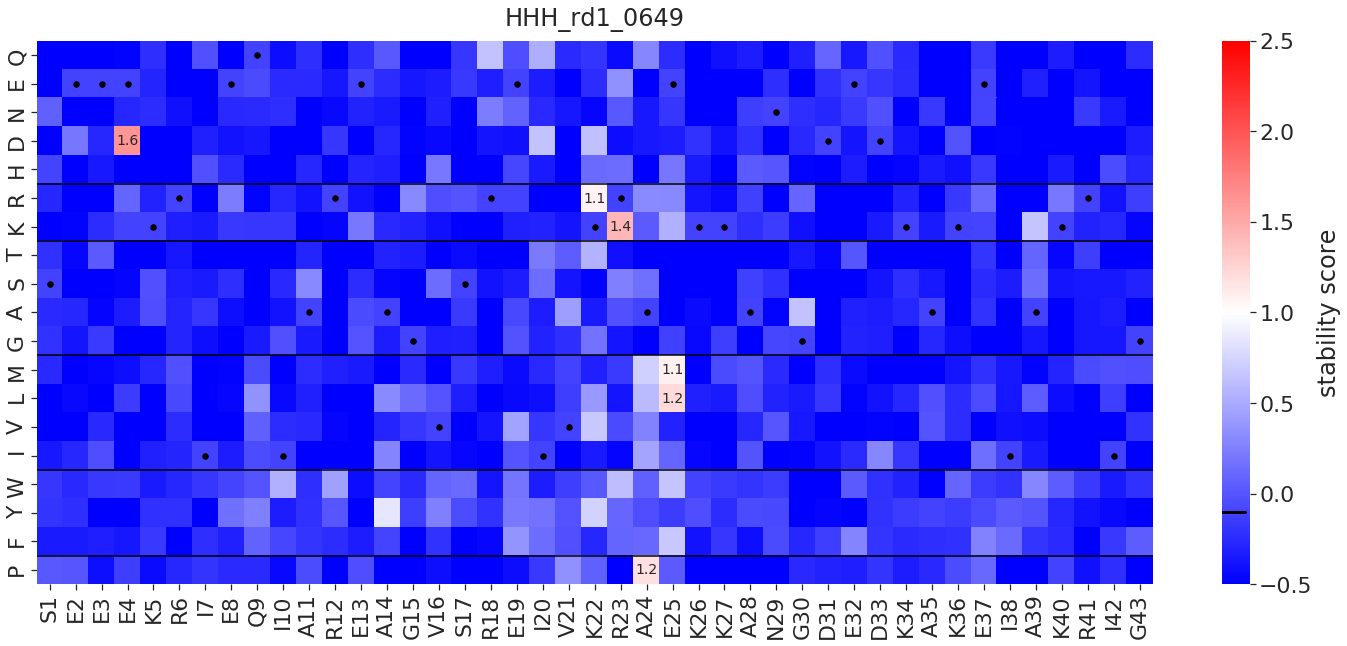


#----------------------------
HHH_rd1_0972 0.9926868062929857


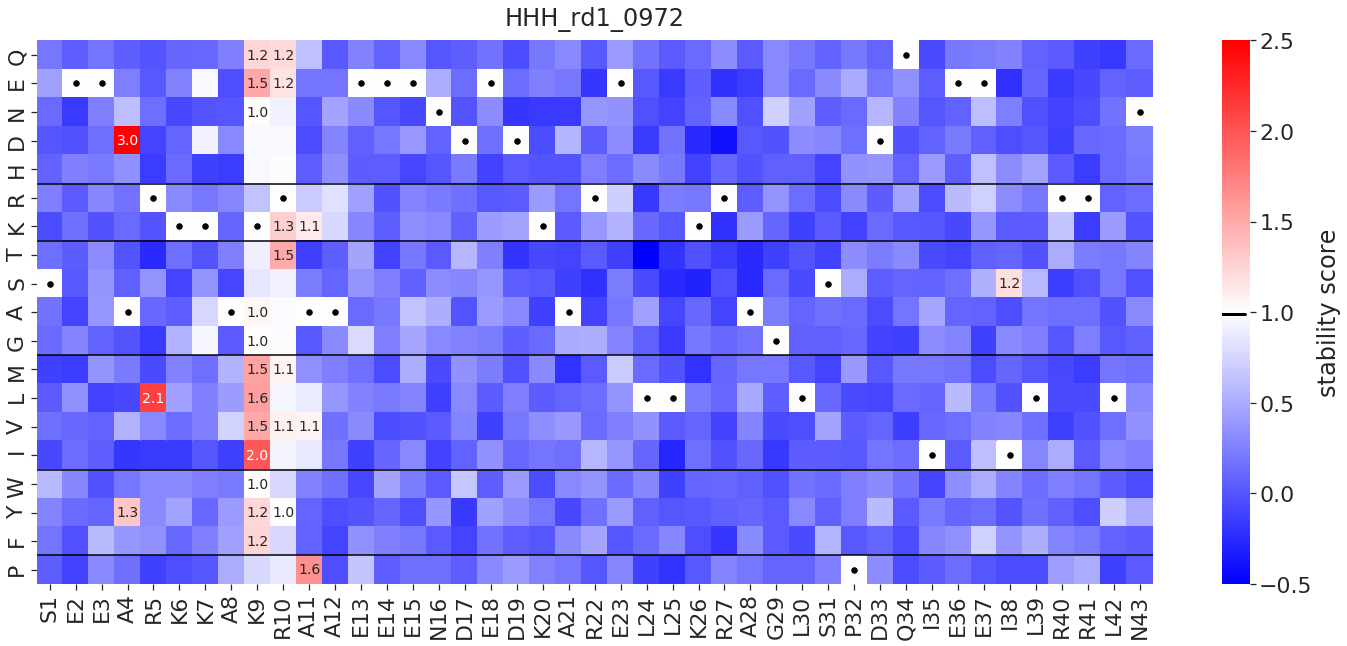


#----------------------------
HHH_rd2_0120 0.4009398756631125


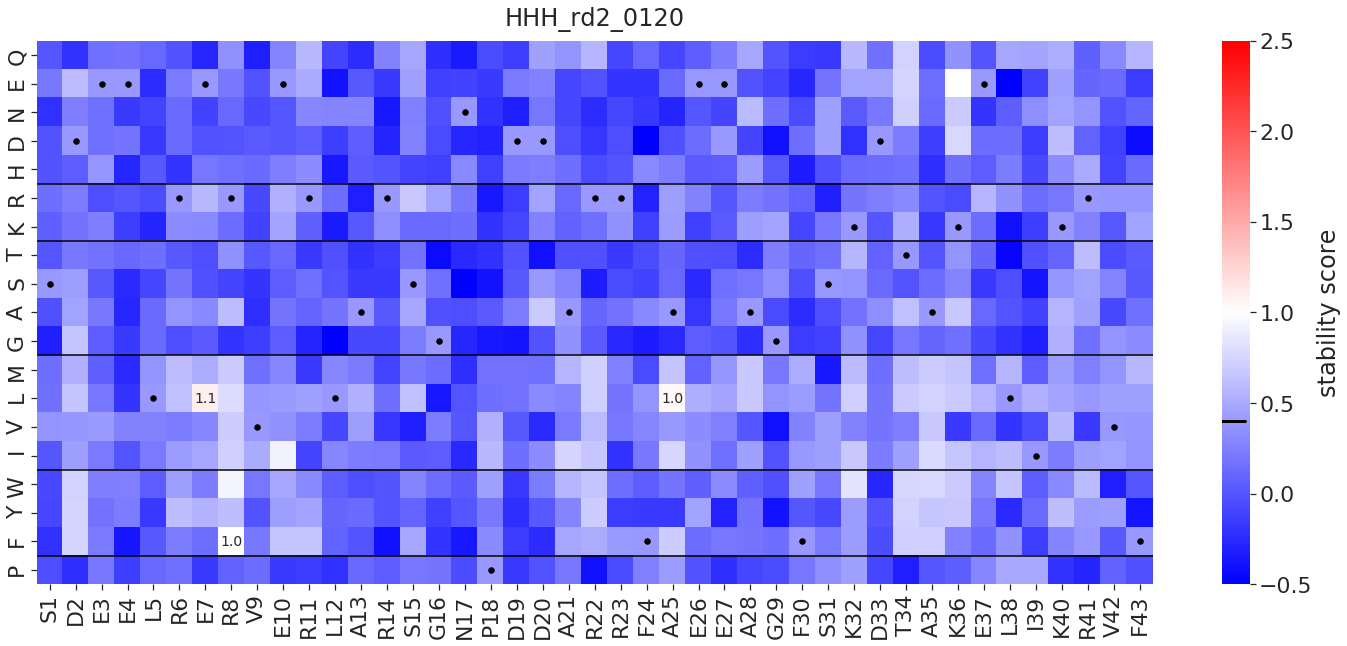


#----------------------------
HHH_rd2_0184 0.4654248653067403


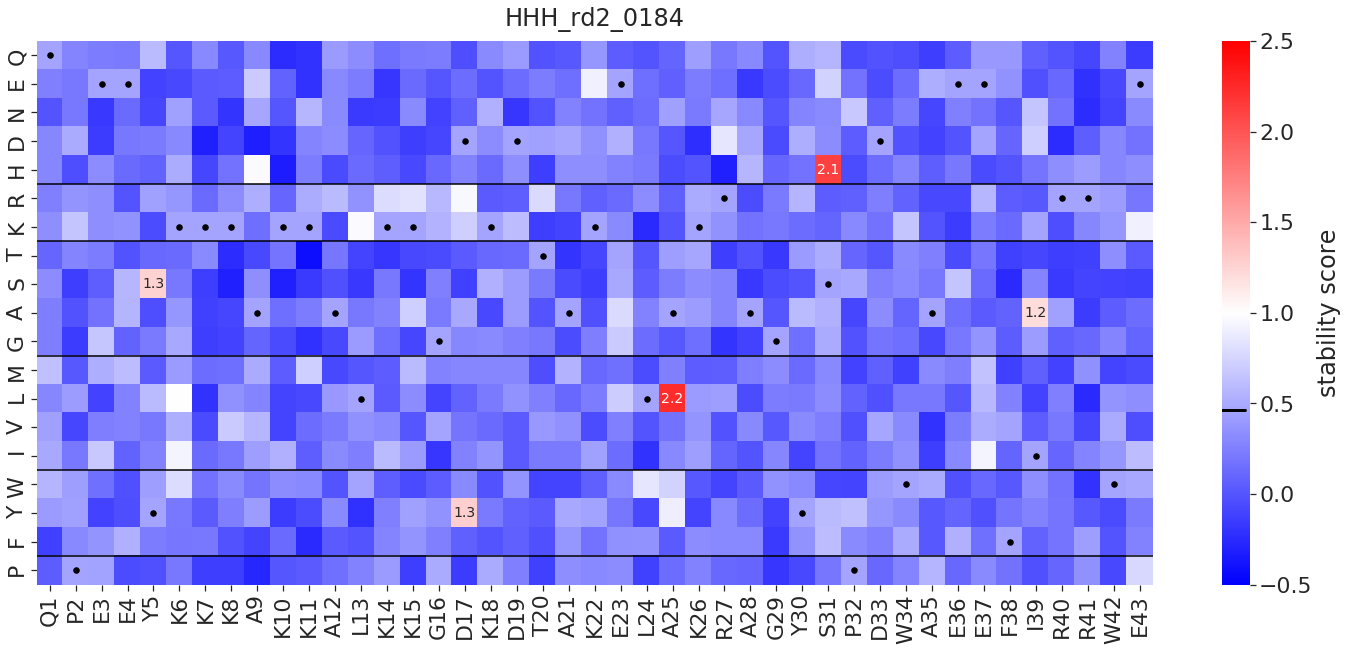


#----------------------------
HHH_rd4_0068 1.658440563217761


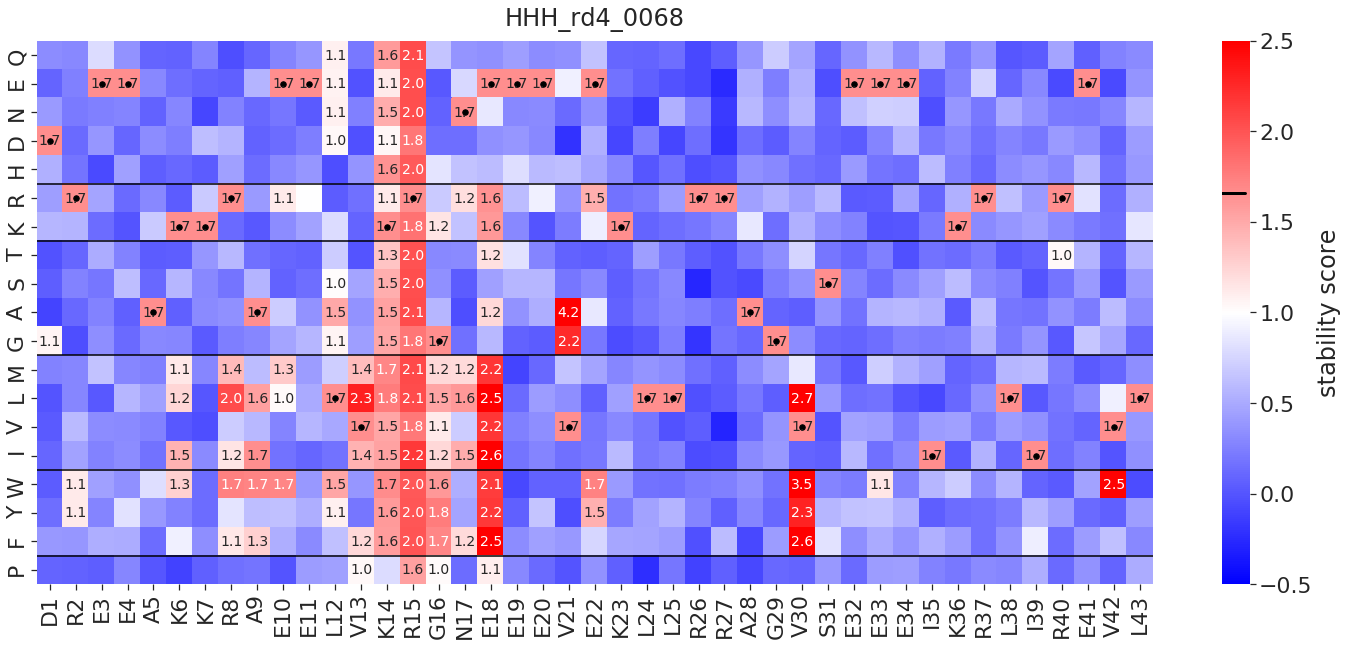


#----------------------------
HHH_rd4_0216 0.28269678376043056


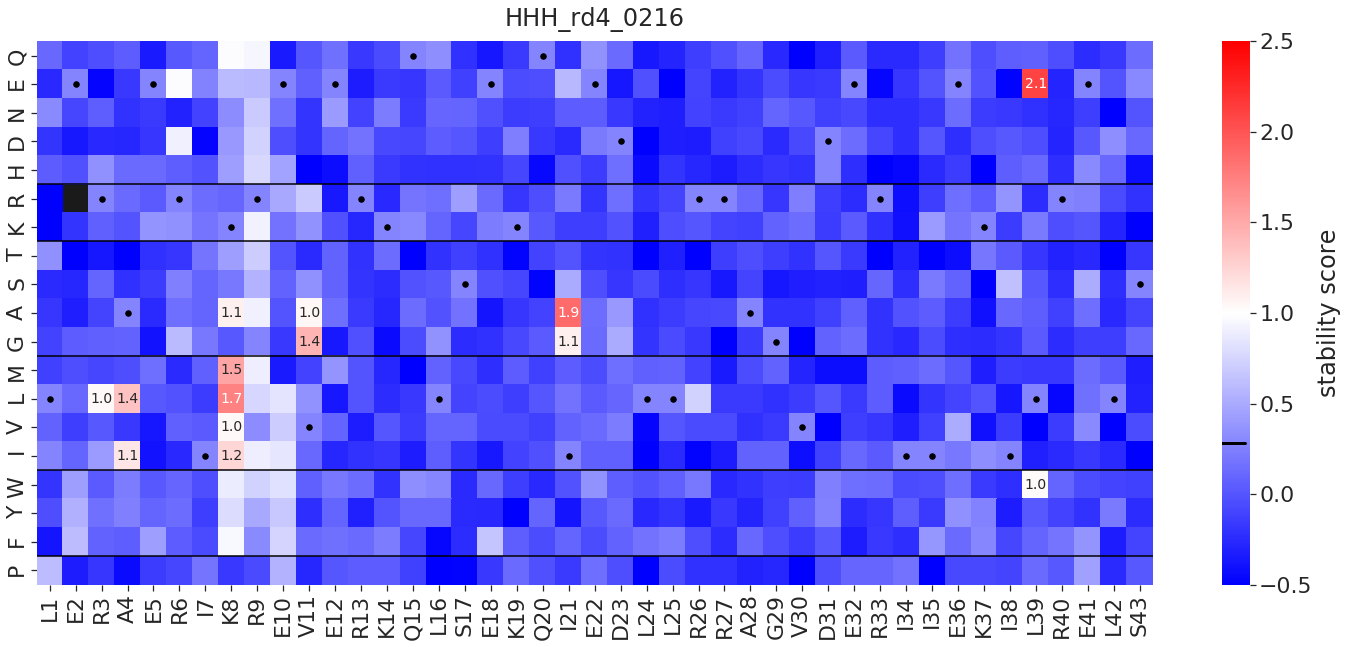


#----------------------------
HHH_rd4_0284 -0.2182962820438385


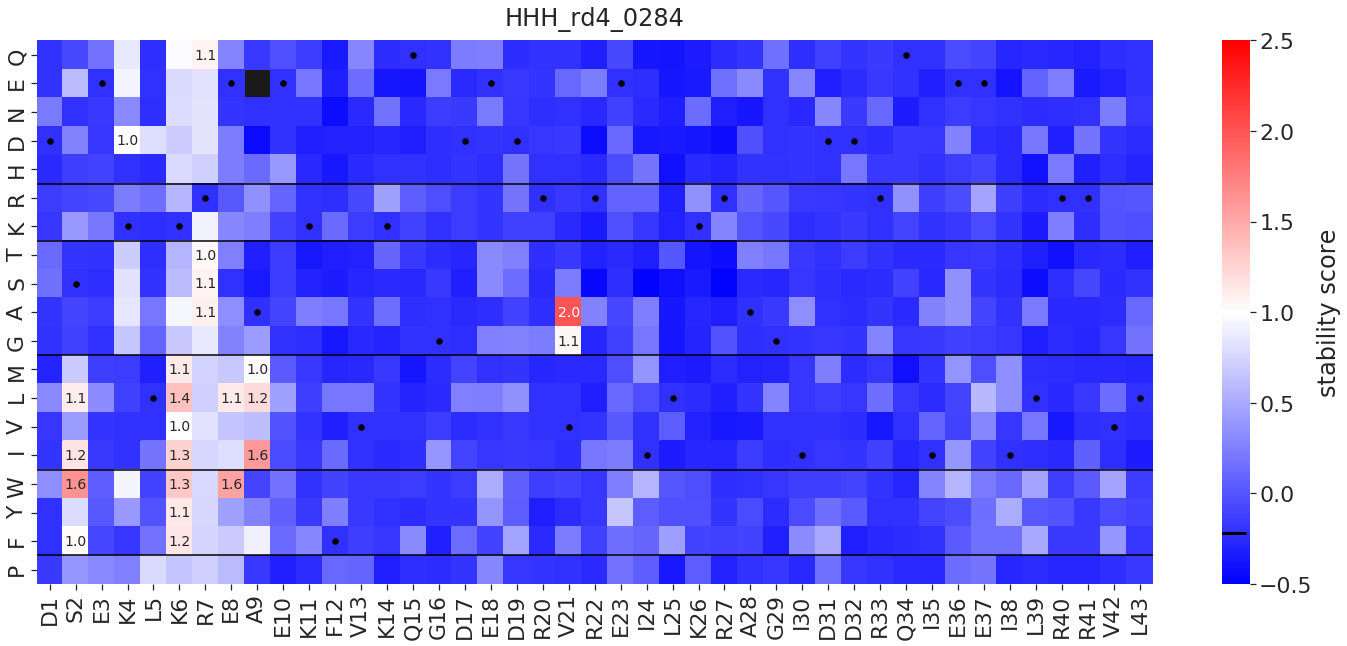


#----------------------------
HHH_rd4_0628 0.2944082853016752


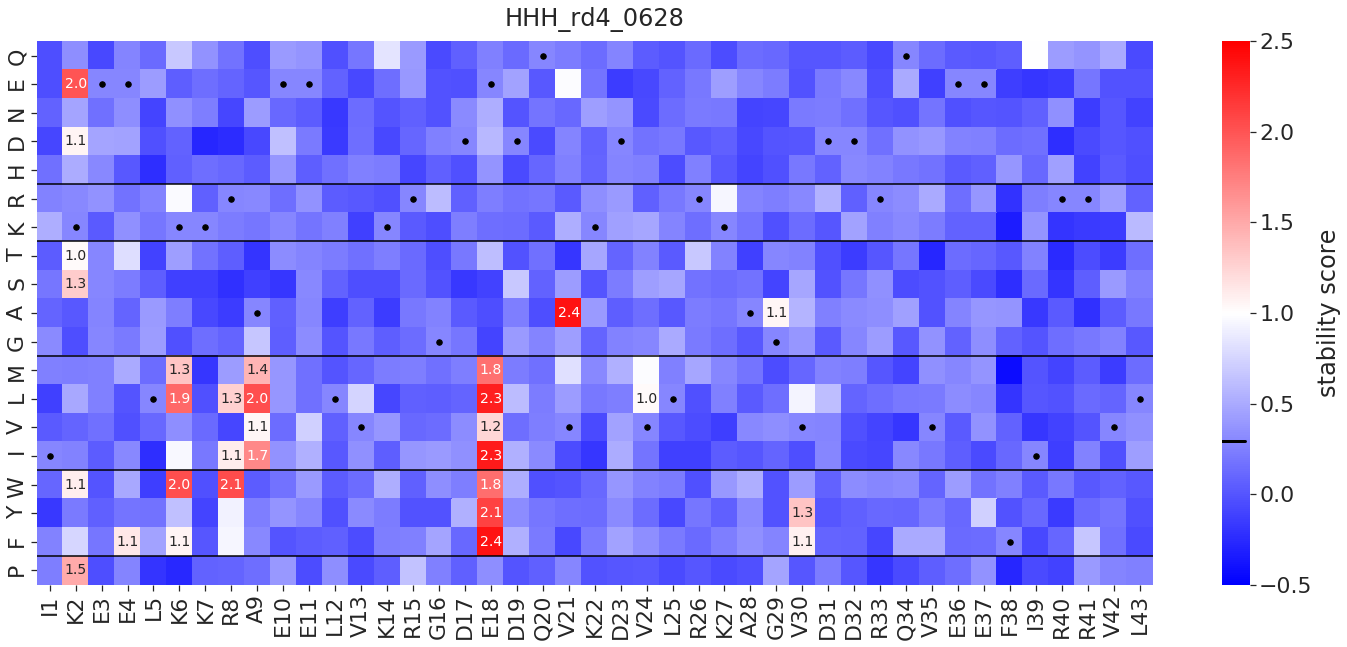


#----------------------------
HHH_rd4_0636 0.2754575758179148


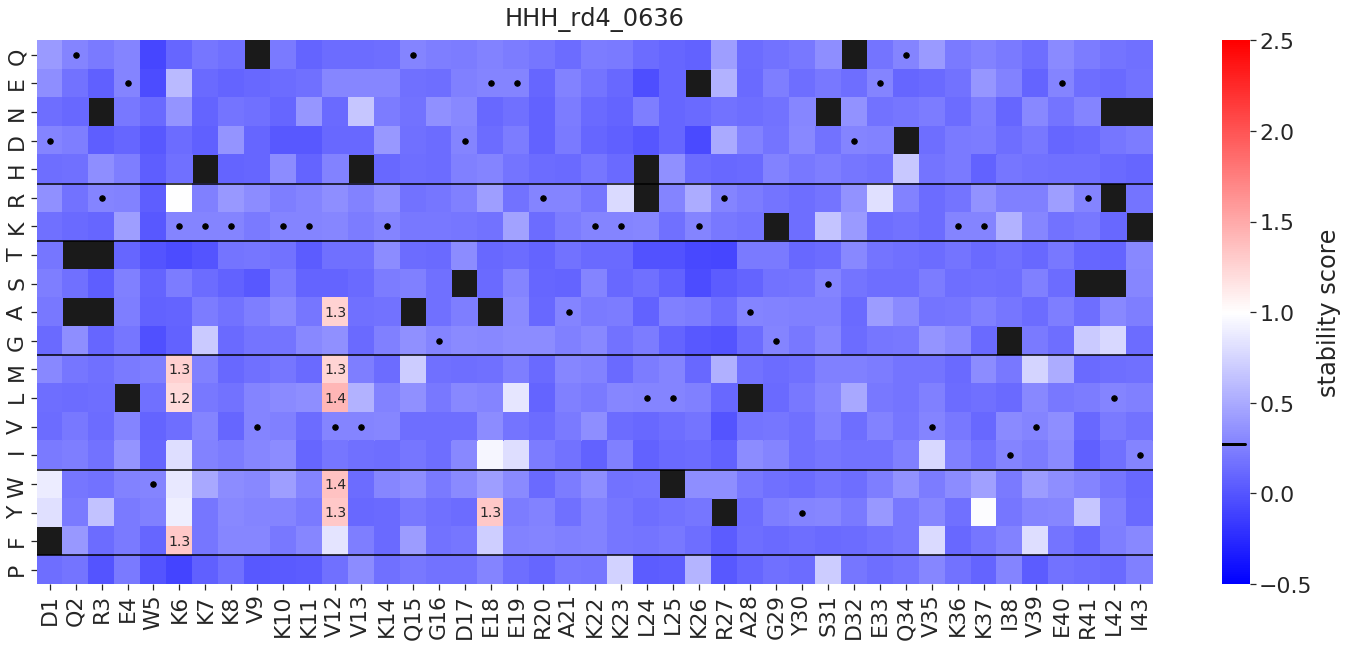


#----------------------------
HHH_rd4_0821 0.37664937841293367


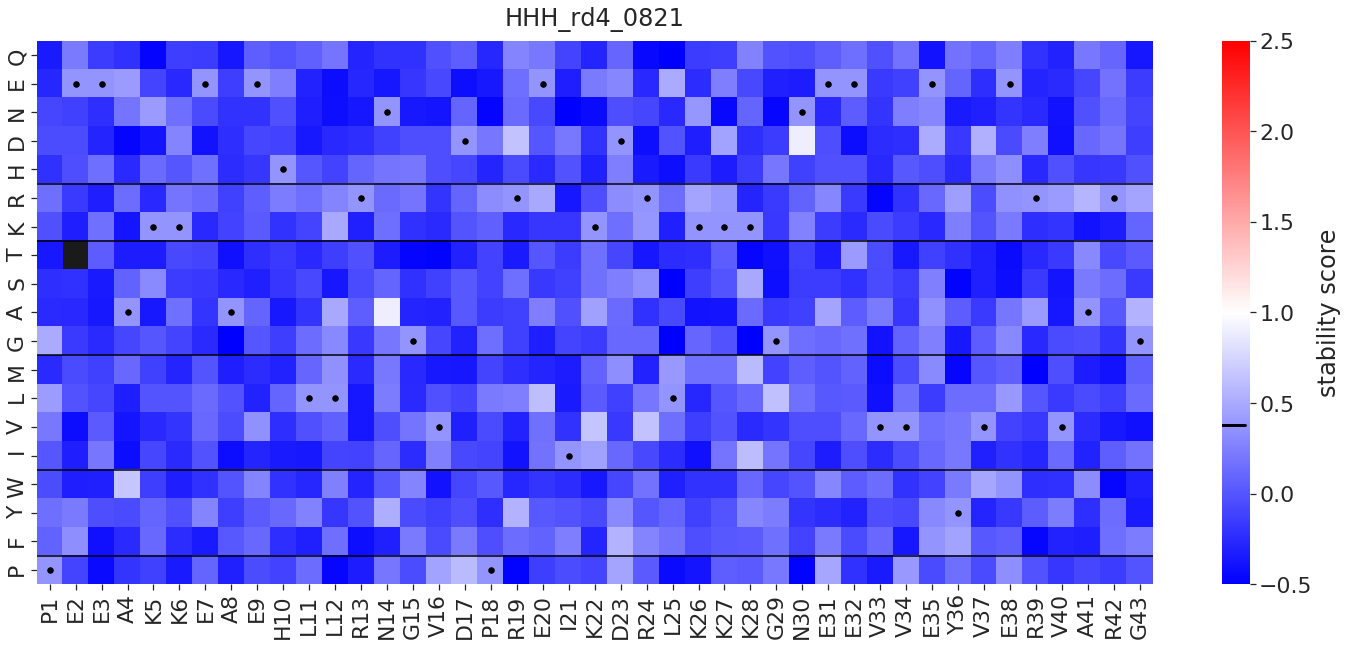


#----------------------------
HHH_rd4_0838 0.6799560701610929


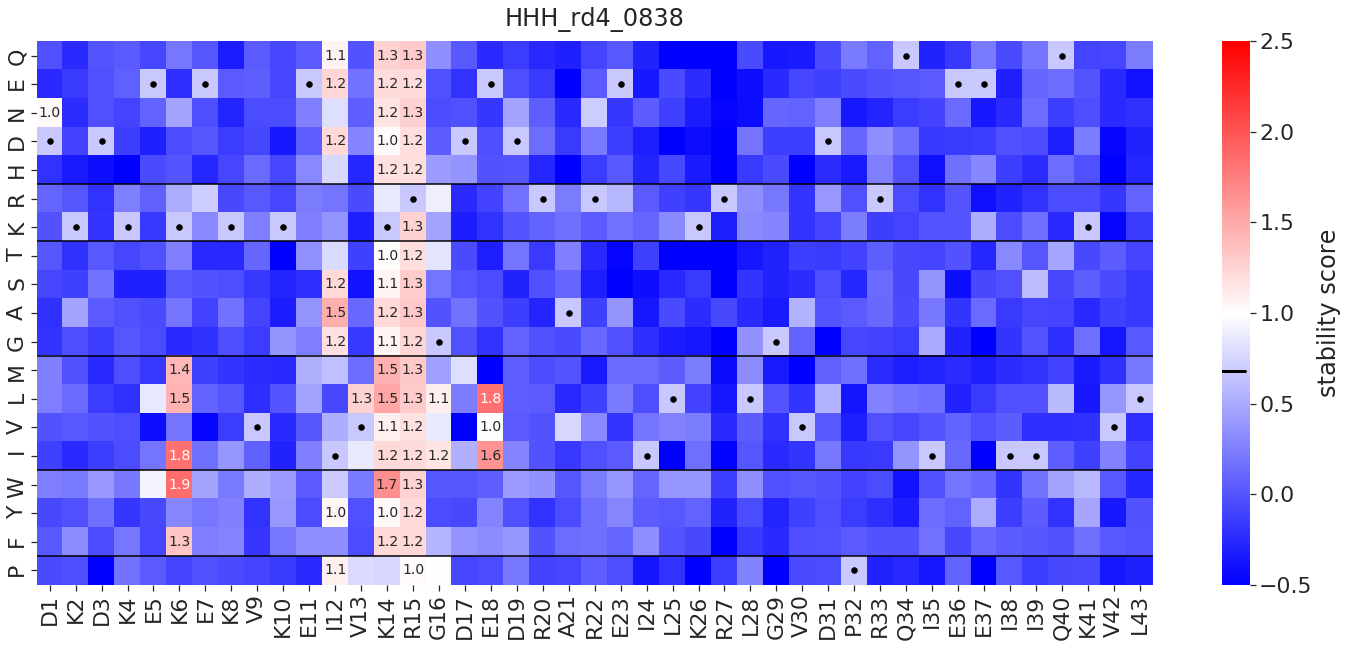


#----------------------------
HHH_rd4_0998 0.5775624110517699


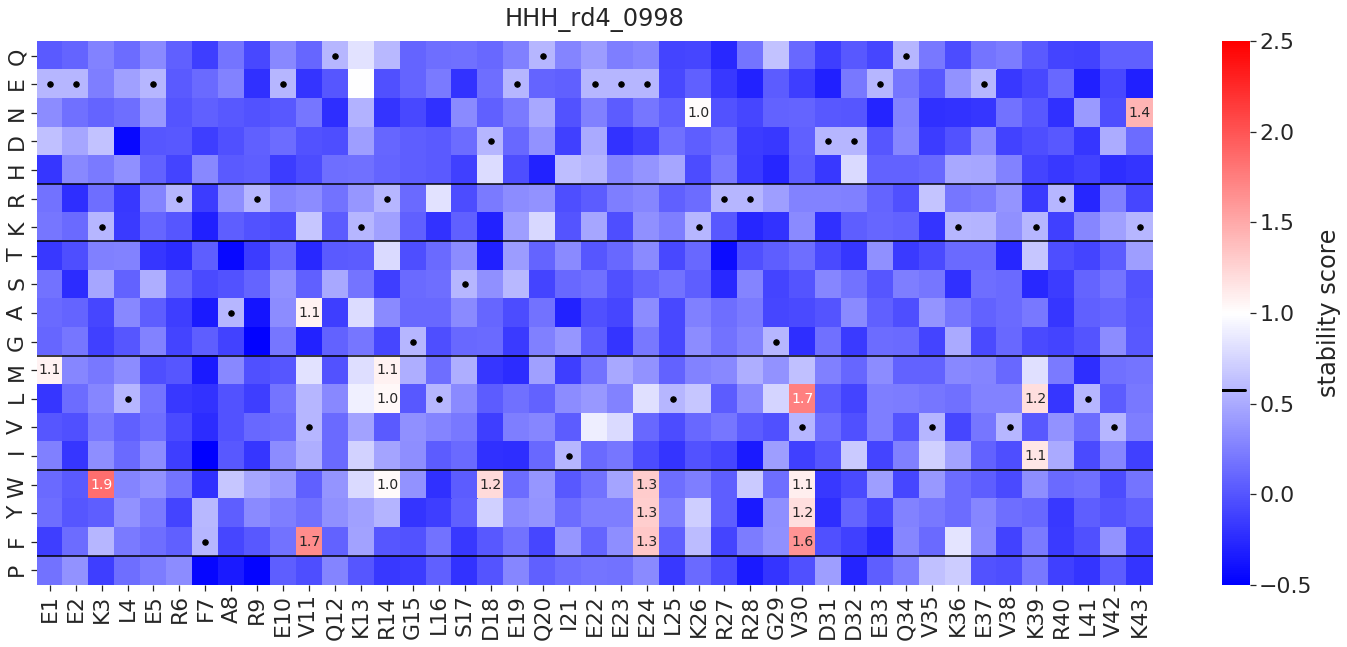

In [21]:
# Get data from the SSMs
data = stability_scores_df[
    (stability_scores_df['group'] == 'SSM')
].copy()

# Plot data for each SSM individually
stabilityscore_metric = 'stabilityscore_avg'
outputdir = os.path.join(resultsdir, 'ssm_plots')
if not os.path.isdir(outputdir):
    os.makedirs(outputdir)
parent_names = sorted(list(set(data['parent_name'])))
for parent_name in parent_names:
    
    # Get the stability score of the parent design
    wt_stabilityscore = data[
        data['name'] == '{0}_wt'.format(parent_name)
    ][stabilityscore_metric][0]
    
    # Get data for the SSM for the parent design
    print("\n#----------------------------")
    print(parent_name, wt_stabilityscore)
    data_i = data[
        (data['parent_name'] == parent_name) &
        (data['site_n'].notnull())
    ].copy()
    data_i['site_n'] = data_i['site_n'].astype('int32')
    data_i['aa'] = data_i['mut_aa']
    
    # For each site in the protein, add a row corresponding to the
    # parent amino acid with the parent stability score (in the
    # original dataframe there is only one row for the parent design)
    sites_and_wt_aa = []
    for site_n in set(data_i['site_n']):
        wt_aa = list(set(data_i[data_i['site_n'] == site_n]['wt_aa']))
        assert len(wt_aa) == 1
        wt_aa = wt_aa[0]
        sites_and_wt_aa.append((site_n, wt_aa))
        df = pandas.DataFrame({
            'site_n' : [site_n],
            'aa' : [wt_aa],
            stabilityscore_metric : [wt_stabilityscore]
        })
        data_i = pandas.concat([data_i, df], sort=False)
    
    # Turn data into a matrix for plotting
    data_i = data_i.pivot_table(
        index=['aa'], columns='site_n', values=[stabilityscore_metric]
    )
    data_i.columns = data_i.columns.droplevel().rename(None)

    # Plot data
    sites = [site for (site, wt_aa) in sites_and_wt_aa]
    xticklabels = [
        '{0}{1}'.format(wt_aa, site)
        for (site, wt_aa) in sites_and_wt_aa
    ]
    plt.figure(figsize=[25,10])
    aas = list('QENDHRKTSAGMLVIWYFP')
    annot_df = data_i.loc[aas].copy()
    for col in annot_df.columns.values:
        annot_df[col] = annot_df[col].apply(
            lambda x: '' if x < 1.0 else str(round(x, 1))
        )
    g = sns.heatmap(
        data_i.loc[aas], cmap='bwr',
        vmin=-0.5, vmax=2.5,
        xticklabels=xticklabels,
        annot=annot_df.to_numpy(),
        fmt='s', annot_kws={
            'size':14,
            'horizontalalignment':'center',
            'verticalalignment':'center'
        },
        cbar_kws={'label': 'stability score'}
    )
    g.set_facecolor('k')

    # ... add horizontal lines to indicate groups of amino acids
    plt.plot([0,max(sites)],[5,5],color='black')
    plt.plot([0,max(sites)],[7,7],color='black')
    plt.plot([0,max(sites)],[11,11],color='black')
    plt.plot([0,max(sites)],[15,15],color='black')
    plt.plot([0,max(sites)],[18,18],color='black')
    
    # ... add dots indicating the wildtype amino acid at each site
    for (site_n, wt_aa) in sites_and_wt_aa:
        i = site_n - 1
        plt.scatter(
            i + 0.5, aas.index(wt_aa) + 0.5, s=30, color='black'
        )
    
    # Add a dash to the color bar to indicate the stability
    # of the parent design
    cax = plt.gcf().axes[-1]
    cax.plot(
        [-1,2], [wt_stabilityscore,wt_stabilityscore],
        color='black', linewidth=3
    )
    plt.title(parent_name, pad=15)
    plt.ylabel('')
    outfile = os.path.join(outputdir, '{0}.pdf'.format(parent_name))
    plt.savefig(outfile)
    plt.show()

Compute the change in stability score of each mutant relative to its parent

In [22]:
def get_parent_stability(
    parent_name, parent_names, stabilityscore_metric
):
    if parent_name not in parent_names:
        return np.nan
    else:
        return float(stability_scores_df[
            stability_scores_df['name'] == '{0}_wt'.format(parent_name)
        ][stabilityscore_metric][0])

# Get SSM data
ssm_data = stability_scores_df[
    (stability_scores_df['group'] == 'SSM')
].copy()

# Clip stability scores at a lower limit of zero
if False:
    print("Clipping stability scores at a lower limit of zero")
    ssm_data['stabilityscore_avg'].clip(lower=0, inplace=True)

# Compute changes in stability score relative to parents
parent_names = set(ssm_data['parent_name'])
ssm_data['parent_stabilityscore_avg'] = \
    ssm_data.apply(
        lambda row: get_parent_stability(
            row['parent_name'], parent_names, 'stabilityscore_avg'
        ), axis=1
    )
ssm_data['delta_stabilityscore'] = \
    ssm_data['stabilityscore_avg'] - \
        ssm_data['parent_stabilityscore_avg']

# Round stability scores to the nearest tenth of a decimal
ssm_data['delta_stabilityscore'] = round(ssm_data['delta_stabilityscore'], 1)

In [23]:
def compute_topology(parent_name):
    if 'HHH' in parent_name:
        return 'HHH'
    elif 'EEHEE' in parent_name:
        return 'EEHEE'
    elif 'EHEE' in parent_name:
        return 'EHEE'
    else:
        return np.nan
ssm_data['topology'] = ssm_data['parent_name'].apply(compute_topology)

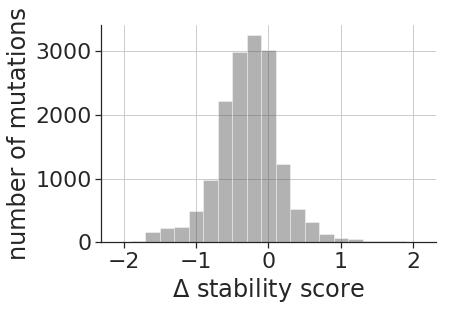

In [24]:
data = ssm_data[
    (~ssm_data['delta_stabilityscore'].isnull()) &
    #(ssm_data['parent_name'].isin(unstable_parents)) &
    (~ssm_data['mut_aa'].isnull())
].copy()
data['delta_stabilityscore'].clip(upper=2.0, inplace=True)
bin_size = 0.2
bins = np.arange(
    data['delta_stabilityscore'].min()-0.2,
    data['delta_stabilityscore'].max()+bin_size,
    bin_size
)
sns.distplot(
    data['delta_stabilityscore'], kde=False, bins=bins,
    color='0.25'
)
#plt.plot([1.0,1.0], [0,2000], ls='--', c='firebrick', linewidth=4)
plt.xlabel('$\Delta$ stability score')
plt.ylabel('number of mutations')
#plt.title('parent stability score < 0.5')
#plt.yscale('log')
plt.grid()
sns.despine()
plt.show()

In [25]:
data['delta_stabilityscore'].mean()

-0.3203349581302366

In [26]:
print(len(set(data['parent_name'])))
print(sum(data['delta_stabilityscore']>=1))
print(sum(data['delta_stabilityscore']>=1) / len(data) * 100)

21
156
0.974878140232471


In [27]:
print(len(data))
#print(sum(data['delta_stabilityscore']>=-10) / len(data) * 100)

16002


Count the number of mutations expected vs. observed

In [28]:
expected_names = []
aas = list('QENDHRKTSAGMLVIWYFP')
parent_names = set(ssm_data['parent_name'])
for parent_name in parent_names:
    parent_seq = ssm_data[ssm_data['name'] == f'{parent_name}_wt']['protein_sequence'][0]
    assert len(parent_seq) > 0
    for (i, wt_aa) in enumerate(parent_seq, 1):
        for mut_aa in aas:
            if mut_aa == wt_aa:
                continue
            expected_names.append(f'{parent_name}_{wt_aa}{i}{mut_aa}')

expected_names = set(expected_names)
print(f'Expected {len(expected_names)} mutations')

observed_names = set(ssm_data['name'])
common_names = set.intersection(expected_names, observed_names)
print(f'Observed {len(common_names)} of those mutations')
print(len(common_names)/len(expected_names))

Expected 16038 mutations
Observed 16007 of those mutations
0.9980670906596832


Plot the distribution of starting counts for each of the design variants

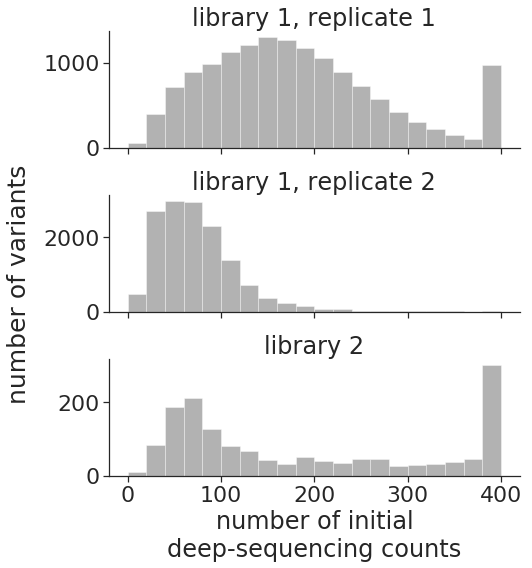

In [29]:
# Get data for first rep of big chip
data_rep1 = ssm_data[
    (ssm_data['counts0_c_rep1'].notnull()) &
    (ssm_data['chip_id'] == 'big_chip')
].copy()
data_rep1['counts0'] = data_rep1['counts0_c_rep1']

# Get data for second rep of big chip
data_rep2 = ssm_data[
    (ssm_data['counts0_c_rep2'].notnull()) &
    (ssm_data['chip_id'] == 'big_chip')
].copy()
data_rep2['counts0'] = data_rep2['counts0_c_rep2']

# Get data for small chip
data_small = ssm_data[
    (ssm_data['counts0_c'].notnull()) &
    (ssm_data['chip_id'] == 'small_chip')
].copy()
data_small['counts0'] = data_small['counts0_c']

# Make a single plot
libraries = (
    ('library 1, replicate 1', data_rep1),
    ('library 1, replicate 2', data_rep2),
    ('library 2', data_small),
)
(fig, axs) = plt.subplots(nrows=3, sharex=True, figsize=[7,8])
for (i, (name, data)) in enumerate(libraries):
    bins = np.arange(0, 420, 20)
    data = data.copy()
    data['counts0'].clip(upper=400, inplace=True)
    sns.distplot(data['counts0'], bins=bins, kde=False, ax=axs[i], color='0.25')
    axs[i].set(xlabel='', title=name)
axs[i].set(xlabel='number of initial\ndeep-sequencing counts')
fig.text(-0.05, 0.5, 'number of variants', va='center', rotation='vertical', fontsize=25)
plt.tight_layout()
sns.despine()
plt.show()

Compute the number of stabilizing mutations per parent design

In [30]:
n_stab_dict = {
    key : []
    for key in ['parent_name', 'n_stab']
}
for parent_name in list(set(ssm_data['parent_name'])):
    n_stab = len(ssm_data[
        (ssm_data['parent_name'] == parent_name) &
        (ssm_data['delta_stabilityscore'] >= 0.99)
    ])
    n_stab_dict['parent_name'].append(parent_name)
    n_stab_dict['n_stab'].append(n_stab)

n_stab_df = pandas.DataFrame(n_stab_dict)
n_stab_df['topology'] = n_stab_df['parent_name'].apply(compute_topology)
n_stab_df.head()

parent_name  n_stab topology
0  EEHEE_rd4_0464       1    EEHEE
1    HHH_rd4_0838       5      HHH
2    HHH_rd4_0628      19      HHH
3   EHEE_rd4_0144      27     EHEE
4   EHEE_rd4_0570       0     EHEE

Count the number of stabilizing mutations per protein and topology

In [31]:
n_stab_counts_dict = {
    key : []
    for key in ['n_stab', 'counts', 'topology']
}
topologies = ['HHH', 'EHEE', 'EEHEE']
for topology in topologies:
    for n_stab in range(0, 11):
        if n_stab == 10:
            counts = sum(
                (n_stab_df['topology'] == topology) &
                (n_stab_df['n_stab'] >= 10)
            )
            n_stab = '$\geq10$'
        else:
            counts = sum(
                (n_stab_df['topology'] == topology) &
                (n_stab_df['n_stab'] == n_stab)
            )
        n_stab_counts_dict['n_stab'].append(str(n_stab))
        n_stab_counts_dict['counts'].append(counts)
        n_stab_counts_dict['topology'].append(topology)

n_stab_counts_df = pandas.DataFrame(n_stab_counts_dict)
n_stab_counts_df.tail()

n_stab  counts topology
28         6       0    EEHEE
29         7       0    EEHEE
30         8       0    EEHEE
31         9       0    EEHEE
32  $\geq10$       0    EEHEE

Plot number of rescue mutations per design, broken down by topology

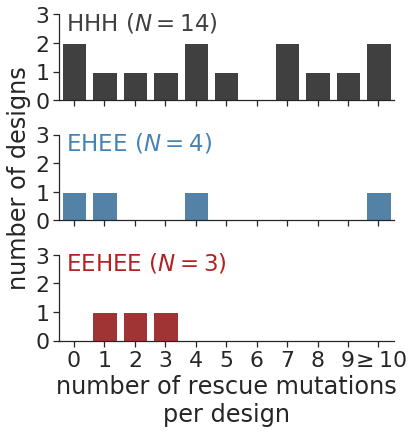

In [32]:
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True,
    figsize=[6, 6]
)
color_dict = {
    'HHH' : '0.25',
    'EHEE' : 'steelblue',
    'EEHEE' : 'firebrick'
}
for (i, topology) in enumerate(topologies):
    data = n_stab_counts_df[n_stab_counts_df['topology'] == topology]
    n = sum(data['counts'])
    sns.barplot(
        x='n_stab', y='counts', data=data, color=color_dict[topology],
        ax=axs[i]
    )
    axs[i].set(ylabel='', xlabel='', ylim=[0,3], yticks=[0,1,2,3])
    axs[i].text(
        0.02, 0.82, f'{topology} ($N={n}$)',
        transform=axs[i].transAxes,
        color=color_dict[topology], fontsize=23
    )
axs[2].set(xlabel='number of rescue mutations\nper design')
axs[1].set(ylabel='number of designs')
plt.subplots_adjust(hspace = 0.4)
#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
#plt.tight_layout()
sns.despine()

Plot the above data for all topologies combined

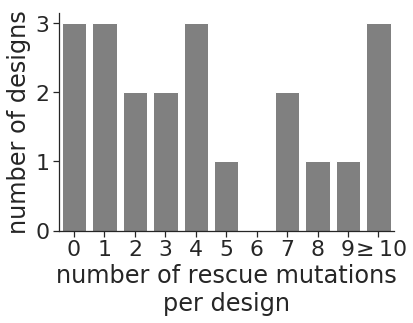

In [33]:
n_stab_ids = list(n_stab_counts_df[n_stab_counts_df['topology'] == 'HHH']['n_stab'])
data = n_stab_counts_df.pivot(
    index='n_stab', columns='topology', values='counts'
)
data['all'] = data[['EEHEE', 'EHEE', 'HHH']].sum(axis=1)
data = data.loc[n_stab_ids]
data.reset_index(inplace=True)
sns.barplot(
    x='n_stab', y='all', data=data,
    color='0.5'
)
plt.ylabel('number of designs')
plt.xlabel('number of rescue mutations\nper design')
sns.despine()
plt.show()

What kinds of rescue mutations did we observe? How many fall into different physical categories?

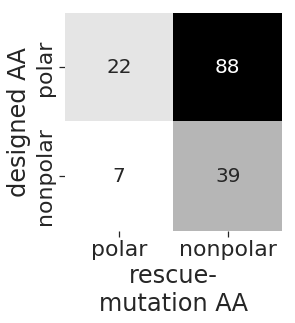

In [34]:
# Get data for "rescue" mutations
data = ssm_data[
    #(ssm_data['name'].str.contains('HHH_rd4_0216')) &
    (ssm_data['delta_stabilityscore'] >= 0.99)
].copy()

# Categorize mutations by polarity
polar_aa = 'RHKDENQST'
data['wt_polarity'] = data['wt_aa'].apply(
    lambda x: 'polar' if x in polar_aa else 'nonpolar'
)
data['mut_polarity'] = data['mut_aa'].apply(
    lambda x: 'polar' if x in polar_aa else 'nonpolar'
)
polarity_dict = {
    key : []
    for key in ['wt_polarity', 'polar', 'nonpolar']
}
for wt_polarity in ['polar', 'nonpolar']:
    data_i = data[data['wt_polarity'] == wt_polarity]
    polarity_dict['wt_polarity'].append(wt_polarity)
    for mut_polarity in ['polar', 'nonpolar']:
        polarity_dict[mut_polarity].append(
            sum(data_i['mut_polarity'] == mut_polarity)
        )
        
polarity_df = pandas.DataFrame(polarity_dict)
polarity_df.set_index('wt_polarity', inplace=True)

g = sns.heatmap(
    polarity_df, cmap='Greys', cbar=False, square=True,
    annot=True, annot_kws={"fontsize":20}
)
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('rescue-\nmutation AA')
plt.ylabel('designed AA')
plt.show()

In [41]:
data[
    (data['wt_polarity'] == 'polar') &
    (data['mut_polarity'] == 'polar')
][[
    'name', 'wt_aa', 'mut_aa', 'wt_polarity', 'mut_polarity'
]].sort_values('name').head(n=22)

name wt_aa mut_aa wt_polarity mut_polarity
chip_name                                                                    
ssm_6339               HHH_rd1_0501_N8R     N      R       polar        polar
ssm_5481               HHH_rd1_0649_E4D     E      D       polar        polar
ssm_5816              HHH_rd1_0649_K22R     K      R       polar        polar
ssm_5829              HHH_rd1_0649_R23K     R      K       polar        polar
ssm_8296              HHH_rd2_0184_S31H     S      H       polar        polar
HHH_rd4_0284.pdb_K4D   HHH_rd4_0284_K4D     K      D       polar        polar
HHH_rd4_0284.pdb_K4E   HHH_rd4_0284_K4E     K      E       polar        polar
HHH_rd4_0284.pdb_K4Q   HHH_rd4_0284_K4Q     K      Q       polar        polar
HHH_rd4_0284.pdb_K4S   HHH_rd4_0284_K4S     K      S       polar        polar
HHH_rd4_0284.pdb_K6E   HHH_rd4_0284_K6E     K      E       polar        polar
HHH_rd4_0284.pdb_K6H   HHH_rd4_0284_K6H     K      H       polar        polar
HHH_rd4_0284.pdb_K6N   HHH_rd4_0284_K6N     K      N       polar        polar
HHH_rd4_0284.pdb_K6Q   HHH_rd4_0284_K6Q     K      Q       polar        polar
HHH_rd4_0284.pdb_R7D   HHH_rd4_0284_R7D     R      D       polar        polar
HHH_rd4_0284.pdb_R7E   HHH_rd4_0284_R7E     R      E       polar        polar
HHH_rd4_0284.pdb_R7K   HHH_rd4_0284_R7K     R      K       polar        polar
HHH_rd4_0284.pdb_R7N   HHH_rd4_0284_R7N     R      N       polar        polar
HHH_rd4_0284.pdb_R7Q   HHH_rd4_0284_R7Q     R      Q       polar        polar
HHH_rd4_0284.pdb_R7S   HHH_rd4_0284_R7S     R      S       polar        polar
HHH_rd4_0284.pdb_R7T   HHH_rd4_0284_R7T     R      T       polar        polar
ssm_3121               HHH_rd4_0628_K2E     K      E       polar        polar
ssm_3132               HHH_rd4_0628_K2S     K      S       polar        polar

Categorize mutations by size changes, only looking at mutations between two nonpolar amino acids

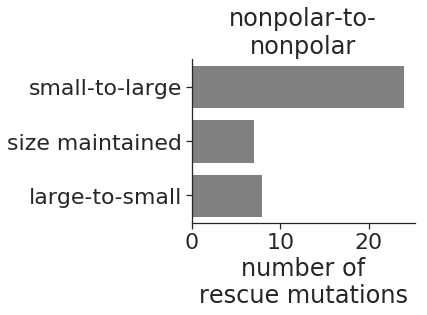

In [41]:
np_data = data[
    (data['wt_polarity'] == 'nonpolar') &
    (data['mut_polarity'] == 'nonpolar')
].copy()

def classify_by_size(aa):
    if aa in ['A', 'G', 'P']:
        return 'small'
    elif aa in ['V', 'L', 'I', 'M']:
        return 'medium'
    elif aa in ['F', 'W', 'Y']:
        return 'large'
    else:
        raise ValueError(aa)
np_data['wt_size'] = np_data['wt_aa'].apply(
    lambda x: classify_by_size(x)
)
np_data['mut_size'] = np_data['mut_aa'].apply(
    lambda x: classify_by_size(x)
)

def classify_size_change(wt_size, mut_size):
    if wt_size == 'small':
        if mut_size == 'small':
            return 'size maintained'
        else:
            return 'small-to-large'
    elif wt_size == 'medium':
        if mut_size == 'small':
            return 'large-to-small'
        elif mut_size == 'medium':
            return 'size maintained'
        else:
            return 'small-to-large'
    else:
        assert wt_size == 'large'
        if mut_size == 'small':
            return 'large-to-small'
        elif mut_size == 'medium':
            return 'large-to-small'
        else:
            return 'size maintained'
np_data['size_change'] = np_data.apply(
    lambda row: classify_size_change(row['wt_size'], row['mut_size']),
    axis=1
)

# Plot data
plt.figure(figsize=[4,3])
order = ['small-to-large', 'size maintained', 'large-to-small']
sns.countplot(
    y='size_change', data=np_data, order=order,
    color='0.5'
)
#plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('number of\nrescue mutations')
plt.title('nonpolar-to-\nnonpolar')
sns.despine()
plt.show()

In [49]:
np_data[
    np_data['size_change'] == 'small-to-large' # 'large-to-small'
][[
    'name', 'wt_aa', 'mut_aa', 'wt_size', 'mut_size',
    'size_change', 'delta_stabilityscore'
]].head()

name wt_aa mut_aa wt_size mut_size     size_change  \
chip_name                                                                     
ssm_11598   EHEE_rd4_0144_G8M     G      M   small    large  small-to-large   
ssm_11664  EHEE_rd4_0144_A12F     A      F   small    large  small-to-large   
ssm_11678  EHEE_rd4_0144_A12W     A      W   small    large  small-to-large   
ssm_11732  EHEE_rd4_0144_A15W     A      W   small    large  small-to-large   
ssm_12153  EHEE_rd4_0144_A39I     A      I   small    large  small-to-large   

           delta_stabilityscore  
chip_name                        
ssm_11598                   1.0  
ssm_11664                   1.5  
ssm_11678                   1.3  
ssm_11732                   1.2  
ssm_12153                   1.2

Make a heatmap using a slightly different sizing scheme

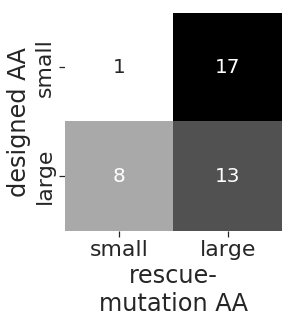

In [45]:
def classify_size(x):
    if x in ['G', 'A', 'P']:
        return 'small'
    else:
        return 'large'
np_data['wt_size'] = np_data['wt_aa'].apply(classify_size)
np_data['mut_size'] = np_data['mut_aa'].apply(classify_size)

size_dict = {
    key : []
    for key in ['wt_size', 'small', 'large']
}
for wt_size in ['small', 'large']:
    data_i = np_data[np_data['wt_size'] == wt_size]
    size_dict['wt_size'].append(wt_size)
    for mut_size in ['small', 'large']:
        size_dict[mut_size].append(
            sum(data_i['mut_size'] == mut_size)
        )
        
size_df = pandas.DataFrame(size_dict)
size_df.set_index('wt_size', inplace=True)

g = sns.heatmap(
    size_df, cmap='Greys', cbar=False, square=True,
    annot=True, annot_kws={"fontsize":20}
)
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('rescue-\nmutation AA')
plt.ylabel('designed AA')
plt.show()

In [57]:
np_data[
    (np_data['wt_size'] == 'large') &
    (np_data['mut_size'] == 'large')
][[
    'name', 'wt_aa', 'mut_aa', 'wt_size', 'mut_size',
    'size_change', 'delta_stabilityscore'
]].head()

name wt_aa mut_aa wt_size mut_size      size_change  \
chip_name                                                                       
ssm_13011   EEHEE_rd4_0215_M3V     M      V   large    large  size maintained   
ssm_13481  EEHEE_rd4_0215_Y29W     Y      W   large    large  size maintained   
ssm_1734     HHH_rd4_0998_V11F     V      F   large    large   small-to-large   
ssm_2076     HHH_rd4_0998_V30F     V      F   large    large   small-to-large   
ssm_2081     HHH_rd4_0998_V30L     V      L   large    large  size maintained   

           delta_stabilityscore  
chip_name                        
ssm_13011                   1.4  
ssm_13481                   1.0  
ssm_1734                    1.1  
ssm_2076                    1.1  
ssm_2081                    1.2

In [36]:
mutations_dict = {
    'HHH_rd4_0284' : [
        ('S', 2, 'W'),
        ('K' , 6, 'L'), ('K' , 6, 'I'), ('K' , 6, 'W'),
        ('R' , 7, 'A'),
        ('E', 8, 'W'), ('E', 8, 'L'),
        ('A', 9, 'I'), ('A', 9, 'L'),
        ('V', 21, 'A'), ('V', 21, 'G')
    ],
    'HHH_rd4_0636' : [
        ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'F'),
        ('V', 12, 'A'), ('V', 12, 'L'), ('V', 12, 'M'), ('V', 12, 'W'),
        ('V', 12, 'Y'),
        ('E', 18, 'Y')
    ],
    'HHH_rd4_0628' : [
        ('K', 2, 'E'),
        ('K', 6, 'L'), ('K', 6, 'V'), ('K', 6, 'W'), ('K', 6, 'F'),
        ('K', 6, 'M'),
        ('R', 8, 'W'), ('R', 8, 'L'),
        ('A', 9, 'L'), ('A', 9, 'V'), ('A', 9, 'I'), ('A', 9, 'M'),
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W'),
        ('V', 21, 'A'), ('V', 21, 'G'),
        ('V', 30, 'F'), ('V', 30, 'Y')
    ],
    'HHH_rd2_0184' : [
        ('A', 25, 'L')
    ],
    'HHH_rd4_0216' : [
        ('R', 3, 'L'),
        ('A', 4, 'L'), ('A', 4, 'I'), ('A', 4, 'V'),
        ('K', 8, 'L'), ('K', 8, 'M'), ('K', 8, 'V'), ('K', 8, 'I'),
        ('V', 11, 'A'), ('V', 11, 'G'),
        ('I', 21, 'A'), ('I', 21, 'G'),
        ('L', 39, 'E')
    ],
    'HHH_rd4_0998' : [
        ('K', 3, 'W'), ('K', 3, 'W'),
        ('V', 11, 'A'), ('V', 11, 'F'),
        ('R', 14, 'L'), ('R', 14, 'M'), ('R', 14, 'W'),
        ('D', 18, 'W'),
        ('E', 24, 'W'), ('E', 24, 'Y'), ('E', 24, 'F'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('K', 39, 'I'), ('K', 39, 'L')
    ],
    'HHH_rd4_0068' : [
        ('E', 18, 'M'), ('E', 18, 'L'), ('E', 18, 'I'), ('E', 18, 'V'),
        ('E', 18, 'F'), ('E', 18, 'Y'), ('E', 18, 'W'),
        ('V', 21, 'A'), ('V', 21, 'G'),
        ('V', 30, 'W'), ('V', 30, 'Y'), ('V', 30, 'F'), ('V', 30, 'L'),
        ('V', 42, 'W'), ('V', 42, 'Y'), ('V', 42, 'F'), ('V', 42, 'L')
    ],
    'HHH_rd4_0838' : [
        ('K', 6, 'I'), ('K', 6, 'L'), ('K', 6, 'M'), ('K', 6, 'V'),
        ('K', 6, 'W'), ('K', 6, 'F'),
        ('E', 18, 'L'), ('E', 18, 'V'), ('E', 18, 'L'), ('E', 18, 'F')
    ],
    'EEHEE_rd4_0215' : [
        ('M', 3, 'V'),
        ('A', 18, 'M'),
        ('Y', 29, 'W')
    ]
}

In [47]:
wt_aas = ['K', 'R', 'E', 'D']
mut_aas = ['A', 'M', 'L', 'V', 'I', 'W', 'Y', 'F']

wt_aas = ['V', 'I', 'M']
mut_aas = ['A', 'G'] #  'L']

In [48]:
parents_to_ignore = [
    'EHEE_rd4_0144'
]
parents_with_data = list(mutations_dict.keys())
stab_df = ssm_data[
    (ssm_data['wt_aa'].isin(wt_aas)) &
    (ssm_data['mut_aa'].isin(mut_aas)) &
    (ssm_data['delta_stabilityscore'] > 0.95) &
    (ssm_data['stabilityscore_avg'] > 1) &
    ~(ssm_data['parent_name'].isin(parents_to_ignore)) #&
    #(ssm_data['parent_name'].isin(parents_with_data))
]
print(len(stab_df))
stab_df[[
    'name', 'delta_stabilityscore', 'stabilityscore_avg',
    'parent_stabilityscore_avg'
]].head(n=10)

7


name  delta_stabilityscore  \
chip_name                                                        
ssm_1136               HHH_rd4_0216_I21A                   1.6   
ssm_3461               HHH_rd4_0628_V21A                   2.1   
ssm_5011               HHH_rd4_0068_V21A                   2.5   
ssm_960                HHH_rd4_0216_V11G                   1.2   
HHH_rd4_0636.pdb_V12A  HHH_rd4_0636_V12A                   1.0   
HHH_rd4_0284.pdb_V21G  HHH_rd4_0284_V21G                   1.3   
HHH_rd4_0284.pdb_V21A  HHH_rd4_0284_V21A                   2.2   

                       stabilityscore_avg  parent_stabilityscore_avg  
chip_name                                                             
ssm_1136                         1.869965                   0.282697  
ssm_3461                         2.391006                   0.294408  
ssm_5011                         4.196667                   1.658441  
ssm_960                          1.438820                   0.282697  
HHH_rd4_0636.pdb_V12A            1.261943                   0.275458  
HHH_rd4_0284.pdb_V21G            1.056044                  -0.218296  
HHH_rd4_0284.pdb_V21A            2.002938                  -0.218296

In [49]:
for parent_name in list(set(stab_df['parent_name'])):
    display(stab_df[
        stab_df['parent_name'] == parent_name
    ].sort_values('site_n')[[
        'name', 'delta_stabilityscore', 'stabilityscore_avg',
        'parent_stabilityscore_avg'
    ]])

name  delta_stabilityscore  stabilityscore_avg  \
chip_name                                                                
ssm_960    HHH_rd4_0216_V11G                   1.2            1.438820   
ssm_1136   HHH_rd4_0216_I21A                   1.6            1.869965   

           parent_stabilityscore_avg  
chip_name                             
ssm_960                     0.282697  
ssm_1136                    0.282697

name  delta_stabilityscore  stabilityscore_avg  \
chip_name                                                                
ssm_5011   HHH_rd4_0068_V21A                   2.5            4.196667   

           parent_stabilityscore_avg  
chip_name                             
ssm_5011                    1.658441

name  delta_stabilityscore  \
chip_name                                                        
HHH_rd4_0284.pdb_V21G  HHH_rd4_0284_V21G                   1.3   
HHH_rd4_0284.pdb_V21A  HHH_rd4_0284_V21A                   2.2   

                       stabilityscore_avg  parent_stabilityscore_avg  
chip_name                                                             
HHH_rd4_0284.pdb_V21G            1.056044                  -0.218296  
HHH_rd4_0284.pdb_V21A            2.002938                  -0.218296

name  delta_stabilityscore  \
chip_name                                                        
HHH_rd4_0636.pdb_V12A  HHH_rd4_0636_V12A                   1.0   

                       stabilityscore_avg  parent_stabilityscore_avg  
chip_name                                                             
HHH_rd4_0636.pdb_V12A            1.261943                   0.275458

name  delta_stabilityscore  stabilityscore_avg  \
chip_name                                                                
ssm_3461   HHH_rd4_0628_V21A                   2.1            2.391006   

           parent_stabilityscore_avg  
chip_name                             
ssm_3461                    0.294408

In [50]:
sites_to_plot = {}
for parent_name in list(set(stab_df['parent_name'])):
    sites_to_plot[parent_name] = sorted(list(map(int, list(set(stab_df[
        stab_df['parent_name'] == parent_name
    ]['site_n'])))))

In [51]:
sites_to_plot

{'HHH_rd4_0216': [11, 21],
 'HHH_rd4_0068': [21],
 'HHH_rd4_0284': [21],
 'HHH_rd4_0636': [12],
 'HHH_rd4_0628': [21]}


#----------------------------
HHH_rd4_0068 1.658440563217761


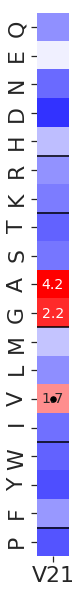


#----------------------------
HHH_rd4_0216 0.28269678376043056


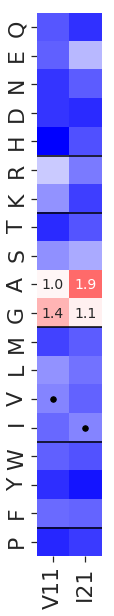


#----------------------------
HHH_rd4_0284 -0.2182962820438385


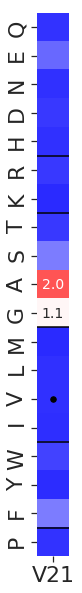


#----------------------------
HHH_rd4_0628 0.2944082853016752


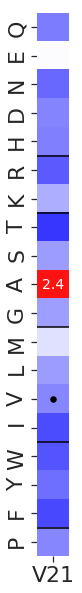


#----------------------------
HHH_rd4_0636 0.2754575758179148


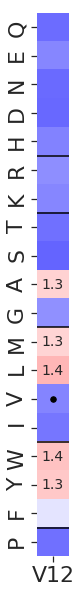

In [52]:
# Get data from the SSMs
data = stability_scores_df[
    (stability_scores_df['group'] == 'SSM')
].copy()

# Plot data for each SSM individually
stabilityscore_metric = 'stabilityscore_avg'
outputdir = os.path.join(resultsdir, 'ssm_plots')
if not os.path.isdir(outputdir):
    os.makedirs(outputdir)
parent_names = sorted(list(sites_to_plot.keys()))
for parent_name in parent_names:
    
#     if '0636' not in parent_name:
#         continue
    
    # Get the stability score of the parent design
    wt_stabilityscore = data[
        data['name'] == '{0}_wt'.format(parent_name)
    ][stabilityscore_metric][0]
    
    # Get data for the SSM for the parent design
    print("\n#----------------------------")
    print(parent_name, wt_stabilityscore)
    data_i = data[
        (data['parent_name'] == parent_name) &
        (data['site_n'].notnull())
    ].copy()
    data_i['site_n'] = data_i['site_n'].astype('int32')
    data_i['aa'] = data_i['mut_aa']
    
    site_ns = sites_to_plot[parent_name]
    data_i = data_i[data_i['site_n'].isin(site_ns)]
    
    # For each site in the protein, add a row corresponding to the
    # parent amino acid with the parent stability score (in the
    # original dataframe there is only one row for the parent design)
    sites_and_wt_aa = []
    for site_n in sorted(list(set(data_i['site_n']))):
        wt_aa = list(set(data_i[data_i['site_n'] == site_n]['wt_aa']))
        assert len(wt_aa) == 1
        wt_aa = wt_aa[0]
        sites_and_wt_aa.append((site_n, wt_aa))
        df = pandas.DataFrame({
            'site_n' : [site_n],
            'aa' : [wt_aa],
            stabilityscore_metric : [wt_stabilityscore]
        })
        data_i = pandas.concat([data_i, df], sort=False)
    
    # Turn data into a matrix for plotting
    data_i = data_i.pivot_table(
        index=['aa'], columns='site_n', values=[stabilityscore_metric]
    )
    data_i.columns = data_i.columns.droplevel().rename(None)

    # Plot data
    sites = [site for (site, wt_aa) in sites_and_wt_aa]
    xticklabels = [
        '{0}{1}'.format(wt_aa, site)
        for (site, wt_aa) in sites_and_wt_aa
    ]
    plt.figure(
        figsize=[(25/43)*len(site_ns),10]
    )
    aas = list('QENDHRKTSAGMLVIWYFP')
    annot_df = data_i.loc[aas].copy()
    for col in annot_df.columns.values:
        annot_df[col] = annot_df[col].apply(
            lambda x: '' if x < 1.0 else str(round(x, 1))
        )
    g = sns.heatmap(
        data_i.loc[aas], cmap='bwr', cbar=False,
        vmin=-0.5, vmax=2.5,
        xticklabels=xticklabels,
        annot=annot_df.to_numpy(),
        fmt='s', annot_kws={
            'size':14,
            'horizontalalignment':'center',
            'verticalalignment':'center'
        }
    )
    g.set_facecolor('k')

    # ... add horizontal lines to indicate groups of amino acids
    plt.plot([0,max(sites)],[5,5],color='black')
    plt.plot([0,max(sites)],[7,7],color='black')
    plt.plot([0,max(sites)],[11,11],color='black')
    plt.plot([0,max(sites)],[15,15],color='black')
    plt.plot([0,max(sites)],[18,18],color='black')
    
    # ... add dots indicating the wildtype amino acid at each site
    for (i, (site_n, wt_aa)) in enumerate(sites_and_wt_aa):
        #i = site_n - 1
        plt.scatter(
            i + 0.5, aas.index(wt_aa) + 0.5, s=30, color='black'
        )
    
#     cax = plt.gcf().axes[-1]
#     cax.plot(
#         [-1,2], [wt_stabilityscore,wt_stabilityscore],
#         color='black', linewidth=3
#     )
    #plt.title(parent_name, rotation=45)
    if False:
        plt.text(
            0.2, -6.5, parent_name,
             horizontalalignment='left',
             rotation=90,
             fontsize=25
        )
    plt.ylabel('')
    outfile = os.path.join(outputdir, '{0}.pdf'.format(parent_name))
    plt.savefig(outfile)
    plt.show()

Make above plots, but showing delta stability score instead of raw stability score.


#----------------------------
HHH_rd4_0068 0


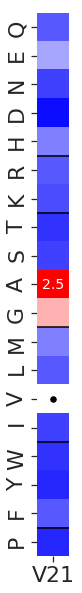


#----------------------------
HHH_rd4_0216 0


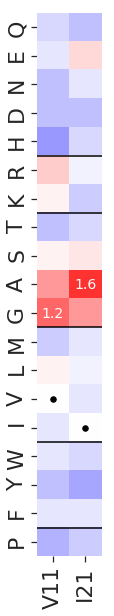


#----------------------------
HHH_rd4_0284 0


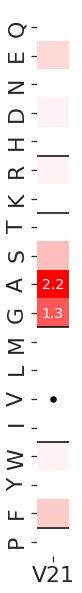


#----------------------------
HHH_rd4_0628 0


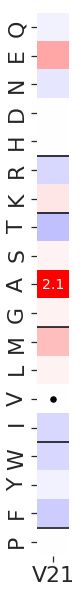


#----------------------------
HHH_rd4_0636 0


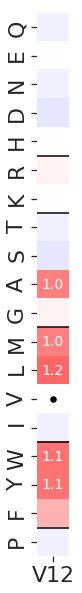

In [53]:
# Get data from the SSMs
data = ssm_data[
    (ssm_data['group'] == 'SSM')
].copy()

# Plot data for each SSM individually
stabilityscore_metric = 'delta_stabilityscore'
outputdir = os.path.join(resultsdir, 'ssm_plots')
if not os.path.isdir(outputdir):
    os.makedirs(outputdir)
parent_names = sorted(list(sites_to_plot.keys()))
for parent_name in parent_names:
    
    # Get the stability score of the parent design
    wt_stabilityscore = 0
    
    # Get data for the SSM for the parent design
    print("\n#----------------------------")
    print(parent_name, wt_stabilityscore)
    data_i = data[
        (data['parent_name'] == parent_name) &
        (data['site_n'].notnull())
    ].copy()
    data_i['site_n'] = data_i['site_n'].astype('int32')
    data_i['aa'] = data_i['mut_aa']
    
    site_ns = sites_to_plot[parent_name]
    data_i = data_i[data_i['site_n'].isin(site_ns)]
    
    # For each site in the protein, add a row corresponding to the
    # parent amino acid with the parent stability score (in the
    # original dataframe there is only one row for the parent design)
    sites_and_wt_aa = []
    for site_n in sorted(list(set(data_i['site_n']))):
        wt_aa = list(set(data_i[data_i['site_n'] == site_n]['wt_aa']))
        assert len(wt_aa) == 1
        wt_aa = wt_aa[0]
        sites_and_wt_aa.append((site_n, wt_aa))
        df = pandas.DataFrame({
            'site_n' : [site_n],
            'aa' : [wt_aa],
            stabilityscore_metric : [wt_stabilityscore]
        })
        data_i = pandas.concat([data_i, df], sort=False)
    
    # Turn data into a matrix for plotting
    data_i = data_i.pivot_table(
        index=['aa'], columns='site_n', values=[stabilityscore_metric]
    )
    data_i.columns = data_i.columns.droplevel().rename(None)

    # Plot data
    sites = [site for (site, wt_aa) in sites_and_wt_aa]
    xticklabels = [
        '{0}{1}'.format(wt_aa, site)
        for (site, wt_aa) in sites_and_wt_aa
    ]
    plt.figure(
        figsize=[(25/43)*len(site_ns),10]
        #figsize=[10,10]
    )
    aas = list('QENDHRKTSAGMLVIWYFP')
    annot_df = data_i.loc[aas].copy()
    for col in annot_df.columns.values:
        annot_df[col] = annot_df[col].apply(
            lambda x: '' if x < 1.0 else str(round(x, 1))
        )
    g = sns.heatmap(
        data_i.loc[aas], cmap='bwr', cbar=False,
        vmin=-2, vmax=2, #linewidths=0.01, linecolor='black',
        cbar_kws={
            'label': '$\Delta$ stability score',
            "ticks": np.arange(-2, 3, 1)
            #"shrink": 1e2
        },
        xticklabels=xticklabels,
        annot=annot_df.to_numpy(),
        fmt='s', annot_kws={
            'size':14,
            'horizontalalignment':'center',
            'verticalalignment':'center'
        }
    )
    g.set_facecolor('k')

    # ... add horizontal lines to indicate groups of amino acids
    plt.plot([0,max(sites)],[5,5],color='black')
    plt.plot([0,max(sites)],[7,7],color='black')
    plt.plot([0,max(sites)],[11,11],color='black')
    plt.plot([0,max(sites)],[15,15],color='black')
    plt.plot([0,max(sites)],[18,18],color='black')
    
    # ... add dots indicating the wildtype amino acid at each site
    for (i, (site_n, wt_aa)) in enumerate(sites_and_wt_aa):
        #i = site_n - 1
        plt.scatter(
            i + 0.5, aas.index(wt_aa) + 0.5, s=30, color='black'
        )
    
#     cax = plt.gcf().axes[-1]
#     cax.plot(
#         [-1,2], [wt_stabilityscore,wt_stabilityscore],
#         color='black', linewidth=3
#     )
    #plt.title(parent_name, rotation=45)
    if False:
        plt.text(
            0.2, -6.5, parent_name,
             horizontalalignment='left',
             rotation=90,
             fontsize=25
        )
    plt.ylabel('')
    outfile = os.path.join(outputdir, '{0}.pdf'.format(parent_name))
    plt.savefig(outfile)
    plt.show()

**Observations**:

**EEHEE_rd3_1267**:
* rescuing mutations are from Ns on loops to a hydrophobic aromatic -> aggregation?

**EEHEE_rd4_0215**:
* M3V: seems like M is clashing pretty badly with some of the surrounding atoms
* A18M: seems like there might actually be a cavity where M could get out of the core!

**EHEE_rd4_0144**:
* Aggregation prone?
* K20->hydrophobic: makes sense since K is at the boundary

**Observations**

**HHH_rd1_0972**
* Two of the helices seem abnormally close. Is this a concern?
* A4D: help remodel helix and balance helical dipole?
* R5L: makes sense: polar at boundary rescued by hydrophobic
* K9: all mutations except K increase stability (assuming that the stability of the WT design is lower than measured), suggesting that removing the positive charge is important, which might make sense since it is a region with a high density of positive charges; aliphatic hydrophobics increase stability the most, which makes sense because they can pack in the core
* R10: all mutations including to K increase stability (making the above assumption). Would say this is also related to reducing the postive charge in this region, except that K appears to be tolerated.
* A11P and I38S: remodeling of helix?

**HHH_rd1_0649**
* E2D/E4D: not sure why. Capping of helix to allow more flexibility?
* R18N: capping?
* K22R and R23K: not sure
* A24: to bulkier hydrophobic (except V)
* E25: makes sense: rescued by bulkier hydrophobic
* A39STK: some kind of remodeling of helix?

**HHH_rd1_0192**
* Big void in the center of this protein. The few rescue mutations don't really make much sense. Might not be rescuable if the apparent rescuing mutations are noise.
* I21T very confusing? Not V? A38Q? These must reshape the structure somehow yes?

**HHH_rd4_0628**
* K2 EDPFWST: E and D would help balance the helical dipole. E and P might remodel the helix
* K6 and R8: hydrophobic mutations at boundary make sense
* A9: bulkier hydrophobics rescue, helping to fill area with small voids, but would still require substantial remodeling
* E11V: interesting, not sure why this would help
* E18 makes sense
* V21A: relieves clashing?
* R26T: not sure why this helps
* V30FWY: more buried NPSA? Also L helps a little?

**HHH_rd1_0501**
* P1 is interesting; not sure why P is bad. Hydrophobics could be leading to aggregation
* D4WM: aggregation? rearragement?
* N8: not sure why R is so stabilizing. Gabe thinks it might be related to helical propensity.
* K10: rescued by hydrophobics makes sense since it is at the boundary.
* K11: a bit confusing. This is a surface residue and mutations to hydrophobics wouldn't pack in core.
* Why no stabilizing mutations at K39?

**HHH_rd4_0998**
* E2 and K3: to Y and W. Surface exposed. K3 could increase buried NPSA. Maybe both result in cation-pi stacking? Then why not F?
* V11F: require remodeling? V bad due to low helical propensity? Looks like it might be clashing with surroundings
* D18W/Y: aggregation? opportunity for cation-pi interaction with K43?
* E24FYW: buried NPSA? aggregation? cation-pi with nearby R?
* V30LFYW: buried NPSA
* D32H: not sure what is going on here
* K39IL: buried NPSA
* K43N: no idea, but interesting because it has the largest effect. Could it be related to helix capping at the C-term? Maybe it's just a one-off error.

**HHH_rd4_0838**
* This design is stable in this experiment. But nearly all of the mutants in the SSM are unstable, suggesting that the original design might also be unstable.
* D1N: confusing
* K6: hydrophobics increase buried NPSA
* I12: minor backbone clash with D17 bb oxygen atom? really interesting that most mutations are tolerated here, except for branched hydrophobics, which might be because V would involve the same clash? Not sure about L; maybe there's not space for it either.
* 12-16: mutations to proline; interesting if it prmotes a loop here. Are there clashes in the current design? Maybe changing the loop helps relieve clashing?
* K14 and R15: everything here is stable. Not sure why as these sites are surface-exposed. Is the starting design actually stable?
* E18: mutations to small hydrophobics result in more buried NPSA
* R22N: allows helix to start earlier? could relate to the proline mutations from above.
* V30A: relieves clashing? Maybe the mutations that might remodel the loop at the other end of the protein could help relieve this too?

**HHH_rd4_0821**
* N14A: a bit confusing. Maybe helps promote helical propensity
* E20R: a bit confusing. Why R? Why not any other amino acids?
* N30D: Maybe interacts favorably with nearby K and the two nearby N-terminal helical dipoles. Why not E?

**HHH_rd2_0120**
* E7L is confusing, maybe helps some transient oligomerization? Or there's something about the salt bridges that is actually bad and needs to be broken up? But then why not A? Actually even if this helps oligomerize, why is it so specific to L?
* R8F and R22 makes total sense
* V9N is confusing, would this remodel the protein?
* Interesting that lots of things are better at R22, T34, A35, K36, although nothing is quite good enough to move stabilityscore past 1.

**HHH_rd2_0184**
* What is Y5S about? Breaking helix?
* K6L makes sense
* A9H is confusing, does this remodel the protein?
* L13K and K14R are very confusing
* K22E: helps balance out helical dipole?
* A25Y/L makes sense but would remodel the protein
* S31H - what is this about?? Very confusing. Gabe thinks that the counts actually look somewhat confusing too. Though, they stay high throughout in both proteases. Could be worth looking into. His can cap helices. Maybe it is helping with that.

**HHH_rd4_0068**
* I don't believe this design is actually stable given how many surface mutations are not tolerated.
* K6, R8, and A9 to hydrophobic all makes sense
* K14 and R15 to anything are very interesting- since Helix 1 hardly contains any hydrophobics, maybe putting hydrophobics at these positions allows helix 1 to become an extended coil that packs against the other two helices? Maybe this helps relieve clashing with 
* E18 to hydrophobic makes total sense
* V21G/A is amazing, especially how high the stability goes! This is just like the other designs where we saw this! Actually, V21A has the highest rd6_c counts and 2nd highest rd6_t counts of anything in the set. Appears to clash with V13.
* The mutations at V30 make sense
* R37A is pretty interesting, this would be nice to understand. Is the net charge of this design very positive? No, it's actually slightly negative (-1), so getting rid of positive charge isn't too important.
* V42W also interesting. Any opportunity for cation-pi stacking?

**HHH_rd4_0216**
* R3: L gives more buried NPSA?
* A4: I/L give more buried NPSA
* K8: hydrophobics give more buried NPSA; same as other cases
* V11G/A: very cool! V11 clashes with backbone and I21
* I21G/A/S: is very cool! Same position as the other cases
* I38S: is peculiar, I wonder if this bends the helix? The part above the bend interacts with the part of the protein with clashing. Maybe bending this helps relieve the clashing
* L39E: is very strange- what is this about?

**EHEE_rd4_0810**
* What explains K20A? Is K20 blocking oligomerization? But then why isn't K20F even better?
* E21 L/M is confusing. Is the helix somehow rotated so that K20 wants to point to the core and E21 wants to touch V26?
* N23F is confusing as well. Actually none of these mutations (Y35E, A39Q) really make much sense.
* Y35E: does the E H-bond with the backbone?

**EHEE_rd4_0144**
* This design was stable in this experiment. But, I'm not sure that makes sense based on the SSM data, as many mutations at surface-exposed sites have much lower stability (e.g., R1, K17). Though, Gabe thinks that this could be consistent with a stable design.
* K20: multiple hydrodrophobic mutations increase stability -> rearragenement?
* A39WFIL: more buried NPSA, but large rearragenement?

**EHEE_rd4_0570**
* K13E also kind of confusing?
* G33M: I would love to understand what G33M is doing here! It's a bit weird that only M is tolerated, not L or F or anything else? Is this believable? I thought maybe this was some weird artifact of the unfolded state model, but the EC50s (and counts) are very clear too.

**EHEE_rd4_0152**
* Lots of voids in this structure
* E2: makes sense: boundary polar rescued by hydrophobic
* A19K: very confusing. related to protease susceptibility? Help with balancing out helical dipole?

**EEHEE_rd3_1267**
* bb H-bonding doesn't look very good between middle strands
* T8S: awkward T rotamer?
* A18L: would help increase buried NPSA in region that has small voids, but would probably require a large rearrangement.
* V19D: help with balancing out helical dipole and nearby positive charges (there are many Ks on this helix)? If so, why not E? Gabe thinks it could remodel the helix by capping it in the middle.
* N30W: aggregation? cation-pi with nearby Ks?

**EEHEE_rd4_0215**
* K1: makes sense: at boundary, rescued by hydrophobics
* R2GV: not sure why G would rescue; V makes sense
* M3VI: looks like M might class with surroundings (e.g., A22, I40 sc and bb O)
* H4: Interesting that ILF would rescue, but not other hydrophobics, especially V
* N6: like H4
* F12M: not sure why this would rescue. Some kind of rearragement?
* A18M: might add more buried NPSA. Why not Ile? Met only hydrophobic that could fit?
* K20W: surface hydrophobic
* Q28G: loop remodeling?
* Y29W: not sure!
* I40M: might be clashing with nearby M3
* I42A/N: I might clash with V5 in a way that only A could rescue (among hydrophobic alternatives). Not sure how N works.
* E43S: not sure. Why not T or A?
* Gabe's thoughts: A18M is consistent with the idea that the strand is too far from the helix with M3V, either helix needs to be bigger (A18M) or strand smaller (M3V), I40M is also consistent with the helix and strands not touching well enough

**EEHEE_rd4_0464**
* Harder to rescue
* T1: makes sense: boundary polar rescued by hydrophobics (interesting that V doesn't rescue; due to minor clash of branching carbon?)
* V3: weak effect, but may be related to relieving clashing
* M18A: looks like M might be clashing with multiple other residues
* V19E and F12E: not sure why. To balance out helical dipole? V might be helping with helical propensity or clashing with neighboring F
* A22I/L: makes sense: A has small voids around it. Interesting that V isn't tolerated. Due to strand propensity?
* V25W: not sure why. Aggregation? Opportunity for pi-pi or cation pi stacking?
* E34I/M: on surface. buried NPSA?
* T39P/F: P could remodel the loop, not sure about F
* V40N and E43I: not sure

**We observed multiple different types of rescuing mutations**

* Charged amino acids at boundary rescued by hydrophobics
    * Expected from past data because would add more buried NPSA
    * See this pattern in many different contexts, including at many different sites and with all four charged amino acids
    * Despite those amino acids making salt bridges that could, in theory, help stabilize the structure -> is Rosetta placing too much value on salt bridges?
    * Sometimes see specificity in the hydrophics that can rescue, indicating that structural context is important
        * e.g., V not rescuing in helices
        * e.g., HHH_rd1_0972 (R5L)
    * How test computationally?
        * forward folding, fragment sampling, ddG
            * see if mutants have lower energy (old and new energy functions). Could compare fa_sol, fa_elec, etc.
            * seems like these results would be pretty clear, though it's possible that some of these structures undergo large re-arrangements to relieve clashing, for instance.
    * How test experimentally?
        * CD, structure?
    * How change design protocol?
        * might be due to layer constraints. After one or more rounds of design, re-define layers using a SASA-based approach.
    * e.g.:
        * HHH_rd4_0216 (K8, R9)
        * HHH_rd4_0284 (K6)
        * HHH_rd2_0120 (D2, R8, R22)
        * HHH_rd4_0838 (K6, E18)
        * HHH_rd4_0998 (E24, K39)
        * HHH_rd1_0501 (K10)
        * HHH_rd4_0628 (K6, R8)
        * HHH_rd4_0628 (E18)
        * HHH_rd1_0649 (E25)
        * HHH_rd1_0972 (R5L)
        * EEHEE_rd4_0215 (K1)
        * EHEE_rd4_0152 (E2)

* Small hydrophobic rescued by larger hydrophobics.
    * Expected from past data because would add more buried NPSA. Though, it's notable that structures are able to rearrange to accomodate these mutations.
        * How much remodeling is required? Is it too big of a move for FastRelax to find?
    * See pattern in many different contexts (sites, rescuing amino acids, topologies)
    * Sometimes see specificity in which hydrophobics can rescue, indicating that structural context is important
        * e.g., sometimes V doesn't rescue in helices
        * e.g., sometimes just one resicues (e.g., M)
    * How test computationally?
        * forward folding, fragment sampling, ddG
            * large-scale remodeling might be required
    * How test experimentally?
    * e.g.:
        * HHH_rd4_0216 (A4)
        * HHH_rd4_0068 (A9, V30LFYW)
        * HHH_rd2_0120 (A21, A25; kind of rescued for both)
        * HHH_rd4_0838 (A21V; small effect?)
        * HHH_rd4_0998 (V30LFYW)
        * EEHEE_rd3_1267 (A18L)
        * HHH_rd4_0628 (A9, V30FYW)
        * EEHEE_rd4_0215 (A18M; interestingly other hydrophobics don't rescue; M might be only rescue mutation because of geometry)
        * EEHEE_rd4_0464 (A22I/L)
        * HHH_rd1_0649 (A24 other hydrophobics except V)
    
* Bulky hydrophobics that clash with surroundings rescued by mutations to smaller amino acids (mostly A and G, but not always)
    * Really interesting pattern that is not expected from previous data.
    * Occurs in multiple structural contexts, though also repeats in specific ones too, such as V21 and V11
    * e.g.:
        * HHH_rd4_0284 (V21)
        * HHH_rd4_0216 (V11, I21)
        * HHH_rd4_0068 (V21)
        * HHH_rd4_0838 (V30A; small effect? proline mutations at other side of protein help relieve this?)
        * HHH_rd4_0998 (V11A; small effect?)
        * HHH_rd4_0628 (V21A)
        * EEHEE_rd4_0215 (M3VI, I42A, I40M; M3 and I40 clash? Interesting because M might be the only rescue mutation given the geometry)
        * EEHEE_rd4_0464 (M18A, T1AFILYW, NOT T1V due to beta branching?)
        
* Bending helix? Or remodeling / promoting loop somehow?
    * e.g.:
        * HHH_rd2_0184 (Y5S)
        * HHH_rd4_0216 (I38S)
        * HHH_rd4_0838 (proline at sites 11-15, R22N; helps relieve clashing at other end of protein?)
        * EEHEE_rd3_1267 (V19D)
        * HHH_rd4_0628 (K2E/P)
        * EEHEE_rd4_0215 (Q28G)
        * EEHEE_rd4_0464 (T39P)
        * HHH_rd1_0972 (A11P, I38S)
        
* Mutations would require large remodeling protein?
    * e.g.:
        * HHH_rd2_0184 (A25Y/L)
        * EHEE_rd4_0144 (K20 -> hydrophobic, A39WFIL)
        * HHH_rd4_0998 (V11F)
        * HHH_rd1_0501 (K11 -> hydrophobics and few other things)

* Charge switch or removal of charge
    * e.g.:
        * HHH_rd2_0184 (K22D)
        * HHH_rd2_0120 (K36, K40; seak effects; in region with high density of positively charged residues; R and H also disfavored for K36; could be worth mutating both at once?)
        * EHEE_rd4_0570 (K13E)
        * HHH_rd4_0628 (K2E/D)
        * HHH_rd1_0649 (R18N: capping?)

* Addition of charge:
    * e.g.:
        * EEHEE_rd3_1267 (V19D): help to balance out helical dipole and other nearby positive charges (there are many on this helix).
        * EEHEE_rd4_0464 (F12E, V19E): interesting that V19 showed up again
        * HHH_rd1_0972 (A4D)

* Any other amino acid is preferable -> indicates removal of something that is highly deleterious
    * e.g.: (need to update list)
        * HHH_rd4_0216 (R9)
        * HHH_rd1_0972 (K9 to anything but R, reducing density of positive charges?; R10)
        * HHH_rd4_0068 (K14, R15)
        * HHH_rd4_0838 (K14, R15)

* Opportunity for pi-pi or cation-pi interaction?
    * e.g.:
        * HHH_rd4_0998 (D18W/Y, E24FYW)
        * EEHEE_rd3_1267 (N30W)
        * EEHEE_rd4_0464 (V25W)

* Surface hydrophobics
    * e.g.:
        * EEHEE_rd4_0215 (first strand, K20W)
        * EEHEE_rd4_0464 (E34I/M)

* Confusing. Not sure.
    * e.g.:
        * HHH_rd2_0184 (S31H)
        * EHEE_rd4_0810 (K20A, E21 L/M, N23F, A39Q)
            * Y35E: Does the E H-bond to the backbone?
        * HHH_rd2_0120 (E7L, V9N)
        * HHH_rd4_0821 (N14A - maybe the alanine helps with promoting local helical propensity, E20R)
        * EHEE_rd4_0144 (K20L)
        * EHEE_rd4_0570 (G33M)
        * HHH_rd4_0838 (D1N)
        * HHH_rd4_0998 (E2 and K3; K3 might be buried NPSA)
        * HHH_rd4_0998 (D32H)
        * HHH_rd4_0998 (K43N)
        * HHH_rd1_0501 (D4WM, N8R)
        * EEHEE_rd3_1267 (T8S)
        * EEHEE_rd3_1267 (N30W)
        * HHH_rd4_0628 (E11V)
        * HHH_rd4_0628 (R26T)
        * EEHEE_rd4_0215 (R2G, F12M, Y29W, I42N, E43S)
        * EEHEE_rd4_0464 (V40N)
        * EHEE_rd4_0152 (A19K)
        * HHH_rd1_0192 (I21T, A38Q)
        * HHH_rd1_0649 (E2D/E4D, K22R/R23K, A39STK)

**Big-picture take aways**
* How many proteins were rescuable?
    * Nearly all, except maybe not HHH_rd1_0192 depending on whether the apparent signal is real
* How many rescue mutations were there per protein?
    * Mutations often spanned multiple different sites and involved multiple different patterns (e.g., polar -> hydrophobic; big -> small; small -> big)
* How many ways are there to rescue proteins?
    * Many different ways, and most of these ways occur in many different structural contexts: different sites, WT/mutant amino acids
    * Some are expected from past data, e.g., more buried NPSA
    * Some are not expected from past data, e.g., clashing
    
* How often do the mutations result in small-scale vs. large-scale rearrangements?

    * Bulky hydrophobic mutating to Ala/Gly, relieving apparent clash
        * Forward folding (dual space relax at end)
        * Come up with a pipeline to compute fa_rep at each position in the protein. Run all designs through this pipeline. This might help identify regions where mutations in or away from that region help relieve clashing. Also run all designs/mutants as modeled by forward folding. Would be interesting to see if this typically goes down.
        * Do this after dual-space relax?
        * Also do this will all inter-atomic distances in case fa_rep has inaccuracies in the atomic radii being used?
    * Remodeling
        * Do these mutations help relieve clashes?

* Can we use this information to improve our predictive models?
    * Why did our models think that these designs should be stable?
    * What can we change in our models

* Can we use this information to improve design protocols?
    * Why weren't rescue mutations identified during design?
        * layer definitions
        * large-scale remodeling required. Too much for FastDesign to find? If so, are there other protocols that could be incorporated during design?
            * mutations from alanine to a bulkier hydrophobic
            * other mutations that require remodeling
        
    * Design using dual-space relax protocol
    * After each round of FastDesign, re-define surface/core/boundary using a SASA-based cutoff (use RSA? Frank's approach of mutating everything to alanine and drawing an absolute cutoff based on that?)
    * Don't allow large patches of hydrophobics on the surface?

* Can we rescue other designs through the principles we've learned?

**To do**
* Ways to test the effects of mutations computationally (going from zero remodeling to complete remodeling)
    * Re-score with old and new score function
    * Forward folding
        * With old and new score function
    * ddG protocol
    * fragment sampling from designed structure
* Ways to test the effects of mutations experimentally
    * Individual clones
    * 96-well plate and CD?
    * HDX assay? Or are proteins too similar?


* Code to compute clashing
    * Atomic radii correct?
    * Do this for all designs? And all designs from nature? Then compare? How close is too close?
* Code to compute voids
    * Some structures appear to have a lot of voids, e.g., EHEE_rd4_0152 and HHH_rd1_0192

**Questions for Gabe**
* Thoughts on HHH_rd4_0838? Is it stable? I though this one was interesting because of the proline mutations and the possible clashing at V30. Could these effects be related?
* Thoughts on HHH_rd4_0998?
* What is the expected frequency of one-off rescuing mutations due to noise?
    * Possible sequencing errors?
    * In the future, should include variants with mutations to stop codons
    * Could compute distributions of rescuing effects for each amino acid. Proline would be expected not to rescue very much. That could be used as a null distribution.
* Do vdw radii change when have a VDW int between a polar and non-polar atom (e.g., O - H-C) vs. two non-polar atoms?
    * atomic radii in Rosetta correct?

In [12]:
design = 'HHH_rd2_0184'
mutation = 'S31H'
name = '{0}_{1}'.format(design, mutation)
data = stability_scores_df[
    stability_scores_df['name'] == name
].copy()
for p in ['t', 'c']:
    counts_cols = ['counts{0}_{1}'.format(i, p) for i in range(7)]
    counts_cols = ['name'] + counts_cols
    display(data[counts_cols])

KeyError: "['counts4_t', 'counts2_t', 'counts3_t', 'counts6_t', 'counts1_t', 'counts5_t', 'counts0_t'] not in index"

**List of proteins for Jack to analyze**

* HHH_rd4_0068
    * V21G/A
    * V30L/F/Y/W

* HHH_rd2_0184
    * A25Y/L

* HHH_rd4_0216
    * A4I/L
    * K8L
    * V11G/A
    * I21G/A/S

* HHH_rd4_0284
    * V21A
    * K6L
    * compare to: HHH_rd4_0626
    
* HHH_rd1_0501
    * K11 -> hydrophobics
    
* HHH_rd4_0628
    * K6W/L/M
    * R8W/L
    * A9I/V/L/M
    * E18 -> anything hydrophobic
    * V21A
    
* HHH_rd4_0636
    * V12A/L
    * K6L

* HHH_rd4_0998
    * V11F
    * V30F/Y/W/L

* EHEE_rd4_0152
    * E2I/L/V/M/F/W
    
* EEHEE_rd4_0215
    * M3V
    * I40M
    
    
* Big to small: 4
* Small to big: 3
* Charged to hydrophobic: 6

## Analyze proteins using PyRoestta

In [24]:
import pyrosetta
import pyrosetta.rosetta
from pyrosetta.rosetta.core.scoring.hbonds import HBondSet, fill_hbond_set
pyrosetta.init('-beta_nov16 -mute all -mute core -mute protocols')

# Set up a score function in `PyRosetta`
sf = pyrosetta.get_fa_scorefxn()
def fix_scorefxn(sfxn, allow_double_bb=False):
    opts = sfxn.energy_method_options()
    opts.hbond_options().decompose_bb_hb_into_pair_energies(True)
    opts.hbond_options().bb_donor_acceptor_check(not allow_double_bb)
    sfxn.set_energy_method_options(opts)
fix_scorefxn(sf)

In [25]:
def compute_lj_energy(e, o, d):
    energy = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6))
    return energy

def compute_rosetta_lj_energy(e, o, d, rep_weight=1.0):
    if d < 0.6*o:
        return np.nan
    elif 0.6*o < d <= o:
        atr = -e
        rep = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6) + 1)
    elif d < 4.5:
        atr = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6))
        rep = 0
    else:
        return np.nan
    
    energy = atr + (rep * rep_weight)
    return energy

In [26]:
def compute_pairwise_energies(pose, res_i_n, atom_i_n, sf):
    """
    Compute pairwise energies between an input atom and all others
    
    Args:
        *pose*: a PyRosetta pose
        *res_i_n*: the number of the input residue
        *atom_i_n*: the number of the input atom on the input residue
        *sf*: the score function used to compute energies
        
    Returns:
        A dataframe where rows are pairwise interactions, and columns
            give metadata on the pair of atoms involved and their
            energies
    """
    
    # Initiate a dictionary to record data
    energies_dict = {
        key : []
        for key in [
            'res_j_n', 'res_j_name',
            'atom_j_n', 'atom_j_name',
            'lj_atr', 'lj_rep', 'fa_solv', 'fa_elec',
            'atom_j_lj_radius', 'atom_j_lj_wdepth',
            'd'
        ]
    }
    
    # Make an object corresponding to the input residue and get
    # the XYZ coordinates of the input atom
    res_i = pose.residue(res_i_n)
    atom_i_xyz = res_i.xyz(atom_i_n)
    
    # Record pairwise energies between the input atom and all other
    # atoms in the structure
    etable_atom_pair_energies = \
        pyrosetta.toolbox.atom_pair_energy.etable_atom_pair_energies
    for res_j_n in list(range(1, pose.size()+1)):
        res_j = pose.residue(res_j_n)
        for atom_j_n in list(range(1, res_j.natoms()+1)):
            
            # Skip res_j and atom_j if they are the same as the
            # input residue and atom
            if (res_j_n == res_i_n) and (atom_j_n == atom_i_n):
                continue

            # Compute pairwise energies between atoms i and j
            (lj_atr, lj_rep, fa_solv, fa_elec) = \
                etable_atom_pair_energies(
                    res1=res_i,
                    atom_index_1=atom_i_n,
                    res2=res_j,
                    atom_index_2=atom_j_n,
                    sfxn=sf
                )
            
            # Record data in dictionary
            atom_type_j = res_j.atom_type(atom_j_n)
            atom_j_xyz = res_j.xyz(atom_j_n)
            energies_dict['res_j_n'].append(res_j_n)
            energies_dict['res_j_name'].append(res_j.name3())
            energies_dict['atom_j_n'].append(atom_j_n)
            energies_dict['atom_j_name'].append(
                res_j.atom_name(atom_j_n)
            )
            energies_dict['lj_atr'].append(lj_atr)
            energies_dict['lj_rep'].append(lj_rep)
            energies_dict['fa_solv'].append(fa_solv)
            energies_dict['fa_elec'].append(fa_elec)
            energies_dict['atom_j_lj_radius'].append(
                atom_type_j.lj_radius()
            )
            energies_dict['atom_j_lj_wdepth'].append(
                atom_type_j.lj_wdepth()
            )
            energies_dict['d'].append(
                (atom_i_xyz - atom_j_xyz).norm()
            )
           
    # Convert the above dictionary into a dataframe
    energies_df = pandas.DataFrame(energies_dict)
    
    # Add information on the input residue and atom
    energies_df['res_i_n'] = res_i_n
    energies_df['res_i_name'] = res_i.name3()
    energies_df['atom_i_n'] = atom_i_n
    energies_df['atom_i_name'] = res_i.atom_name(atom_i_n)
    atom_type_i = res_i.atom_type(atom_i_n)
    energies_df['atom_i_lj_radius'] = atom_type_i.lj_radius()
    energies_df['atom_i_lj_wdepth'] = atom_type_i.lj_wdepth()

    # Compute values that characterize VdW interactions, including
    # the sum of atomic radii of atoms i and j (o)...
    energies_df['o'] = energies_df.apply(
        lambda row: row['atom_i_lj_radius'] + row['atom_j_lj_radius'],
        axis=1
    )
    
    #... the well depth, computed as the geometric mean of the wdepth
    # values for atoms i and j...
    energies_df['e'] = energies_df.apply(
        lambda row: math.sqrt(
            row['atom_i_lj_wdepth'] * row['atom_j_lj_wdepth']
        ),
        axis=1
    )
    
    # ... the LJ potential for atoms i and j...
    energies_df['lj_energy'] = energies_df.apply(
        lambda row: compute_lj_energy(row['e'], row['o'], row['d']),
        axis=1
    )
    
    # ... the LJ potential computed using Rosetta...
    energies_df['rosetta_lj_energy'] = energies_df.apply(
        lambda row: compute_rosetta_lj_energy(
            row['e'], row['o'], row['d'], rep_weight=1.0
        ),
        axis=1
    )
    
    # ... the LJ potential computed using Rosetta with a weight of
    # 0.55 on the repulsive term
    energies_df['weighted_rosetta_lj_energy'] = energies_df.apply(
        lambda row: compute_rosetta_lj_energy(
            row['e'], row['o'], row['d'], rep_weight=0.55
        ),
        axis=1
    )
    
    # Return the dataframe
    return energies_df

In [27]:
design = 'HHH_rd4_0216_V11A'
pdb = glob.glob(os.path.join(
    'results/abinitio_minima/',
    design,
    '*.pdb'
))
assert len(pdb) == 1
pdb_file = pdb[0]

pose = pyrosetta.pose_from_pdb(pdb_file)
res_n = 21
res = pose.residue(res_n)
atom_n = 14
atom_type = res.atom_type(atom_n)
atom_name = res.atom_name(atom_n)
atom_type_name = atom_type.atom_type_name()
print(atom_n, atom_name, atom_type_name)
df = compute_pairwise_energies(pose, res_n, atom_n, sf)
df['lj_rep_atr'] = df['lj_rep'] + df['lj_atr']
df = df[
    (df['res_j_n'] != res_n) &
    (df['lj_rep'] > 0)
]
print(
    sum(df['rosetta_lj_energy']),
    sum(df['weighted_rosetta_lj_energy'])
)
df

AssertionError: 

In [28]:
pdbs = ['HHH_rd4_0284', 'HHH_rd4_0626', 'HHH_rd4_0628', 'HHH_rd4_0068']
pdbs = ['HHH_rd4_0284' , 'HHH_rd4_0628', 'HHH_rd4_0216']
#pdbs = ['EEHEE_rd4_0215']
df_exists = False
for pdb in pdbs:
    pdb_file = os.path.join(
        '/home/haddox/2018/analyze_calibrated_stability_data/',
        'results/constrained_relax/beta_nov16/Rocklin_2017_Science/',
        f'{pdb}_0001.pdb'
    )
    pose = pyrosetta.pose_from_pdb(pdb_file)
    for res_i_n in range(1, pose.size()+1):
        res_i = pose.residue(res_i_n)
        res_i_name = res_i.name3()
        if res_i_name not in ['VAL', 'LEU', 'ILE', 'ALA', 'MET']:
            continue
        for atom_i_n in list(range(1, res_i.natoms()+1)):
            atom_i_name = res_i.atom_name(atom_i_n)
            if atom_i_name.strip() in ['N', 'C', 'CA', 'H', 'HA', 'O']:
                continue
            df = compute_pairwise_energies(pose, res_i_n, atom_i_n, sf)
            df['pdb'] = pdb
            if not df_exists:
                energies_df = df.copy()
                df_exists = True
            else:
                energies_df = \
                    pandas.concat([energies_df, df], sort=False)

# Remove duplicate entries in the dataframe where atom i == atom j
energies_df['pair_id'] = energies_df.apply(
    lambda row: '_'.join(sorted([
        row['pdb'],
        "{0}_{1}".format(row['res_i_n'], row['atom_i_n']),
        "{0}_{1}".format(row['res_j_n'], row['atom_j_n']),
    ])),
    axis=1
)
energies_df.drop_duplicates('pair_id', inplace=True, keep='first')

In [29]:
df = energies_df[
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df['lj_rep'] > 0)
].copy()
cols = [
    'pdb',
    'res_i_n', 'res_i_name', 'atom_i_name',
    'res_j_n', 'res_j_name', 'atom_j_name',
    'lj_rep', 'lj_atr', 'lj_energy'
]
df.sort_values('lj_rep', ascending=False, inplace=True)
df[df['pdb']=='HHH_rd4_0284'][cols].head(n=15)
#df[cols].head(n=15)

pdb  res_i_n res_i_name atom_i_name  res_j_n res_j_name  \
274  HHH_rd4_0284       21        VAL        3HG2       17        ASP   
718  HHH_rd4_0284       13        VAL        3HG1       42        VAL   
660  HHH_rd4_0284       39        LEU         CB        40        ARG   
65   HHH_rd4_0284       24        ILE         CG2        5        LEU   
162  HHH_rd4_0284       13        VAL        2HG1       10        GLU   
210  HHH_rd4_0284       21        VAL        1HG2       13        VAL   
641  HHH_rd4_0284       38        ILE         CB        39        LEU   
407  HHH_rd4_0284       24        ILE         CB        25        LEU   
349  HHH_rd4_0284       21        VAL         CB        22        ARG   
592  HHH_rd4_0284       35        ILE         CB        36        GLU   
224  HHH_rd4_0284       13        VAL         CG1       14        LYS   
724  HHH_rd4_0284       42        VAL         CB        43        LEU   
151  HHH_rd4_0284        9        ALA         CB        10        GLU   
738  HHH_rd4_0284       39        LEU        2HD2       43        LEU   
345  HHH_rd4_0284        9        ALA        1HB        21        VAL   

    atom_j_name    lj_rep    lj_atr  lj_energy  
274         O    0.782763 -0.055730   0.727033  
718        1HG1  0.650032 -0.021808   0.628224  
660         N    0.613522 -0.100652   0.512871  
65          O    0.546926 -0.094453   0.452473  
162         HA   0.531350 -0.021808   0.509542  
210         CA   0.514252 -0.036961   0.477291  
641         N    0.513773 -0.100652   0.413122  
407         N    0.504672 -0.100652   0.404021  
349         N    0.501296 -0.100652   0.400644  
592         N    0.499953 -0.100652   0.399301  
224         N    0.469798 -0.100652   0.369146  
724         N    0.468619 -0.100652   0.367968  
151         N    0.449764 -0.100652   0.349112  
738        1HD1  0.393786 -0.021808   0.371978  
345        3HG1  0.377023 -0.021808   0.355215

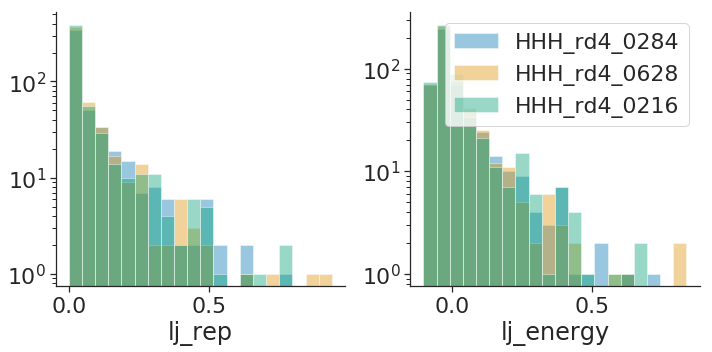

In [30]:
(fig, axs) = plt.subplots(ncols=2, figsize=[10,5])

nbins = 20
rep_step_size = (df['lj_rep'].max() - df['lj_rep'].min())/nbins
rep_bins = np.arange(
    df['lj_rep'].min(),
    df['lj_rep'].max() + rep_step_size,
    rep_step_size
)

energy_step_size = (df['lj_energy'].max() - df['lj_energy'].min())/nbins
energy_bins = np.arange(
    df['lj_energy'].min(),
    df['lj_energy'].max() + energy_step_size,
    energy_step_size
)

for pdb in pdbs:
    data = df[df['pdb'] == pdb]
    sns.distplot(
        data['lj_rep'], kde=False, ax=axs[0], label=pdb,
        bins=rep_bins
    )
    sns.distplot(
        data['lj_energy'], kde=False, ax=axs[1], label=pdb,
        bins=energy_bins
    )
for i in [0, 1]:
    axs[i].set(yscale='log')
axs[1].legend()
plt.tight_layout()
sns.despine()
plt.show()

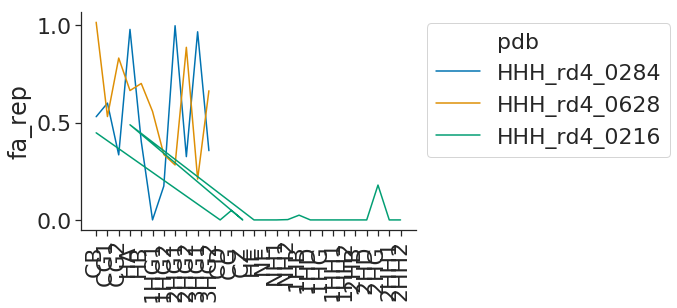

In [31]:
pdbs = [
    'HHH_rd4_0284', 'HHH_rd4_0628', 'HHH_rd4_0216'
]
res_n = 13
energies_dict = {
    key : []
    for key in [
        'pdb', 'res_n', 'atom_n', 'atom_name', 'fa_rep'
    ]
}
for pdb in pdbs:
    pdb_file = os.path.join(
        '/home/haddox/2018/analyze_calibrated_stability_data/',
        'results/constrained_relax/beta_nov16/Rocklin_2017_Science/',
        f'{pdb}_0001.pdb'
    )
    pose = pyrosetta.pose_from_pdb(pdb_file)
    res = pose.residue(res_n)
    for atom_n in list(range(1, res.natoms()+1)):
        atom_name = res.atom_name(atom_n)
        if atom_name.strip() in ['N', 'C', 'CA', 'H', 'O']:
            continue
        atom_type_name = res.atom_type(atom_n).atom_type_name()
        #print(atom_name, atom_type_name)

        df = compute_pairwise_energies(pose, res_n, atom_n, sf)
        energies_dict['pdb'].append(pdb)
        energies_dict['res_n'].append(res_n)
        energies_dict['atom_n'].append(atom_n)
        energies_dict['atom_name'].append(atom_name)
        energies_dict['fa_rep'].append(sum(df[
            (df['res_j_n'] != res_n)
        ]['lj_rep']))

energies_df = pandas.DataFrame(energies_dict)
sns.lineplot(
    y='fa_rep', x='atom_name', data=energies_df, hue='pdb'
)
plt.xticks(rotation=90)
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

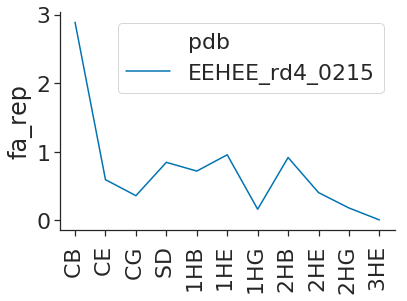

In [76]:
pdbs = ['EEHEE_rd4_0215']
res_n = 3
energies_dict = {
    key : []
    for key in [
        'pdb', 'res_n', 'atom_n', 'atom_name', 'fa_rep'
    ]
}
for pdb in pdbs:
    pdb_file = os.path.join(
        '/home/haddox/2018/analyze_calibrated_stability_data/',
        'results/constrained_relax/beta_nov16/Rocklin_2017_Science/',
        f'{pdb}_0001.pdb'
    )
    if False:
        pdb_file = os.path.join(
            '/home/haddox/2018/score_monomeric_designs/data/',
            'Rocklin_2017_Science/',
            f'{pdb}.pdb'
        )
    pose = pyrosetta.pose_from_pdb(pdb_file)
    res = pose.residue(res_n)
    for atom_n in list(range(1, res.natoms()+1)):
        atom_name = res.atom_name(atom_n)
        if atom_name.strip() in ['N', 'C', 'CA', 'HA', 'H', 'O']:
            continue
        atom_type_name = res.atom_type(atom_n).atom_type_name()
        #print(atom_name, atom_type_name)

        df = compute_pairwise_energies(pose, res, atom_n, sf)
        energies_dict['pdb'].append(pdb)
        energies_dict['res_n'].append(res_n)
        energies_dict['atom_n'].append(atom_n)
        energies_dict['atom_name'].append(atom_name)
        energies_dict['fa_rep'].append(sum(df[
            (df['res_n'] != res_n)
        ]['lj_rep']))

energies_df = pandas.DataFrame(energies_dict)
sns.lineplot(
    y='fa_rep', x='atom_name', data=energies_df, hue='pdb'
)
plt.xticks(rotation=90)
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [17]:
import sys
sys.path.append('scripts/')
import scoring_utils

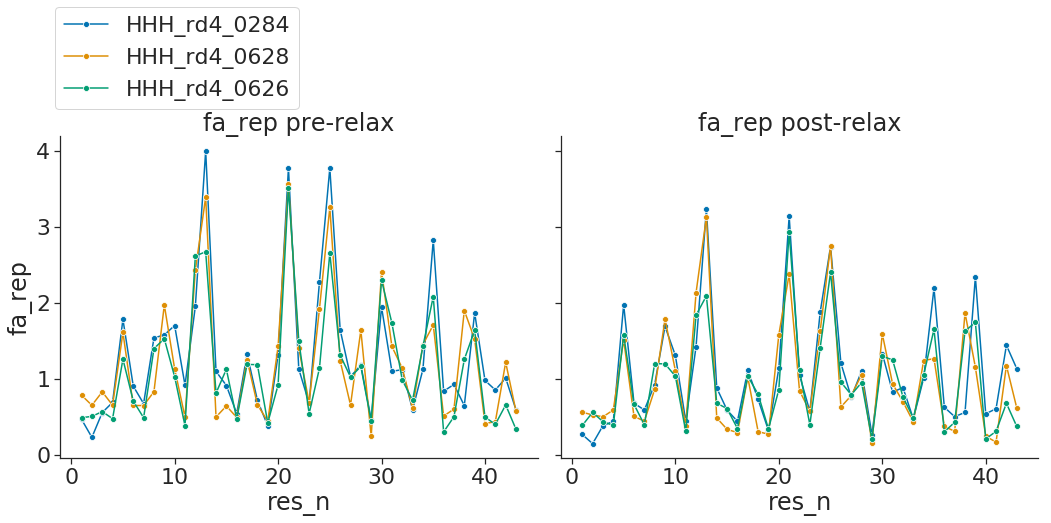

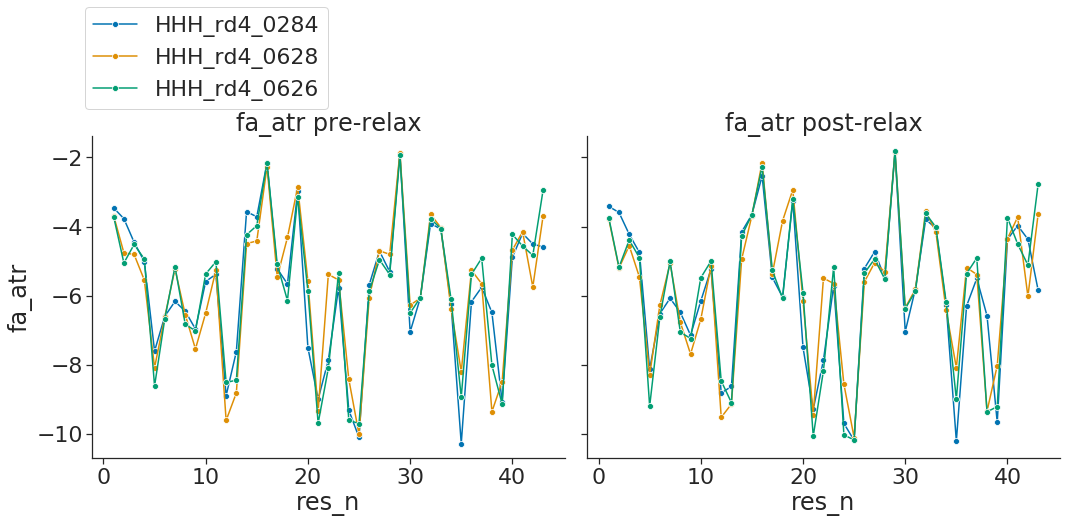

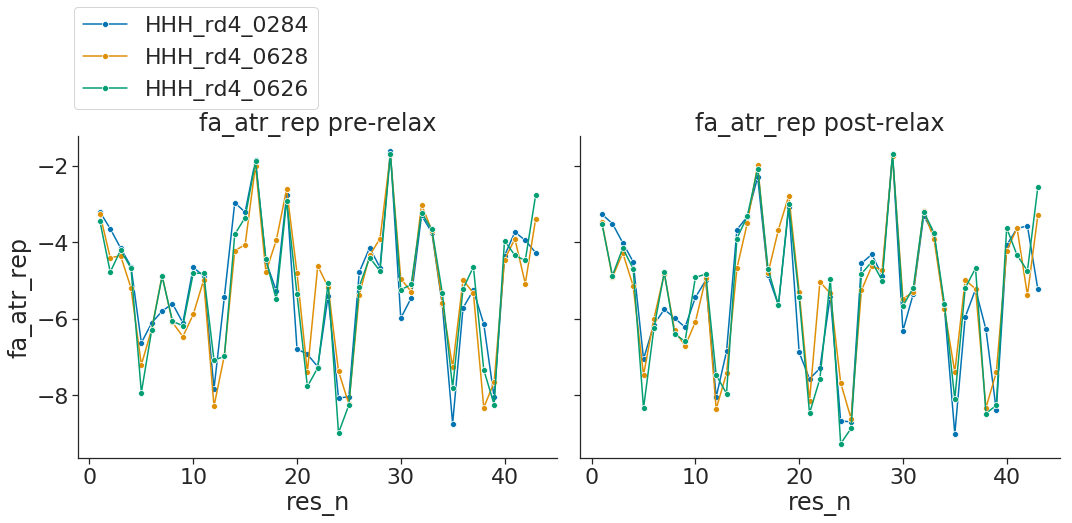

In [43]:
pdbs = ['HHH_rd4_0284', 'HHH_rd4_0626']
pdbs = ['HHH_rd4_0284', 'HHH_rd4_0628', 'HHH_rd4_0626']
#pdbs = ['EEHEE_rd4_0215']

energy_terms = ['fa_rep', 'fa_atr', 'fa_atr_rep']
for energy_term in energy_terms:

    # Before relax
    (fig, axs) = plt.subplots(ncols=2, figsize=[15,8], sharey=True)
    for pdb in pdbs:
        pdb_file = os.path.join(
            '/home/haddox/2018/score_monomeric_designs/data/',
            'Rocklin_2017_Science/',
            f'{pdb}.pdb'
        )
        df = scoring_utils.compute_per_residue_energies(pdb_file)
        df['fa_atr_rep'] = df['fa_atr'] + df['fa_rep'] * 0.55
        sns.lineplot(
            x='res_n', y=energy_term, data=df, label=pdb, marker="o",
            ax=axs[0]
        )

    axs[0].legend(
        bbox_to_anchor=(0., 1.3, 0.5, .102), borderaxespad=0.
    )
    axs[0].set_title(f'{energy_term} pre-relax')
    #plt.legend(bbox_to_anchor=(1,1))
    #sns.despine()
    #plt.show()

    # After relax
    for pdb in pdbs:
        pdb_file = os.path.join(
            '/home/haddox/2018/analyze_calibrated_stability_data/',
            'results/constrained_relax/beta_nov16/Rocklin_2017_Science/',
            f'{pdb}_0001.pdb'
        )
        df = scoring_utils.compute_per_residue_energies(pdb_file)
        df['fa_atr_rep'] = df['fa_atr'] + df['fa_rep'] * 0.55
        sns.lineplot(
            x='res_n', y=energy_term, data=df, label=pdb, marker="o",
            ax=axs[1]
        )

    axs[1].get_legend().remove()
    axs[1].set_title(f'{energy_term} post-relax')

    plt.tight_layout()
    sns.despine()
    plt.show()

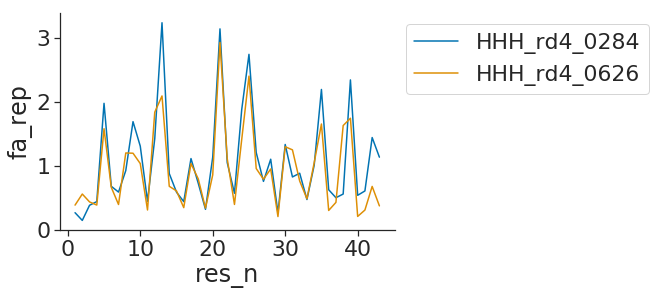

In [21]:
pdbs = ['HHH_rd4_0284', 'HHH_rd4_0626']
plt.figure()
for pdb in pdbs:
    df = scoring_utils.compute_per_residue_energies(pdb_file)
    sns.lineplot(x='res_n', y='fa_rep', data=df, label=pdb)
    
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

## Analyze CD results

Analyze data at 222 nm from the thermal melts

In [ ]:
data_dir = '/net/expdata/Users/Baker Lab/Hugh_Haddox/200219_rescue_ssm/before/222_scan/'
data_dir_2 = '/net/expdata/Users/Baker Lab/Hugh_Haddox/200219_rescue_ssm_and_hbnet/before/222_scan/'
samples = [
    'HHH_rd4_0284_wt', 'HHH_rd4_0284_V21A', 'HHH_rd4_0284_K6L',
    'HHH_rd4_0626_wt', 'HHH_rd4_0636_wt', 'HHH_rd4_0636_V12A',
    'HHH_rd4_0636_V12L', 'HHH_rd4_0636_K6L'
]
scan_dict = {
    key : []
    for key in ['sample', 'temp', 'e', 'v']
}
for sample in samples:
    
    # Get data for sample of interest
    scan_222_f = glob.glob(os.path.join(
        data_dir,
        f'{sample}*.csv'
    ))
    scan_222_f += glob.glob(os.path.join(
        data_dir_2,
        f'{sample}*.csv'
    ))
    assert len(scan_222_f) == 1
    scan_222_f = scan_222_f[0]
    with open(scan_222_f) as f:
        lines = f.readlines()

    # Start recoriding entries after reaching the line that
    # says 'XYDATA'. Stop recording entries after reaching the
    # end of the section with three CSVs
    record = False
    for line in lines:
        if record:
            entries = line.strip().split(',')
            if len(entries) !=3:
                record = False
                continue
            (temp, e, v) = map(float, entries)
            scan_dict['sample'].append(sample)
            scan_dict['temp'].append(temp)
            scan_dict['e'].append(e)
            scan_dict['v'].append(v)
        if 'XYDATA' in line:
            record = True
            
scan_df = pandas.DataFrame(scan_dict)
scan_df.head()

Show data for 0284 and 0626.

In [ ]:
samples = [
    'HHH_rd4_0284_wt', 'HHH_rd4_0284_V21A', 'HHH_rd4_0284_K6L',
    'HHH_rd4_0626_wt'
]
for sample in samples:
    data = scan_df[scan_df['sample'] == sample]
    sns.lineplot(x='temp', y='e', data=data, label=sample)

plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

Show data for 0636.

In [ ]:
samples = [
    'HHH_rd4_0636_wt', 'HHH_rd4_0636_V12A',
    'HHH_rd4_0636_V12L', 'HHH_rd4_0636_K6L'
]
for sample in samples:
    data = scan_df[scan_df['sample'] == sample]
    sns.lineplot(x='temp', y='e', data=data, label=sample)

plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

Analyze full scans

In [ ]:
data_dir = '/net/expdata/Users/Baker Lab/Hugh_Haddox/200219_rescue_ssm/before/full_scans_during_melt/'
data_dir_2 = '/net/expdata/Users/Baker Lab/Hugh_Haddox/200219_rescue_ssm_and_hbnet/before/full_scans_during_melt/'
samples = [
    'HHH_rd4_0284_wt', 'HHH_rd4_0284_V21A', 'HHH_rd4_0284_K6L',
    'HHH_rd4_0626_wt', 'HHH_rd4_0636_wt', 'HHH_rd4_0636_V12A',
    'HHH_rd4_0636_V12L', 'HHH_rd4_0636_K6L'
]
scan_dict = {
    key : []
    for key in ['sample', 'l', '25', '35', '45', '65', '95']
}

for sample in samples:
    
    # Get data for sample of interest
    scan_222_f = glob.glob(os.path.join(
        data_dir,
        f'{sample}*.csv'
    ))
    scan_222_f += glob.glob(os.path.join(
        data_dir_2,
        f'{sample}*.csv'
    ))
    assert len(scan_222_f) == 1
    scan_222_f = scan_222_f[0]
    with open(scan_222_f) as f:
        lines = f.readlines()
        
    # Start recoriding entries after reaching the line that
    # says 'Channel 1'. Stop recording entries after reaching the
    # end of the section with three CSVs
    record = False
    for line in lines:
        if record:
            entries = line.strip().split(',')
            if entries[0] == '':
                continue
            if len(entries) != 6:
                record = False
                continue
            (l, t25, t35, t45, t65, t95) = map(float, entries)
            scan_dict['sample'].append(sample)
            scan_dict['l'].append(l)
            scan_dict['25'].append(t25)
            scan_dict['35'].append(t35)
            scan_dict['45'].append(t45)
            scan_dict['65'].append(t65)
            scan_dict['95'].append(t95)
        if 'Channel 1' in line:
            record = True
            
scan_df = pandas.DataFrame(scan_dict)
scan_df.head()

In [ ]:
samples = [
    'HHH_rd4_0284_wt', 'HHH_rd4_0284_V21A', 'HHH_rd4_0284_K6L',
    'HHH_rd4_0626_wt'
]
(fig, axs) = plt.subplots(
    ncols=2, nrows=3, sharex=True, sharey=True, figsize=[15,15]
)
axs = axs.reshape(-1)
for (i, temp) in enumerate(['25', '35', '45', '65', '95']):
    for sample in samples:
        data = scan_df[scan_df['sample'] == sample]
        sns.lineplot(
            x='l', y=temp, data=data, label=sample,
            ax=axs[i]
        )
    if i != 6:        
        for l in [208, 222]:
            axs[i].plot([l,l], [-35,5], ls='--', c='0.5')
    axs[i].set(
        xlabel='lambda', ylabel='e', title = f'temp = {temp}',
        ylim=[-35, 5]
    )
    if i != 0:
        axs[i].get_legend().remove()
    else:
        axs[i].legend(
            bbox_to_anchor=(0., 1.02, 1., .102), borderaxespad=1.5
        )
#plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

**Observations**: All traces show the same general pattern: at 25C, there are two main dips at around 208 and 222 nm, with the dip at 208 being lower. Gabe pointed out that this could be because the proteins still have the His-tag and TEV site, which would be expected to be disordered. At 95C, the dip at 222 isn't as pronounced, and the dip at 208 shifts to lower wavelength, consistent with a greater fraction of protein being disordered.

In [ ]:
samples = [
    'HHH_rd4_0636_wt', 'HHH_rd4_0636_V12A',
    'HHH_rd4_0636_V12L', 'HHH_rd4_0636_K6L'
]
(fig, axs) = plt.subplots(
    ncols=2, nrows=3, sharex=True, sharey=True, figsize=[15,15]
)
axs = axs.reshape(-1)
for (i, temp) in enumerate(['25', '35', '45', '65', '95']):
    for sample in samples:
        data = scan_df[scan_df['sample'] == sample]
        sns.lineplot(
            x='l', y=temp, data=data, label=sample,
            ax=axs[i]
        )
    if i != 6:        
        for l in [208, 222]:
            axs[i].plot([l,l], [-15,2], ls='--', c='0.5')
    axs[i].set(
        xlabel='lambda', ylabel='e', title = f'temp = {temp}',
        ylim=[-15, 2]
    )
    if i != 0:
        axs[i].get_legend().remove()
    else:
        axs[i].legend(
            bbox_to_anchor=(0., 1.02, 1., .102), borderaxespad=1.5
        )
#plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

**Observations**:



Show changes for individual proteins

In [ ]:
samples = [
    'HHH_rd4_0284_wt', 'HHH_rd4_0284_V21A', 'HHH_rd4_0284_K6L',
    'HHH_rd4_0626_wt', 'HHH_rd4_0636_wt', 'HHH_rd4_0636_V12A',
    'HHH_rd4_0636_V12L', 'HHH_rd4_0636_K6L'
]
ncols = 2
nrows = math.ceil(len(samples)/ncols)
(fig, axs) = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=[15,20]
)
axs = axs.reshape(-1)
for (i, sample) in enumerate(samples):
    data = scan_df[scan_df['sample'] == sample].copy()
    for temp in ['25', '35', '45', '65', '95']:
        data[temp] = data[temp].clip(upper=2)
        sns.lineplot(x='l', y=temp, data=data, label=temp, ax=axs[i])
    axs[i].set(ylabel='e', title=sample)
    if i in [0, 2, 4, 6]:
        axs[i].get_legend().remove()
    #plt.legend(bbox_to_anchor=(1,1))

sns.despine()
plt.tight_layout()
plt.show()

## Analyze the number of deep-sequencing counts per variant over the course of the experiment

First, I will plot the distribution of the frequency of each of the starting variants in the naive library. The naive library is the same for both of the proteases, which is why there is only one plot for both.

In [ ]:
# Compute the log10 frequency of each variant with non-zero
# counts. The naive library is the same for both proteases,
# so I will just analyze the data for trypsin.
protease = 'trypsin'
p = protease[0]
print("Found {0} sequences with zero starting counts".format(
    sum(stability_scores_df['counts0_{0}'.format(p)] == 0)
))
stability_scores_df.dropna(
    subset=['counts0_{0}'.format(p)], inplace=True
)
stability_scores_df['freqs0_{0}'.format(p)] = \
    stability_scores_df['counts0_{0}'.format(p)] / \
        sum(stability_scores_df['counts0_{0}'.format(p)])
stability_scores_df['freqs0_{0}'.format(p)] = \
    np.log10(stability_scores_df['freqs0_{0}'.format(p)])

# Plot the log-transformed data
expected_frequency = 1/(14847)
plt.figure(figsize=[8,5])
sns.kdeplot(
    stability_scores_df[
        ~stability_scores_df['ladder']
    ]['freqs0_{0}'.format(p)],
    label='all non-ladder sequences', shade=True
)
sns.kdeplot(
    stability_scores_df[
        stability_scores_df['ladder']
    ]['freqs0_{0}'.format(p)],
    label='ladder sequences', shade=True
)
plt.ylabel('density')

# Plot a vertical line showing the expected median frequency
plt.plot(
    [np.log10(expected_frequency), np.log10(expected_frequency)],
    [0, 2], c='0.3', ls="--"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('log$_{10}$ population fraction per sequence')
sns.despine()
plt.show()

**Observations**: 
***

The above plot indicates that most sequences were observed at an appreciable frequency. But, how many times was each sequence actually counted? Below, I plot the fraction of sequences with $\le X$ raw sequencing counts at each level of selection.

In [ ]:
def plot_cumulative_distribution_of_counts(
    counts_df, proteases=['t','c']
):

    # Make a dataframe with data on the number of designs with counts
    # greater than a given cutoff
    counts_data_columns = [
        'protease', 'selection_index', 'cutoff',
        'cumulative_fraction'
    ]
    counts_data_dict = {
        key : []
        for key in counts_data_columns
    }
    cutoffs = np.arange(0,50,1)
    selection_indices = list(range(0,7))
    for protease in ['c', 't']:
        for selection_index in selection_indices:
            counts = counts_df[
                'counts{0}_{1}'.format(selection_index, protease)
            ]
            for cutoff in cutoffs:
                cumulative_fraction = \
                    sum(counts <= cutoff)/float(len(counts))
                counts_data_dict['protease'].append(protease)
                counts_data_dict['selection_index'].append(
                    selection_index
                )
                counts_data_dict['cutoff'].append(cutoff)
                counts_data_dict['cumulative_fraction'].append(
                    cumulative_fraction
                )
                if cutoff == 10.0 and selection_index ==  0:
                    print("A fraction of {0:.2f} sequences were counted 10 or fewer times in the starting library".format(cumulative_fraction))
    counts_data_df = pandas.DataFrame.from_dict(counts_data_dict)

    # Plot the data
    g = sns.lmplot(
        x="cutoff",
        y="cumulative_fraction",
        data=counts_data_df,
        col='protease',
        hue='selection_index',
        fit_reg=False,
        height=4
    )
    g.set_axis_labels("counts", "cumulative fraction $\leq X$")
    g.set(yticks=[0, 0.5, 1])
    plt.show()
        
plot_cumulative_distribution_of_counts(stability_scores_df)

**Observations**: Most sequences have an appreciable number of counts in the raw deep-sequencing data from early rounds of selection. In the naive library (blue curve), nearly all sequences have >20 counts, with most sequences having >40 counts. These counts provide a good baseline for estimating stability based on later rounds. The number of reads per sequence goes down later in the experiment. Presumably this is partly due to purifying selection and partly due to the fact that the library wasn't sequenced as deeply in the later rounds (see notebook used to compute EC50 values). The results are similar for both proteases.

## Examine the distribution in EC50 values and associated confidence intervals

First, for each chip and for each protease, plot the distribution of EC50 values.

In [ ]:
# Get data for all proteins with experimental data for
# both proteases
data = stability_scores_df[
    (~stability_scores_df['ec50_t'].isnull()) &
    (~stability_scores_df['ec50_c'].isnull())
].copy()
print("Plotting data for {0} proteins with data from both proteases".format(len(data)))

# First, plot the EC50 values for each protease
(fig, axs) = plt.subplots(ncols=2, figsize=[15,4])
min_EC50 = data[['ec50_t', 'ec50_c']].min().min()
max_EC50 = data[['ec50_t', 'ec50_c']].max().max()
bins = np.arange(math.floor(min_EC50), math.ceil(max_EC50),0.25)
sns.distplot(
    data['ec50_t'], ax=axs[0], label='trypsin',
    kde=False, bins=bins
)
sns.distplot(
    data['ec50_c'], ax=axs[0], label='chymotrypsin',
    kde=False, bins=bins
)
axs[0].set_xlabel('EC50 value')
axs[0].set_ylabel('number of proteins')
axs[0].set_xticks(list(
    range(math.floor(min_EC50), math.ceil(max_EC50)+1)
))

# Then plot the 95% CIs for each protease
sns.distplot(
    data['ec50_95ci_t'], ax=axs[1], label='trypsin',
    kde=False
)
sns.distplot(
    data['ec50_95ci_c'], ax=axs[1], label='chymotrypsin',
    kde=False
)
axs[1].set_xlabel('EC50 95% CI')
axs[1].set_ylabel('number of proteins')

sns.despine()
plt.legend()
plt.tight_layout()
plt.show()

**Observations**: 


***

Next, I will examine why there are some sequences with high uncertainy in their measured EC50 values. One expectation is that this uncertainty comes from low starting counts, the idea being that small counts do not enable robust statistical inference.

In [ ]:
conf_cutoff = 2
(fig, axs) = plt.subplots(ncols=2, figsize=[15,7])
for (i, protease) in enumerate(['trypsin', 'chymotrypsin']):
    
    counts_for_high_conf_seqs = data[
        data['ec50_95ci_{0}'.format(protease[0])] < conf_cutoff
    ]['counts0_{0}'.format(protease[0])]
    counts_for_low_conf_seqs = data[
        data['ec50_95ci_{0}'.format(protease[0])] > conf_cutoff
    ]['counts0_{0}'.format(protease[0])]
    
    print("\nFor {0}...".format(protease))
    print("Mean counts for high-confidence sequences: {0}".format(
        round(counts_for_high_conf_seqs.mean(), 3)
    ))
    print("Mean counts for low-confidence sequences: {0}".format(
        round(counts_for_low_conf_seqs.mean(), 3)
    ))
    sns.kdeplot(
        counts_for_high_conf_seqs,
        label='high confidence (95% CI < {0})'.format(conf_cutoff),
        shade=True, ax=axs[i]
    )
    sns.kdeplot(
        counts_for_low_conf_seqs,
        label='low confidence (95% CI > {0})'.format(conf_cutoff),
        shade=True, ax=axs[i]
    )
    axs[i].set(
        xlim=[0,200], xlabel='counts in naive library', title=protease
    )
    axs[i].get_legend().remove()

print("\nTruncating x axis at 0 and 200")
axs[0].set(ylabel='density of proteins')
axs[0].legend(
    bbox_to_anchor=(0., 1.3, 1., .102), loc=3, ncol=1, borderaxespad=0.
)
sns.despine()
plt.tight_layout()
plt.show()

**Observations**: As expected, sequences with more uncertain EC50 measurements (EC50 95% CIs > 2) indeed tend to have lower starting counts compared to sequences with more certain EC50 measurements.

Another expectation from low starting counts leading to uncertain EC50 measurements is that this uncertainty would be correlated between proteases.

In [ ]:
g = sns.jointplot(
    x='ec50_95ci_t', y='ec50_95ci_c', data=data, kind='hex',
    xlim=[-0.5,3], ylim=[-0.5,3], height=5
)
g.ax_joint.set(xticks=[0,1,2,3], yticks=[0,1,2,3])
plt.show()

**Observations**: The above expectation is only partially true, indicating that low starting counts is only a partial explanation for why some sequences have EC50 values with low certainty.

In the below cell, I filter out sequences for which the EC50 95% CI for at least one protease is greater than a given threshold.

In [ ]:
ci_threshold = 2.0
low_q_seqs = \
    (stability_scores_df['ec50_95ci_t'] > ci_threshold) | \
    (stability_scores_df['ec50_95ci_c'] > ci_threshold)
low_q_stability_scores_df = stability_scores_df[low_q_seqs].copy()
stability_scores_df = stability_scores_df[~low_q_seqs]
print("Filtered out {0} sequences for which the 95% CI for at least one protease is greater than {1}".format(sum(low_q_seqs), ci_threshold))
print("... leaving {0} sequences".format(len(stability_scores_df)))

**What are the sequences that are dropping out?**

***

The distribution of EC50 values from above is similar for the two proteases. But, are individual points correlated? Below, I plot this correlation.

In [ ]:
# Get data
x = 'ec50_t'
y = 'ec50_c'
data = stability_scores_df[
    (stability_scores_df[x].notnull()) &
    (stability_scores_df[y].notnull())
].copy()

# Compute correlation coefficient
r, _ = scipy.stats.pearsonr(
    data[x], data[y]
)
print("R = {0}".format(round(r, 2)))

# Plot correlation
g = sns.jointplot(
    x=x, y=y, data=data, kind='hex', height=6
)
min_val = data[[x,y]].min().min()
max_val = data[[x,y]].max().max()
g.ax_joint.plot([min_val,max_val], [min_val,max_val], c=".2", ls="--")
g.ax_joint.set(
    xlabel='trypsin EC50', ylabel='chymotrypsin EC50',
    xticks=[0, 2, 4, 6, 8], yticks=[0, 2, 4, 6, 8]
)
plt.show()

**Observations:** The EC50 values are well correlated between proteases, with points roughtly distributed around the line of equivalence (black line). Of note, the EC50 values are not expected to be perfectly correlated, since these values are strongly influenced by number of protease cut sites, and since there is not guarantee that each protein has the same number of cut sites for each protease.

***

Next, I will examine the EC50 values that our models predict for each protein if that protein were completely unfolded. This value is strongly influenced by the number of protease cutsites in each protein, and we use it to correct for differences in protease susceptibility when computing stability scores. Now that we are using a more protease-resistant display vector (see above), one question is: what is the distribution of predicted EC50 values? Since these max out around an EC50 of 4 in the old vector, is it possible there are some sequences that come out looking stable due to very few cut sites, now that the EC50 range goes higher?

In [ ]:
# Get data
data = stability_scores_df[
    (~stability_scores_df['ec50_t'].isnull()) &
    (~stability_scores_df['ec50_c'].isnull())
].copy()
min_EC50_pred = data[['ec50_pred_t', 'ec50_pred_c']].min().min()
max_EC50_pred = data[['ec50_pred_t', 'ec50_pred_c']].max().max()
bins = np.arange(
    math.floor(min_EC50_pred), math.ceil(max_EC50_pred),0.25
)

# Plot data
plt.figure(figsize=[5,3])
sns.distplot(
    data['ec50_pred_t'], label='trypsin', kde=False, bins=bins
)
sns.distplot(
    data['ec50_pred_c'], label='chymotrypsin', kde=False, bins=bins
)
plt.xlabel('predicted EC50 value\nof unfolded state')
plt.ylabel('number of\nproteins')
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

**Observations**: Most proteins are predicted to have unfolded-state EC50 values of <2, which is well within the dynamic range of the assay with the old display vector. As such, in response to the question posed above, it does not seem very likely that there are proteins in this experiment that appear highly stable merely because the predicted unfolded-state EC50 is hitting a wall at the upper range of the old display vector.

***

For scrambled controls, how well do the predicted EC50 values match the observed ones?

In [ ]:
if False:
    # Iterate over topologies, computing the correlation for each
    topologies = \
        sorted(list(set(stability_scores_df['topology'].dropna())))

    for topology in topologies:

        # Get data for scrambles from the given topology
        data = stability_scores_df[
            (stability_scores_df['topology'] == topology) &
            (stability_scores_df['scramble'] == True)
        ].copy()

        # Make plots showing the correlation between predicted vs.
        # observed EC50 for each protease
        (fig, axs) = plt.subplots(ncols=3, figsize=[15,6])
        for (i, protease) in enumerate(['trypsin', 'chymotrypsin']):
            x = data['ec50_pred_{0}'.format(protease[0])]
            y = data['ec50_{0}'.format(protease[0])]
            (r, p) = scipy.stats.pearsonr(x, y)
            sns.scatterplot(x, y, ax=axs[i])
            axs[i].plot([-2,6], [-2,6], ls='--', c='0.5')
            axs[i].text(
                0.2, 0.9, '$R = {0}$'.format(round(r, 2)),
                horizontalalignment='center',
                verticalalignment='center',
                transform=axs[i].transAxes,
                fontsize=20
            )
            axs[i].set(
                title='{0}, {1}'.format(topology, protease),
                xticks=[-2, 0, 2, 4, 6],
                yticks=[-2, 0, 2, 4, 6],
                aspect='equal'
            )

        # Make a third plot showing the correlation in observed EC50
        # values between proteases
        x = data['ec50_t']
        y = data['ec50_c']
        (r, p) = scipy.stats.pearsonr(x, y)
        sns.scatterplot(x, y, ax=axs[2])
        axs[2].plot([-2,6], [-2,6], ls='--', c='0.5')
        axs[2].text(
            0.2, 0.9, '$R = {0}$'.format(round(r, 2)),
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[2].transAxes,
            fontsize=20
        )
        axs[2].set(
            title=topology,
            xticks=[-2, 0, 2, 4, 6],
            yticks=[-2, 0, 2, 4, 6],
            aspect='equal'
        )
        sns.despine()
        plt.tight_layout()
        plt.show()

**Observations:**


*** 

Another question is whether the observed EC50 values are biased by the initial counts of each variant in the starting library. If so, that would mean that stability scores are artificially influenced by experimental factors.

In [ ]:
# Compute the log counts
data = stability_scores_df[
    (stability_scores_df['counts0_t'].notnull()) &
    (stability_scores_df['counts0_t'] > 0)
].copy()

(fig, axs) = plt.subplots(ncols=2, figsize=[15, 5])
print("Truncating x-axis at 1,2.5")
for (i, protease) in enumerate(['trypsin', 'chymotrypsin']):
    data['log_counts0_{0}'.format(protease[0])] = \
        data['counts0_{0}'.format(protease[0])].apply(np.log10)
    x = 'log_counts0_{0}'.format(protease[0])
    y = 'ec50_{0}'.format(protease[0])
    axs[i].hexbin(data[x], data[y], gridsize=(100,50), cmap='Greys')
    
    r, _ = scipy.stats.pearsonr(data[x], data[y])
    axs[i].annotate(
        "R = {:.2f}".format(r),
        xy=(.05, .9), xycoords=axs[i].transAxes, fontsize=20
    )
    axs[i].set(
        xlabel='$log_{10}$ counts in naive library',
        ylabel='EC50', title=protease, xlim=[1.5,2.8]
    )
sns.despine()
plt.tight_layout()
plt.show()

**Observations**: Based on the above plots, there is a only weak relationship between the number of times a sequence was counted in the naive library and its EC50 value, with Pearson correlation coefficients near 0-0.1 for both proteases.

***

Another point of interest is the relationship between stability score and predicted EC50. This relationship is important because it sets upper and lower limits of what that assay can measure. For instance, if a sequence's predicted EC50 is very high, it makes it impossible to have a very high stability score. Plotting this distribution might inform how to compress the distribution of stability scores when building predictive models.

In [ ]:
data = stability_scores_df.dropna(
    subset=['stabilityscore_t', 'stabilityscore_c']
).copy()
for p in ['t', 'c']:
    (fig, axs) = plt.subplots(
        ncols=2, figsize=[14,6], sharex=True, sharey=True
    )
    x='ec50_pred_{0}'.format(p)
    y='stabilityscore_{0}'.format(p)
    sns.scatterplot(x=x, y=y, data=data, ax=axs[0])
    axs[1].hexbin(data[x], data[y], cmap='Greys')
    for i in [0, 1]:
        axs[i].plot([-1,4], [0,0], c='k', ls='--')
        axs[i].plot([-1,4], [2.25,2.25], c='k', ls='--')
    sns.despine()
    plt.tight_layout()
    plt.show()

**Observations**:

## Analyze EC50 values and stability scores for the ~400 sequences that we tested from Rocklin et al., 2017, *Science*, seeing how these values have changed with the new display vector

Read in data for ladder sequences from past experiments. Then, merge with data from the current experiment.

In [ ]:
# Read in sequences and data from past experiments for
# the ladder
ladder_files_dir = 'data/ladder_sequences/'
ladder_files = [
    'ladder_sequences.csv',
    'ladder_sequences_10_bins_15_samples_per_bin.csv'
]
dfs = []
for (i, f) in enumerate(ladder_files):
    df = pandas.read_csv(os.path.join(ladder_files_dir, f))
    df['ladder_file_index'] = i
    dfs.append(df)

ladder_df = pandas.concat(dfs)

# Select all sequences from `Rocklin_2017_Science`
ladder_df = ladder_df[
    (ladder_df['library_name'] == 'Rocklin_2017_Science')
]
ladder_df.drop_duplicates(subset=['sequence'], inplace=True)

# Add a column with the name of each ladder sequence in context
# of this experiment (the column called "chip_name" in the above
# dataframe is incorrect), getting correct names from another
# dataframe that I read in below.
ladder_df.drop(columns=['chip_name'], inplace=True)
ladder_df.rename(columns={'sequence':'protein_sequence'}, inplace=True)
df = pandas.read_csv(
    'results/generate_ssm_of_unstable_proteins/all_starting_names_and_protein_sequences.csv'
)
df = df[df['chip_name'].apply(lambda x: 'ladder' in x)]
ladder_df = ladder_df.merge(
    df[['chip_name', 'protein_sequence']], left_on='protein_sequence',
    right_on='protein_sequence', validate='1:1', how='left'
)
ladder_df.set_index('chip_name', inplace=True)
print("Read in {0} ladder sequences from Rocklin et al.".format(
    len(ladder_df)
))

# Change columns with experimental data to indicate they
# are from past experiments
ladder_df = ladder_df[[
    'protein_sequence', 'library_name', 'ec50_t', 'ec50_c'
]]
ladder_df.rename(columns={
    'ec50_t' : 'original_ec50_t',
    'ec50_c' : 'original_ec50_c'
}, inplace=True)

# Add data from the current experiment and remove sequences
# without data
ladder_df = ladder_df.merge(
    stability_scores_df, left_index=True, right_index=True,
    validate='1:1', how='left'
)
ladder_df.dropna(subset=['ec50_t','ec50_c'], inplace=True)
print("{0} of which have data for both proteases/experiments".format(
    len(ladder_df)
))

Plot the correlation in EC50 values between Rocklin et al. and the present experiment for all ladder sequences.

In [ ]:
def f_line(B, x):
    """
    Linear function y = m*x + b
    
    Args:
        `B`: a vector of the parameters
        `x`: an array of x values
        
    Returns:
        An array of y values
    """
    return B[0]*x + B[1]

def perform_orthogonal_distance_regression(x, y):
    """
    Perform orthogonal distance regression
    
    ...as described here: https://docs.scipy.org/doc/scipy/reference/odr.html
    where initial estimates for the beta vector are a slope of one and a
    y intercept of zero.
    
    Args:
        `x`: an array of x variables
        `y`: an array of y variables ordered in a way that matches x
    """
    linear = scipy.odr.Model(f_line)
    mydata = scipy.odr.Data(x=x, y=y)
    myodr = scipy.odr.ODR(mydata, linear, beta0=[1., 0.])
    myoutput = myodr.run()
    return myoutput

# Make the plot
EC50_truncation_cutoff = 4
print("For each plot...")
print("Black dashed line: y=x")
print("Green line: ODR line computed using all data")
print("Purple line: ODR line computed using all proteins with EC50 values < {0} in both experiments for a given protease".format(EC50_truncation_cutoff))

(fig, axs) = plt.subplots(ncols=2, figsize=[12,6])
protease_dict = {'t':'trypsin', 'c':'chymotrypsin'}
for (i, protease) in enumerate(['t', 'c']):
    
    # Make a scatter plot of EC50 values
    x = 'ec50_{0}'.format(protease)
    y = 'original_ec50_{0}'.format(protease)
    data = ladder_df[
        (ladder_df[x].notnull()) & (ladder_df[y].notnull())
    ].copy()
    sns.scatterplot(
        x=x, y=y, data=data, alpha=0.5, s=50, ax=axs[i]
    )
    range_min = math.floor(data[[x,y]].min().min()) - 1
    range_max = math.ceil(data[[x,y]].max().max()) + 1
    ticks = list(range(range_min, range_max, 2))
    axs[i].set(
        xticks=ticks, yticks=ticks, xlim=[np.min(ticks), np.max(ticks)],
        ylim=[np.min(ticks), np.max(ticks)], aspect='equal',
        xlabel='EC50 from\nthis experiment',
        ylabel='EC50 from\nRocklin et al.'
    )

    # Plot a black, dashed y=x line
    axs[i].plot(
        [range_min, range_max], [range_min, range_max], c=".2",
        ls="--"
    )

    # Plot a green line giving the ODR line computed using all the
    # data
    myoutput = perform_orthogonal_distance_regression(
        data[x],
        data[y]
    )
    (slope, y_int) = myoutput.beta
    f_range_min = (slope * range_min) + y_int
    f_range_max = (slope * range_max) + y_int
    axs[i].plot(
        [range_min, range_max], [f_range_min, f_range_max], c="g"
    )
    r, _ = scipy.stats.pearsonr(data[x], data[y])
    axs[i].annotate(
        "R = {:.2f} for all EC50s".format(r),
        xy=(.05, .9), xycoords=axs[i].transAxes, fontsize=20
    )

    # Then, plot a purple line giving the ODR line computed using
    # just the data where both EC50 values are below a given cutoff
    truncated_data = data[
        (data[x]<EC50_truncation_cutoff) &
        (data[y]<EC50_truncation_cutoff)
    ].copy()
    myoutput = perform_orthogonal_distance_regression(
        truncated_data[x], truncated_data[y]
    )
    (slope, y_int) = myoutput.beta
    f_range_min = (slope * range_min) + y_int
    f_range_max = (slope * range_max) + y_int
    axs[i].plot(
        [range_min, range_max], [f_range_min, f_range_max], c="purple"
    )    
    r, _ = scipy.stats.pearsonr(truncated_data[x], truncated_data[y])
    axs[i].annotate(
        "R = {:.2f} for EC50s < {}".format(r, EC50_truncation_cutoff),
        xy=(.05, 1.0), xycoords=axs[i].transAxes, fontsize=20
    )
    
    # Add title
    axs[i].text(
        0.5, 1.1, protease_dict[protease], fontsize=20,
        horizontalalignment='center', transform = axs[i].transAxes
    )

sns.despine()
plt.tight_layout()
plt.show()

**Observations**: 

***

The above results show that the new vector has increased the dynamic range of EC50 values that are measurable in the assay. How does this change influence the stability scores that are inferred from EC50 values? 

In the below cell, for each ladder sequence, I recompute stability scores from EC50 values from both old and new experiments (the above dataframe only has stability scores for sequences from the new experiment). Then, I plot the correlation in stability scores between experiments.

In [ ]:
# For each protease, recompute stability scores for both the old
# and new experiments
for p in ['t', 'c']:
    ladder_df['stabilityscore_{0}2'.format(p)] = ladder_df.apply(
        lambda row: np.log10(math.pow(
            3, (row['ec50_{0}'.format(p)] - \
                    row['ec50_pred_{0}'.format(p)])
        )), axis=1
    )
    ladder_df['original_stabilityscore_{0}2'.format(p)] = \
        ladder_df.apply(
            lambda row: np.log10(math.pow(
                3, (row['original_ec50_{0}'.format(p)] - \
                        row['ec50_pred_{0}'.format(p)])
            )), axis=1
    )

    # For data from the new experiment, make sure that the recomputed
    # stability scores are the same as the ones that were already in
    # the dataframe
    for (i, row) in ladder_df.iterrows():
        assert (row['stabilityscore_{0}'.format(p)] - \
                    row['stabilityscore_{0}2'.format(p)]) < 1e-4

# Plot the correlation in stability scores between the old and
# new experiments
stabilityscore_truncation_cutoff = 1.0
print("For each plot...")
print("Black dashed line: y=x")
print("Green line: ODR line computed using all data")
print("Purple line: ODR line computed using all proteins with stability scores < {0} in both experiments for a given protease".format(stabilityscore_truncation_cutoff))

(fig, axs) = plt.subplots(ncols=2, figsize=[12,6])
print("Truncating the axes at -2,4")
for (i, protease) in enumerate(['t', 'c']):
    
    # Make a scatter plot of EC50 values
    x = 'stabilityscore_{0}2'.format(protease)
    y = 'original_stabilityscore_{0}2'.format(protease)
    data = ladder_df[
        (ladder_df[x].notnull()) & (ladder_df[y].notnull())
    ].copy()
    sns.scatterplot(
        x=x, y=y, data=data, alpha=0.5, s=50, ax=axs[i]
    )
    range_min = -2 #math.floor(data[[x,y]].min().min())
    range_max = 5 #math.ceil(data[[x,y]].max().max())
    ticks = list(range(range_min, range_max+1, 1))
    axs[i].set(
        xticks=ticks, yticks=ticks, xlim=[np.min(ticks), np.max(ticks)],
        ylim=[np.min(ticks), np.max(ticks)], aspect='equal',
        xlabel='stability from\nthis experiment',
        ylabel='stability from\nRocklin et al.'
    )

    # Plot a black, dashed y=x line
    axs[i].plot(
        [range_min, range_max], [range_min, range_max], c=".2",
        ls="--"
    )

    # Plot a green line giving the ODR line computed using all the
    # data
    myoutput = perform_orthogonal_distance_regression(
        data[x],
        data[y]
    )
    (slope, y_int) = myoutput.beta
    f_range_min = (slope * range_min) + y_int
    f_range_max = (slope * range_max) + y_int
    axs[i].plot(
        [range_min, range_max], [f_range_min, f_range_max], c="g"
    )
    (r, p) = scipy.stats.pearsonr(data[x], data[y])
    axs[i].annotate(
        "R = {:.2f} for all S".format(r),
        xy=(.05, .8), xycoords=axs[i].transAxes, fontsize=20
    )
    
    # Then, plot a purple line giving the ODR line computed using
    # just the data where both EC50 values are below a given cutoff
    truncated_data = data[
        (data[x]<stabilityscore_truncation_cutoff) &
        (data[y]<stabilityscore_truncation_cutoff)
    ].copy()
    myoutput = perform_orthogonal_distance_regression(
        truncated_data[x], truncated_data[y]
    )
    (slope, y_int) = myoutput.beta
    f_range_min = (slope * range_min) + y_int
    f_range_max = (slope * range_max) + y_int
    axs[i].plot(
        [range_min, range_max], [f_range_min, f_range_max], c="purple"
    )    
    r, _ = scipy.stats.pearsonr(truncated_data[x], truncated_data[y])
    axs[i].annotate(
        "R = {:.2f} for S < {}".format(
            r, stabilityscore_truncation_cutoff
        ),
        xy=(.05, 0.9), xycoords=axs[i].transAxes, fontsize=20
    )
    
    # Add title
    axs[i].text(
        0.5, 1.0, protease_dict[protease], fontsize=20,
        horizontalalignment='center', transform = axs[i].transAxes
    )

sns.despine()
plt.tight_layout()
plt.show()

**Observations:** 

## Look at the distribution of stability scores across all designs

First, I will look at the correlation in stability scores between proteases for all designs.

In [ ]:
x = 'stabilityscore_t' # 'stabilityscore_t'
y = 'stabilityscore_c' # 'stabilityscore_c'
r, _ = scipy.stats.pearsonr(
    stability_scores_df[x], stability_scores_df[y]
)
print("R = {0}".format(round(r, 2)))
g = sns.jointplot(
    x=x, y=y, data=stability_scores_df, kind='hex', height=5
)
min_val = stability_scores_df[[x,y]].min().min()
max_val = stability_scores_df[[x,y]].max().max()
g.ax_joint.plot([min_val,max_val], [min_val,max_val], c=".2", ls="--")
g.ax_joint.set_xticks([0, 2, 4])
plt.show()

**Observations**: There is a high correlation in stability scores between proteases, with a Person correlation coefficient of 0.86. In a sense, these datasets constitute technical replicates that diverse after the step of transforming the library into yeast. Thus, this high correlation indicates that there is a high level of reporoducibility at all subsequent steps of the experiment. It also indicates that the observed stabilities do not strongly depend on the specific protease. Though, there is some bias, where stability scores tend to be higher for chymotrypsin.

Next, I will compare the distribution of stability scores (taken as the minimum stability score between the two proteases) between designs and scrambled controls.

In [ ]:
# Add a column indicating which sequences correspond with a
# Rosetta design
stability_scores_df['design'] = (
    (stability_scores_df['topology'].notnull()) &
    (stability_scores_df['score_per_res'].notnull())
)

# Make sure that the designs identified above don't contain
# any scrambles
assert sum(stability_scores_df[
    stability_scores_df['design']==True
]['patterned_scramble']) == 0
assert sum(stability_scores_df[
    stability_scores_df['design']==True
]['full_scramble']) == 0

# Make a column that indicates which proteins are designs,
# patterned scrambles, full scrambles, or none of the above
def define_group(design_bool, patterned_bool, full_bool):
    if design_bool:
        assert patterned_bool == full_bool == False
        return 'design'
    elif patterned_bool:
        assert full_bool == False
        return 'patterned_scramble'
    elif full_bool:
        return 'full_scramble'
    else:
        return np.nan

stability_scores_df['design_or_scramble'] = stability_scores_df.apply(
    lambda row: define_group(
        row['design'],
        row['patterned_scramble'],
        row['full_scramble']
    ), axis=1
)

In [ ]:
data = stability_scores_df[stability_scores_df['topology'].notnull()]
plt.figure(figsize=[6,4])
sns.kdeplot(
    data[
        data['design_or_scramble'] == 'design'
    ]['stabilityscore'], label='design', shade= True
)
sns.kdeplot(
    data[
        data['design_or_scramble'] == 'patterned_scramble'
    ]['stabilityscore'], label='patterned_scramble', shade=True
)
sns.kdeplot(
    data[
        data['design_or_scramble'] == 'full_scramble'
    ]['stabilityscore'], label='full_scramble', shade=True
)
plt.xlabel('stabilityscore')
plt.ylabel('density of proteins')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine()
plt.show()

**Observations**: The distribution of stability scores ranges from ~0-4. The designs are substantially enriched over scrambles at higher stability scores, with a fraction of patterened scrambles reaching high stability scores.

***

Next, I will look at how the distribution of stability scores varies with topology and design protocol.

In [ ]:
data = stability_scores_df[stability_scores_df['topology'].notnull()]
topologies = sorted(list(set(data['topology'])))
print(topologies)
e_functions = sorted(list(set(
    data[data['e_function'].notnull()]['e_function']
)))
print(e_functions)
design_strategies = sorted(list(set(
    data[data['design_strategy'].notnull()]['design_strategy']
)))
print(design_strategies)
relax_script_names = sorted(list(set(
    data[data['relax_script_name'].notnull()]['relax_script_name']
)))
print(relax_script_names)

In [ ]:
stability_scores_df['group'] = stability_scores_df.apply(
    lambda row: "{0} - {1}".format(
        row['e_function'], row['relax_script_name']
    ).replace(
        'MonomerDesign2019', 'MD'
    ).replace(
        'KillA2019.beta16.nostab_refit', 'KA'
    ).replace(
        'KillA2019', 'KA'
    ).replace(
        'custom_default', 'default'
    ), axis=1
)

In [ ]:
topologies = sorted(list(set(data['topology'])))
group_order = [
    'beta16.nostab-refit - default',
    'beta16.nostab-refit - MD',
    'beta16.nostab-refit - KA',
    'beta_nov16 - default',
    'beta_nov16 - MD',
    'beta_nov16 - KA'
]
data = stability_scores_df[
    (stability_scores_df['topology'].notnull()) &
    (stability_scores_df['design_strategy'] == \
         'standard_with_extra_rotamers') &
    (stability_scores_df['group'].isin(group_order))
].copy()

for topology in topologies:
    print("\n#--------------------------")
    print(topology)
    data_i = data[
        (data['topology'] == topology) &
        (data['group'].isin(group_order))
    ]
    (fig, axs) = plt.subplots(
        ncols=2, figsize=[12,9], sharey=True
    )
    hue_order = ['design', 'patterned_scramble', 'full_scramble']
    sns.boxplot(
        x='stabilityscore', y='group', data=data_i,
        hue='design_or_scramble', order=group_order,
        hue_order=hue_order, ax=axs[0]
    )
    sns.countplot(
        y='group', data=data_i, hue='design_or_scramble',
        order=group_order, hue_order=hue_order, ax=axs[1]
    )
    for i in [0,1]:
        axs[i].set(ylabel='')
    axs[0].legend(
        bbox_to_anchor=(0., 1.2, 1., .102), borderaxespad=0.
    )
    axs[1].get_legend().remove()
    plt.tight_layout()
    sns.despine()
    plt.show()

**Observations**:

MD better than default
* beta16.nostab-refit
  * EHEE_65aa (big)
  * HEEHE_65aa (big)
  * HHHH_65aa (big)
  * HHH_43aa (big)
  * HHH_64aa
* beta_nov16
  * EEHEE_43aa
  * EEHEE_57aa (big)
  * EHEE_65aa
  * HEEHE_65aa (big)
  * HHHH_65aa
  * HHH_64aa

beta_nov16 results in more stable designs than beta16.nostab-refit
* EEHEE_43aa
* EEHEE_57aa

No stable designs:
* EHEE_40aa

Read in Rosetta scores computed using different strategies, such as with different energy functions and/or after relaxing the proteins.

In [ ]:
score_types = [
    'torsion_relax',
    'constrained_cart_relax_beta_nov16'
]
for score_type in score_types:
    
    # Read in data from scores file
    score_file = os.path.join(
        'results/',
        'ordered_designs_{0}/'.format(score_type),
        'score.sc'
    )
    df = pandas.read_csv(
        score_file, sep='\s+', skiprows=1, error_bad_lines=False
    )
    del df['SCORE:']
    df.dropna(subset=['description'], inplace=True)
    df['chip_name'] = df['description'].apply(
        lambda x: os.path.basename(x).replace('_0001', '')
    )
    df.set_index('chip_name', inplace=True)
    df.rename(columns={
        col : '{0}_{1}'.format(col, score_type)
        for col in df.columns.values
    }, inplace=True)
    
    # Merge above data with main dataframe if haven't already
    # done so. Then compute score per res
    existing_cols = stability_scores_df.columns.values
    if 'total_score_{0}'.format(score_type) not in existing_cols:
        stability_scores_df = stability_scores_df.merge(
            df[['total_score_{0}'.format(score_type)]],
            left_index=True, right_index=True, how='left'
        )
        stability_scores_df['score_per_res_{0}'.format(score_type)] = \
            stability_scores_df['total_score_{0}'.format(score_type)] / \
                stability_scores_df['nres']

In [ ]:
# Add a columns giving the values of a design's matched
# scrambled control, if one exists.
def get_value_of_control(
    chip_name, scramble_pattern, indices_of_scrambles, metric
):
    scramble_chip_name = scramble_pattern + chip_name
    if scramble_chip_name in indices_of_scrambles:
        stabilityscore = stability_scores_df.loc[
            scramble_chip_name
        ][metric]
        return stabilityscore
    else:
        return np.nan
indices_of_scrambles = stability_scores_df[
    stability_scores_df['patterned_scramble'] == True
].index.values
metrics = [
    'stabilityscore', 'ec50_95ci_t', 'ec50_95ci_c',
    'protein_sequence'
]
for metric in metrics:
    stability_scores_df['{0}_of_ps'.format(metric)] = \
        stability_scores_df.apply(
            lambda row: get_value_of_control(
                chip_name=row.name,
                scramble_pattern='p',
                indices_of_scrambles=indices_of_scrambles,
                metric=metric
            ), axis=1
    )

# Add a column indicating whether a design's matched scramble
# has high-quality EC50 values for both proteases
confidence_cutoff = 2.0
stability_scores_df['stabilityscore_of_ps_confident'] = \
    stability_scores_df.apply(
        lambda row: \
            (row['ec50_95ci_t_of_ps'] <= confidence_cutoff) &
            (row['ec50_95ci_c_of_ps'] <= confidence_cutoff),
        axis=1
    )

Compare designs using various structural metrics, showing differences in stability along side differences in metrics.

In [ ]:
topologies = sorted(list(set(data['topology'])))
relax_script_names = [
    'custom_default', 'MonomerDesign2019', 
    'KillA2019', 'KillA2019.beta16.nostab_refit'
]
e_functions = ['beta_nov16', 'beta16.nostab-refit']
metrics = [
    'score_per_res',
    'buried_npsa_FAMILYVW_per_res',
    'exposed_npsa', 'exposed_hydrophobics',
    'percent_hydrophobic_AFILMVWY', 'percent_hydrophobic',
    'avg_all_frags',
    'buns_sc_heavy', 'buns_bb_heavy', 'buns_nonheavy'
]
for e_function in e_functions:
    print("\n#--------------------------")
    print(e_function)
    data = stability_scores_df[
        (stability_scores_df['topology'].notnull()) &
        (stability_scores_df['design_strategy'] == \
             'standard_with_extra_rotamers') &
        (stability_scores_df['e_function'] == e_function) &
        (stability_scores_df['relax_script_name'].isin(
            relax_script_names)) &
        (stability_scores_df['design'] == True)
    ].copy()
    relax_script_names_i = [
        rs for rs in relax_script_names
        if rs in set(data['relax_script_name'])
    ]
    sns.countplot(
        y='topology', data=data, order=topologies,
        hue='relax_script_name', hue_order=relax_script_names_i
    )
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1,1))
    sns.despine()
    plt.show()
    for metric in metrics:
        (fig, axs) = plt.subplots(
            ncols=3, figsize=[15,10], sharey=True
        )
        sns.boxplot(
            x=metric, y='topology', data=data, order=topologies,
            hue='relax_script_name', hue_order=relax_script_names_i,
            ax=axs[0]
        )
        sns.boxplot(
            x='stabilityscore', y='topology', data=data,
            order=topologies,
            hue='relax_script_name', hue_order=relax_script_names_i,
            ax=axs[1]
        )
        axs[1].set(xlabel='stability of\ndesign', ylabel='')
        sns.boxplot(
            x='stabilityscore_of_ps', y='topology', data=data,
            order=topologies,
            hue='relax_script_name', hue_order=relax_script_names_i,
            ax=axs[2]
        )
        axs[2].set(xlabel='stability of\npatterned scramble', ylabel='')
        for i in [0, 1, 2]:
            axs[i].get_legend().remove()
            axs[i].xaxis.grid(True)
        axs[0].legend(
            bbox_to_anchor=(0., 1.1, 1., .102), borderaxespad=0.
        )
        plt.ylabel('')
        sns.despine()
        plt.show()

**Observations**:

Make figure for paper

In [ ]:
relax_script_names = [
    'custom_default', 'MonomerDesign2019', 
    'KillA2019', 'KillA2019.beta16.nostab_refit'
]
relax_script_names_for_legend = {
    'custom_default' : 'Legacy',
    'MonomerDesign2019' : 'MonomerDesign2019',
    'KillA2019' : 'PolarDesign2019',
    'KillA2019.beta16.nostab_refit' : 'PolarDesign2019'
}
relax_script_names_order = [
    'Legacy', 'MonomerDesign2019', 'PolarDesign2019'
]
e_functions = ['beta_nov16', 'beta16.nostab-refit']
for e_function in e_functions:
    
    # Get data for energy function
    print("\n#--------------------------")
    print(e_function)
    data = stability_scores_df[
        (stability_scores_df['topology'].notnull()) &
        (stability_scores_df['design_strategy'] == \
             'standard_with_extra_rotamers') &
        (stability_scores_df['e_function'] == e_function) &
        (stability_scores_df['relax_script_name'].isin(
            relax_script_names)) &
        (stability_scores_df['design'] == True)
    ].copy()
    
    # Tweak variable names
    data['relax_script_name_for_legend'] = \
        data['relax_script_name'].replace(
            to_replace=relax_script_names_for_legend
        )
    data['topology'] = data['topology'].apply(
        lambda x: x.replace('_', ' (').replace('aa', ' aa)')
    )
    topologies = sorted(list(set(data['topology'])))
    
    # Plot the number of designs in each category
    sns.countplot(
        y='topology', data=data, order=topologies,
        hue='relax_script_name_for_legend',
        hue_order=relax_script_names_order
    )
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1,1))
    sns.despine()
    plt.show()

    # Plot data for designs
    (fig, axs) = plt.subplots(
        ncols=5, figsize=[20,10], sharey=True
    )
    metrics = [
        (
            'score_per_res_constrained_cart_relax_beta_nov16',
            'Rosetta energy\nper residue'
        ), (
            'buried_npsa_FAMILYVW_per_res',
            'buried NPSA\nper residue'
        ), (
            'percent_hydrophobic_AFILMVWY',
            'percent hydrophobic\namino acids'
        )
    ]
    sns.boxplot(
        x='stabilityscore', y='topology', data=data,
        order=topologies,
        hue='relax_script_name_for_legend',
        hue_order=relax_script_names_order,
        ax=axs[0]
    )
    axs[0].set(xlabel='stability of\ndesign', ylabel='')
    sns.boxplot(
        x='stabilityscore_of_ps', y='topology', data=data,
        order=topologies,
        hue='relax_script_name_for_legend',
        hue_order=relax_script_names_order,
        ax=axs[1]
    )
    axs[1].set(xlabel='stability of\nscramble', ylabel='')
    for (i, (metric, name)) in enumerate(metrics, 2):
        sns.boxplot(
            x=metric, y='topology', data=data, order=topologies,
            hue='relax_script_name_for_legend',
            hue_order=relax_script_names_order,
            ax=axs[i]
        )
        axs[i].set(xlabel=name)
    for i in [0, 1, 2, 3, 4]:
        axs[i].set(ylabel='')
        axs[i].get_legend().remove()
        axs[i].xaxis.grid(True)
    axs[0].legend(
        bbox_to_anchor=(0.65, 1.1, 1., .102), borderaxespad=0.
    )
    plt.ylabel('')
    sns.despine()
    plt.show()

**Observations**:

**The new protocol improves Rosetta's ability to design stable de novo mini-proteins**

Above, we describe how the new protocol increases Rosetta's ability to recover native sequences. Next, we sought to compare the old and new protocols in a different computational-modeling challenge: de novo protein design. A recently developed high-throughput method makes it possible to quantify the stability of thousands of mini-protein designs (40-65 amino acids) in a single experiment. Using this method, we compared the ability of the old and new design protocols to design stable mini-proteins, testing hundreds of protein designs per protocol.

Our design approach involved three main steps. First, we defined eight different "blueprints", each of which specified a unique protein topology and length. These blueprints were structurally diverse, spanning five different topologies, and ranging between 40-65 amino acids in length, allowing us to test the protocols in many different structural contexts. Second, for each blueprint, we used Rosetta to generate a large number of three-dimensional protein backbones that matched the specified topology and length. For each set, we selected 100 backbones that formed compact structures. Third, we used Rosetta to design amino-acid seqeuences onto each of the selected backbones. We conducted the third step independently with both the old and new design protocols, allowing for a head-to-head comparison between protocols.

**Figure X. MonomerDesign2019 is more successful than Legacy at generating stable mini-protein designs.** A) Stability of mini-designs. Tends to be highest for MD, then Legacy, then ref_ramp. B) Stability of scrambles. Stability is much lower than for designs. Some MD scrambles are stable. C) Rosetta energy. Tends to be lowest for MD, then Legacy and ref_ramp. D) buried NPSA. E) percent hydrophobic amino acids.

Next, we used the high-throughput assay to measure the stability of each of the protein designs from above. Figure XA shows the resulting stability values for different groups of designs. Across all topologies and sizes tested, the proteins designed with MonomerDesign2019 tended to be more stable than proteins designed with the other two design protocols.

For each design, we also measured the stability of a "scrambled" control, generated by shuffling the designed protein sequence while preserving the hydrophobic and hydrophilic patterning across all sites. Figure XB shows the stability of these scrambled controls.

Why do proteins made with MonomerDesign2019 tend to be more stable?
One possibility is that this protocol improves Rosetta's ability to find low-energy amino-acid sequences during design. If this were the case, then designs made with MonomerDesign2019 should have lower energies than designs made using the other protocol. Figure XC shows that this indeed tends to be the case.
Previous sections show that MonomerDesign2019 increases core packing during native sequence recovery.
Figure XD shows that, as expected, designs made with MonomerDesign2019 also tend to have higher levels of buried non-polar surface area compared to designs made using the other protocols.
Moreover, Figure XE shows that this increase is not merely due to an increase in the total number of hydrophobic amino acids in the protein.

Next, I will compare designs made using different energy functions

In [ ]:
topologies = sorted(list(set(data['topology'])))
relax_script_name = 'MonomerDesign2019'
design_strategy = 'standard_with_extra_rotamers'
metrics = [
    'score_per_res',
    'score_per_res_torsion_relax',
    'score_per_res_constrained_cart_relax_beta_nov16',
    'buried_npsa_FAMILYVW_per_res',
    'exposed_npsa', 'exposed_hydrophobics',
    'percent_hydrophobic_AFILMVWY', 'percent_hydrophobic',
    'avg_all_frags',
    'buns_sc_heavy', 'buns_bb_heavy', 'buns_nonheavy'
]
e_functions = [
    'beta_nov16', 'beta16.nostab-refit', 'ref2015', 'talaris2014'
]
data = stability_scores_df[
    (stability_scores_df['topology'].notnull()) &
    (stability_scores_df['design_strategy'] == design_strategy) &
    (stability_scores_df['e_function'].isin(e_functions)) &
    (stability_scores_df['relax_script_name'] == relax_script_name) &
    (stability_scores_df['design'] == True)
].copy()
sns.countplot(
    y='topology', data=data, order=topologies,
    hue='e_function', hue_order=e_functions
)
plt.ylabel('')
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()
for metric in metrics:
    (fig, axs) = plt.subplots(
        ncols=3, figsize=[15,10], sharey=True
    )
    sns.boxplot(
        x=metric, y='topology', data=data, order=topologies,
        hue='e_function', hue_order=e_functions,
        ax=axs[0]
    )
    sns.boxplot(
        x='stabilityscore', y='topology', data=data,
        order=topologies,
        hue='e_function', hue_order=e_functions,
        ax=axs[1]
    )
    axs[1].set(xlabel='stability of\ndesign', ylabel='')
    sns.boxplot(
        x='stabilityscore_of_ps', y='topology', data=data,
        order=topologies,
        hue='e_function', hue_order=e_functions,
        ax=axs[2]
    )
    axs[2].set(xlabel='stability of\npatterned scramble', ylabel='')
    for i in [0, 1, 2]:
        axs[i].get_legend().remove()
        axs[i].xaxis.grid(True)
    axs[0].legend(
        bbox_to_anchor=(0., 1.1, 1., .102), borderaxespad=0.
    )
    plt.ylabel('')
    sns.despine()
    plt.show()

**Observations**:

* throw out really hydrophobic designs where scrambles are looking stable
* look at the distance between the design and scramble, and see how close this is
* when making scrambles in the future, use an approach that maximizes the hydrophobic distance
* computationally subtract off background using Chris's model

* does Nao's model help with predicting stability?
* can we use it to filter out potentially misleading designs


Next experiment:

* backbones with HBNets: folds with lower success rate
* backbones without HBNets: a strategy to minimize scrambles that are stable
* e functions:
    * beta no-stab
    * different variants: 41C (baseline, highstab_layer), 41D
* filter with Nao's model

add 

***

For the designs analyzed above, show correlation between stability score and score per res for a specific topology.

In [ ]:
topologies = sorted(list(set(data['topology'])))
relax_script_name = 'MonomerDesign2019'
design_strategy = 'standard_with_extra_rotamers'
e_functions = [
    'beta_nov16', 'beta16.nostab-refit', 'ref2015', 'talaris2014'
]
topology = 'HEEHE_65aa'
print("Topology: {0}".format(topology))
score_type = 'constrained_cart_relax_beta_nov16'# 'score_per_res_torsion_relax'
print("Score per res: {0}".format(score_type))
score_metric = 'score_per_res_{0}'.format(score_type)

data = stability_scores_df[
    (stability_scores_df['topology'] == topology) &
    (stability_scores_df['design_strategy'] == design_strategy) &
    (stability_scores_df['e_function'].isin(e_functions)) &
    (stability_scores_df['relax_script_name'] == relax_script_name) &
    (stability_scores_df['design'] == True) &
    (stability_scores_df[score_metric].notnull())
].copy()

# For each energy function used in design, show the correlation
# between design stability and score per res
(fig, axs) = plt.subplots(
    ncols=4, sharey=True, sharex=True, figsize=[20,5]
)
for (i, e_function) in enumerate(e_functions):
    data_i = data[data['e_function'] == e_function]
    (r, p) = scipy.stats.pearsonr(
        data_i['stabilityscore'],
        data_i[score_metric]
    )
    sns.scatterplot(
        x='stabilityscore', y=score_metric, data=data_i, ax=axs[i]
    )
    axs[i].set(
        ylabel='',
        title='{0}\nR={1}'.format(e_function, round(r, 2))
    )
    axs[i].xaxis.grid(True)
    axs[i].yaxis.grid(True)
axs[0].set(ylabel='score_per_res')
sns.despine()
plt.show()

# Show data on a single plot with designs colored by the energy
# function used in design
(r, p) = scipy.stats.pearsonr(
    data['stabilityscore'],
    data[score_metric]
)
sns.scatterplot(
    x='stabilityscore', y=score_metric, data=data,
    hue='e_function', hue_order=e_functions
)
plt.ylabel('score_per_res')
plt.title('all data\nR={0}'.format(round(r,2)))
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [ ]:
stability_scores_df['ref_per_res'] = \
    stability_scores_df['ref'] / stability_scores_df['nres']
stability_scores_df['score_no_ref_per_res'] = \
    stability_scores_df['score_per_res'] - \
        stability_scores_df['ref_per_res']

In [ ]:
topologies = sorted(list(set(data['topology'])))
relax_script_name = 'MonomerDesign2019'
design_strategy = 'standard_with_extra_rotamers'
e_functions = [
    'beta_nov16', 'beta16.nostab-refit', 'ref2015', 'talaris2014'
]
topology = 'HEEHE_65aa'
print("Topology: {0}".format(topology))
score_metric = 'score_no_ref_per_res'

data = stability_scores_df[
    (stability_scores_df['topology'] == topology) &
    (stability_scores_df['design_strategy'] == design_strategy) &
    (stability_scores_df['e_function'].isin(e_functions)) &
    (stability_scores_df['relax_script_name'] == relax_script_name) &
    (stability_scores_df['design'] == True) &
    (stability_scores_df[score_metric].notnull())
].copy()

# For each energy function used in design, show the correlation
# between design stability and score per res
(fig, axs) = plt.subplots(
    ncols=4, sharey=True, sharex=True, figsize=[20,5]
)
for (i, e_function) in enumerate(e_functions):
    data_i = data[data['e_function'] == e_function]
    (r, p) = scipy.stats.pearsonr(
        data_i['stabilityscore'],
        data_i[score_metric]
    )
    sns.scatterplot(
        x='stabilityscore', y=score_metric, data=data_i, ax=axs[i]
    )
    axs[i].set(
        ylabel='',
        title='{0}\nR={1}'.format(e_function, round(r, 2))
    )
    axs[i].xaxis.grid(True)
    axs[i].yaxis.grid(True)
axs[0].set(ylabel='score_per_res')
sns.despine()
plt.show()

# Show data on a single plot with designs colored by the energy
# function used in design
(r, p) = scipy.stats.pearsonr(
    data['stabilityscore'],
    data[score_metric]
)
sns.scatterplot(
    x='stabilityscore', y=score_metric, data=data,
    hue='e_function', hue_order=e_functions
)
plt.ylabel('score_per_res')
plt.title('all data\nR={0}'.format(round(r,2)))
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

Next, I will compare designs made using beta_nov16, but each with different surface cutoffs.

In [ ]:
topologies = sorted(list(set(data['topology'])))
relax_script_name = 'MonomerDesign2019'
design_strategies = [
    'standard_with_extra_rotamers',
    'standard_with_extra_rotamers_surface_1_5',
    'standard_with_extra_rotamers_surface_1_7'
]
metrics = [
    'score_per_res',
    'buried_npsa_FAMILYVW_per_res',
    'exposed_npsa', 'exposed_hydrophobics',
    'percent_hydrophobic_AFILMVWY', 'percent_hydrophobic',
    'avg_all_frags',
    'buns_sc_heavy', 'buns_bb_heavy', 'buns_nonheavy'
]
for e_function in ['beta_nov16']:
    print("\n#--------------------------")
    print(e_function)
    data = stability_scores_df[
        (stability_scores_df['topology'].notnull()) &
        (stability_scores_df['design_strategy'].isin(
            design_strategies)) &
        (stability_scores_df['e_function'] == e_function) &
        (stability_scores_df['relax_script_name'] == relax_script_name) &
        (stability_scores_df['design'] == True)
    ].copy()
    sns.countplot(
        y='topology', data=data, order=topologies,
        hue='design_strategy', hue_order=design_strategies
    )
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1,1))
    sns.despine()
    plt.show()
    for metric in metrics:
        (fig, axs) = plt.subplots(
            ncols=3, figsize=[15,10], sharey=True
        )
        sns.boxplot(
            x=metric, y='topology', data=data, order=topologies,
            hue='design_strategy', hue_order=design_strategies,
            ax=axs[0]
        )
        sns.boxplot(
            x='stabilityscore', y='topology', data=data,
            order=topologies,
            hue='design_strategy', hue_order=design_strategies,
            ax=axs[1]
        )
        axs[1].set(xlabel='stability of\ndesign', ylabel='')
        sns.boxplot(
            x='stabilityscore_of_ps', y='topology', data=data,
            order=topologies,
            hue='design_strategy', hue_order=design_strategies,
            ax=axs[2]
        )
        axs[2].set(xlabel='stability of\npatterned scramble', ylabel='')
        for i in [0, 1, 2]:
            axs[i].get_legend().remove()
            axs[i].xaxis.grid(True)
        axs[0].legend(
            bbox_to_anchor=(0., 1.1, 1., .102), borderaxespad=0.
        )
        plt.ylabel('')
        sns.despine()
        plt.show()

Next, plot the distribution of amino-acid frequencies in the designs, broken down by the energy function and relax script used to make the design.

In [ ]:
# Get a list of the 20 amino acids
amino_acids = IUPAC.IUPACProtein.letters
amino_acids = list(amino_acids)
assert len(amino_acids) == 20

# Make a copy of the scores dataframe with amino-acid frequencies
# and rename the columns with amino-acid frequencies to the single-letter
# amino-acid naming scheme
aa_freqs_df = stability_scores_df.reset_index().copy()
id_vars = [
    'chip_name', 'topology', 'e_function', 'relax_script_name',
    'design', 'design_strategy'
]
aa_freqs_df.rename(columns={
    'freq_{0}'.format(aa) : aa
    for aa in amino_acids
}, inplace=True)

# Next, I will melt the dataframe
aa_freqs_df = aa_freqs_df.melt(
    id_vars=id_vars, value_vars=amino_acids, var_name='amino_acid', value_name='frequency'
)

# Next, plot amino-acid frequencies
e_functions_to_plot = [
    'beta_nov16', 'beta16.nostab-refit'
]
relax_scripts_to_plot = [
    'custom_default', 'MonomerDesign2019', 
    'KillA2019', 'KillA2019.beta16.nostab_refit'
]
design_strategy = 'standard_with_extra_rotamers'
for e_function in e_functions_to_plot:
    print("\n#---------------------")
    print(e_function)
    data = aa_freqs_df[
        (aa_freqs_df['e_function'] == e_function) &
        (aa_freqs_df['design_strategy'] == design_strategy) &
        (aa_freqs_df['design'] == True)
    ]
    relax_scripts_to_plot_i = [
        rs for rs in relax_scripts_to_plot
        if rs in set(data['relax_script_name'])
    ]
    print("Avg # designs per topology per bin: {0}".format(round(
        len(data) / (20 * len(relax_scripts_to_plot_i) * \
            len(set(data['topology'])))
    ), 3))
    fig = plt.figure(figsize=(15,7.5))
    sns.boxplot(
        x="amino_acid", y="frequency", hue='relax_script_name',
        data=data, hue_order=relax_scripts_to_plot_i
    )
    sns.despine()
    plt.show()

Next, plot amino-acid frequencies for subsets of the protein, including helices, strands, core, boundary, and surface.

In [ ]:
e_functions_to_plot = [
    'beta_nov16', 'beta16.nostab-refit'
]
relax_scripts_to_plot = [
    'custom_default', 'MonomerDesign2019', 
    'KillA2019', 'KillA2019.beta16.nostab_refit'
]
design_strategy = 'standard_with_extra_rotamers'
for e_function in e_functions_to_plot:
    print("\n#------------------------")
    print(e_function)
    
    # Make plots for different parts of the protein
    for ss in ['helices', 'strands', 'core', 'boundary', 'surface']:
        
        print("Plotting amino-acid frequences in: {0}".format(ss))        
        # Get data for designs made with given energy function and
        # relax scripts
        aa_freqs_df = stability_scores_df[
            (stability_scores_df['e_function'] == e_function) &
            (stability_scores_df['relax_script_name'].isin(
                relax_scripts_to_plot)) &
            (stability_scores_df['design'] == True) &
            (stability_scores_df['design_strategy'] == design_strategy)
        ].reset_index().copy(deep=True)
        relax_scripts_to_plot_i = [
            rs for rs in relax_scripts_to_plot
            if rs in set(aa_freqs_df['relax_script_name'])
        ]
        
        # Rename the appropriate columns with amino-acid frequencies
        # to single-letter amino-acid IDs
        aa_freqs_df.rename(columns={
            '{0}_freq_{1}'.format(ss, aa) : aa
            for aa in amino_acids
        }, inplace=True)

        # Melt the dataframe and plot the data
        aa_freqs_df = aa_freqs_df.melt(
            id_vars=id_vars, value_vars=amino_acids,
            var_name='amino_acid',
            value_name='frequency'
        )
        aa_freqs_df.dropna(subset=['frequency'], inplace=True)
        print("Avg # designs per topology per bin: {0}".format(round(
            len(aa_freqs_df) / (20 * len(relax_scripts_to_plot_i) * \
                len(set(aa_freqs_df['topology'])))
        ), 3))
        fig = plt.figure(figsize=(15,7.5))
        sns.boxplot(
            x="amino_acid", y="frequency", hue='relax_script_name',
            hue_order=relax_scripts_to_plot_i, data=aa_freqs_df
        )
        sns.despine()
        plt.show()

Next, plot the distribution of amino-acid frequencies in the designs, broken down by the energy function.

In [ ]:
# Get a list of the 20 amino acids
amino_acids = IUPAC.IUPACProtein.letters
amino_acids = list(amino_acids)
assert len(amino_acids) == 20

# Make a copy of the scores dataframe with amino-acid frequencies
# and rename the columns with amino-acid frequencies to the single-letter
# amino-acid naming scheme
aa_freqs_df = stability_scores_df.reset_index().copy()
id_vars = [
    'chip_name', 'topology', 'e_function', 'relax_script_name',
    'design', 'design_strategy'
]
aa_freqs_df.rename(columns={
    'freq_{0}'.format(aa) : aa
    for aa in amino_acids
}, inplace=True)

# Next, I will melt the dataframe
aa_freqs_df = aa_freqs_df.melt(
    id_vars=id_vars, value_vars=amino_acids, var_name='amino_acid', value_name='frequency'
)

# Next, plot amino-acid frequencies
e_functions_to_plot = [
    'beta_nov16', 'beta16.nostab-refit', 'ref2015', 'talaris2014'
]
relax_script_name = 'MonomerDesign2019'
design_strategy = 'standard_with_extra_rotamers'
data = aa_freqs_df[
    (aa_freqs_df['relax_script_name'] == relax_script_name) &
    (aa_freqs_df['design_strategy'] == design_strategy) &
    (aa_freqs_df['design'] == True)
]
print("Avg # designs per topology per bin: {0}".format(round(
    len(data) / (20 * len(e_functions_to_plot) * \
        len(set(data['topology'])))
), 3))
fig = plt.figure(figsize=(15,7.5))
sns.boxplot(
    x="amino_acid", y="frequency", hue='e_function',
    data=data, hue_order=e_functions_to_plot
)
sns.despine()
plt.show()

Next, plot amino-acid frequencies for subsets of the protein, including helices, strands, core, boundary, and surface.

In [ ]:
e_functions_to_plot = [
    'beta_nov16', 'beta16.nostab-refit'
]
relax_scripts_to_plot = [
    'custom_default', 'MonomerDesign2019', 
    'KillA2019', 'KillA2019.beta16.nostab_refit'
]
design_strategy = 'standard_with_extra_rotamers'
for e_function in e_functions_to_plot:
    print("\n#------------------------")
    print(e_function)
    
    # Make plots for different parts of the protein
    for ss in ['helices', 'strands', 'core', 'boundary', 'surface']:
        
        print("Plotting amino-acid frequences in: {0}".format(ss))        
        # Get data for designs made with given energy function and
        # relax scripts
        aa_freqs_df = stability_scores_df[
            (stability_scores_df['e_function'] == e_function) &
            (stability_scores_df['relax_script_name'].isin(
                relax_scripts_to_plot)) &
            (stability_scores_df['design'] == True) &
            (stability_scores_df['design_strategy'] == design_strategy)
        ].reset_index().copy(deep=True)
        relax_scripts_to_plot_i = [
            rs for rs in relax_scripts_to_plot
            if rs in set(aa_freqs_df['relax_script_name'])
        ]
        
        # Rename the appropriate columns with amino-acid frequencies
        # to single-letter amino-acid IDs
        aa_freqs_df.rename(columns={
            '{0}_freq_{1}'.format(ss, aa) : aa
            for aa in amino_acids
        }, inplace=True)

        # Melt the dataframe and plot the data
        aa_freqs_df = aa_freqs_df.melt(
            id_vars=id_vars, value_vars=amino_acids,
            var_name='amino_acid',
            value_name='frequency'
        )
        aa_freqs_df.dropna(subset=['frequency'], inplace=True)
        print("Avg # designs per topology per bin: {0}".format(round(
            len(aa_freqs_df) / (20 * len(relax_scripts_to_plot_i) * \
                len(set(aa_freqs_df['topology'])))
        ), 3))
        fig = plt.figure(figsize=(15,7.5))
        sns.boxplot(
            x="amino_acid", y="frequency", hue='relax_script_name',
            hue_order=relax_scripts_to_plot_i, data=aa_freqs_df
        )
        sns.despine()
        plt.show()

## Read in experimental data from the high-throughput stability assay

Read in stability scores and then use data from another dataframe to add a column called `description`, which gives the path to the PDB file that corresponds to each design.

In [ ]:
# Read in stability scores
stability_scores_df = pandas.read_csv(
    'results/experimental_stability_scores/191224_stability_scores.txt',
    sep='\t'
)
stability_scores_df.rename(
    columns={'name':'chip_name'}, inplace=True
)
stability_scores_df.set_index('chip_name', inplace=True)

# Add in columns giving metadata
df = pandas.read_csv(os.path.join(
    'results/generate_ssm_of_unstable_proteins/',
    'all_starting_names_and_protein_sequences.csv'
))
df.set_index('chip_name', inplace=True)
stability_scores_df = stability_scores_df.merge(
    df, left_index=True, right_index=True
)

# Add columns identifying whether designs are in the ladder
stability_scores_df['ladder'] = stability_scores_df.apply(
    lambda row: 'ladder' in row.name, axis=1
)

# Write the combined data to an output file
stability_scores_df.to_csv(
    'results/experimental_stability_scores/all_data.csv', index=True
)

## Make an HTML version of the notebook

In [ ]:
!jupyter nbconvert analyze_experimental_stability_data.ipynb